In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 828)
(772408, 8)
validation
(101248, 828)
(101248, 8)
test
(98888, 828)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:47 - loss: 2.3554 - STD: 0.0917 - MAE: 0.2219

 4/78 [>.............................] - ETA: 2s - loss: 1.7650 - STD: 0.1108 - MAE: 0.1895  

 5/78 [>.............................] - ETA: 2s - loss: 1.6888 - STD: 0.1307 - MAE: 0.1795

 6/78 [=>............................] - ETA: 3s - loss: 1.6418 - STD: 0.1477 - MAE: 0.1715

 7/78 [=>............................] - ETA: 3s - loss: 1.6065 - STD: 0.1612 - MAE: 0.1651

 8/78 [==>...........................] - ETA: 3s - loss: 1.5794 - STD: 0.1717 - MAE: 0.1601

 9/78 [==>...........................] - ETA: 3s - loss: 1.5584 - STD: 0.1796 - MAE: 0.1564

10/78 [==>...........................] - ETA: 7s - loss: 1.5531 - STD: 0.1851 - MAE: 0.1536

14/78 [====>.........................] - ETA: 5s - loss: 1.4899 - STD: 0.1916 - MAE: 0.1496

15/78 [====>.........................] - ETA: 5s - loss: 1.4796 - STD: 0.1909 - MAE: 0.1496

16/78 [=====>........................] - ETA: 5s - loss: 1.4692 - STD: 0.1900 - MAE: 0.1497

17/78 [=====>........................] - ETA: 5s - loss: 1.4613 - STD: 0.1890 - MAE: 0.1499

18/78 [=====>........................] - ETA: 4s - loss: 1.4535 - STD: 0.1880 - MAE: 0.1501

19/78 [======>.......................] - ETA: 4s - loss: 1.4475 - STD: 0.1873 - MAE: 0.1502

20/78 [======>.......................] - ETA: 4s - loss: 1.4408 - STD: 0.1868 - MAE: 0.1502

21/78 [=======>......................] - ETA: 4s - loss: 1.4348 - STD: 0.1866 - MAE: 0.1501

22/78 [=======>......................] - ETA: 4s - loss: 1.4293 - STD: 0.1867 - MAE: 0.1500

23/78 [=======>......................] - ETA: 4s - loss: 1.4251 - STD: 0.1870 - MAE: 0.1497

24/78 [========>.....................] - ETA: 4s - loss: 1.4208 - STD: 0.1875 - MAE: 0.1494

25/78 [========>.....................] - ETA: 4s - loss: 1.4175 - STD: 0.1882 - MAE: 0.1491

26/78 [=========>....................] - ETA: 4s - loss: 1.4139 - STD: 0.1889 - MAE: 0.1487

27/78 [=========>....................] - ETA: 3s - loss: 1.4104 - STD: 0.1896 - MAE: 0.1484

28/78 [=========>....................] - ETA: 3s - loss: 1.4063 - STD: 0.1903 - MAE: 0.1480

29/78 [==========>...................] - ETA: 3s - loss: 1.4035 - STD: 0.1909 - MAE: 0.1477

30/78 [==========>...................] - ETA: 3s - loss: 1.4009 - STD: 0.1915 - MAE: 0.1474

31/78 [==========>...................] - ETA: 3s - loss: 1.3983 - STD: 0.1919 - MAE: 0.1472

32/78 [===========>..................] - ETA: 3s - loss: 1.3953 - STD: 0.1921 - MAE: 0.1470

33/78 [===========>..................] - ETA: 3s - loss: 1.3934 - STD: 0.1923 - MAE: 0.1469

34/78 [============>.................] - ETA: 3s - loss: 1.3913 - STD: 0.1923 - MAE: 0.1469

35/78 [============>.................] - ETA: 3s - loss: 1.3896 - STD: 0.1922 - MAE: 0.1469

36/78 [============>.................] - ETA: 3s - loss: 1.3878 - STD: 0.1921 - MAE: 0.1469

37/78 [=============>................] - ETA: 3s - loss: 1.3861 - STD: 0.1919 - MAE: 0.1469

38/78 [=============>................] - ETA: 2s - loss: 1.3843 - STD: 0.1917 - MAE: 0.1469

39/78 [==============>...............] - ETA: 2s - loss: 1.3833 - STD: 0.1916 - MAE: 0.1470

40/78 [==============>...............] - ETA: 2s - loss: 1.3818 - STD: 0.1914 - MAE: 0.1470

41/78 [==============>...............] - ETA: 2s - loss: 1.3802 - STD: 0.1913 - MAE: 0.1470

42/78 [===============>..............] - ETA: 2s - loss: 1.3788 - STD: 0.1913 - MAE: 0.1470

43/78 [===============>..............] - ETA: 2s - loss: 1.3774 - STD: 0.1913 - MAE: 0.1470

44/78 [===============>..............] - ETA: 2s - loss: 1.3757 - STD: 0.1913 - MAE: 0.1469

45/78 [================>.............] - ETA: 2s - loss: 1.3749 - STD: 0.1913 - MAE: 0.1469

46/78 [================>.............] - ETA: 2s - loss: 1.3733 - STD: 0.1914 - MAE: 0.1468

47/78 [=================>............] - ETA: 2s - loss: 1.3720 - STD: 0.1915 - MAE: 0.1468

48/78 [=================>............] - ETA: 2s - loss: 1.3710 - STD: 0.1916 - MAE: 0.1467

49/78 [=================>............] - ETA: 2s - loss: 1.3700 - STD: 0.1916 - MAE: 0.1467

50/78 [==================>...........] - ETA: 2s - loss: 1.3694 - STD: 0.1917 - MAE: 0.1467

51/78 [==================>...........] - ETA: 1s - loss: 1.3682 - STD: 0.1917 - MAE: 0.1466

52/78 [===================>..........] - ETA: 1s - loss: 1.3669 - STD: 0.1917 - MAE: 0.1466

53/78 [===================>..........] - ETA: 1s - loss: 1.3664 - STD: 0.1916 - MAE: 0.1466

54/78 [===================>..........] - ETA: 1s - loss: 1.3654 - STD: 0.1916 - MAE: 0.1466

55/78 [====================>.........] - ETA: 1s - loss: 1.3645 - STD: 0.1915 - MAE: 0.1466

56/78 [====================>.........] - ETA: 1s - loss: 1.3635 - STD: 0.1914 - MAE: 0.1466

57/78 [====================>.........] - ETA: 1s - loss: 1.3628 - STD: 0.1914 - MAE: 0.1466

58/78 [=====================>........] - ETA: 1s - loss: 1.3621 - STD: 0.1913 - MAE: 0.1466

59/78 [=====================>........] - ETA: 1s - loss: 1.3612 - STD: 0.1913 - MAE: 0.1466

60/78 [======================>.......] - ETA: 1s - loss: 1.3603 - STD: 0.1913 - MAE: 0.1466

61/78 [======================>.......] - ETA: 1s - loss: 1.3596 - STD: 0.1913 - MAE: 0.1466

62/78 [======================>.......] - ETA: 1s - loss: 1.3590 - STD: 0.1913 - MAE: 0.1465

63/78 [=======================>......] - ETA: 1s - loss: 1.3584 - STD: 0.1913 - MAE: 0.1465

64/78 [=======================>......] - ETA: 0s - loss: 1.3576 - STD: 0.1913 - MAE: 0.1465

65/78 [========================>.....] - ETA: 0s - loss: 1.3570 - STD: 0.1914 - MAE: 0.1465

66/78 [========================>.....] - ETA: 0s - loss: 1.3567 - STD: 0.1914 - MAE: 0.1464

67/78 [========================>.....] - ETA: 0s - loss: 1.3561 - STD: 0.1914 - MAE: 0.1464

68/78 [=========================>....] - ETA: 0s - loss: 1.3554 - STD: 0.1914 - MAE: 0.1464

69/78 [=========================>....] - ETA: 0s - loss: 1.3549 - STD: 0.1914 - MAE: 0.1464

70/78 [=========================>....] - ETA: 0s - loss: 1.3538 - STD: 0.1914 - MAE: 0.1464

71/78 [==========================>...] - ETA: 0s - loss: 1.3531 - STD: 0.1913 - MAE: 0.1464

72/78 [==========================>...] - ETA: 0s - loss: 1.3529 - STD: 0.1913 - MAE: 0.1464

73/78 [===========================>..] - ETA: 0s - loss: 1.3521 - STD: 0.1913 - MAE: 0.1464

74/78 [===========================>..] - ETA: 0s - loss: 1.3515 - STD: 0.1913 - MAE: 0.1463

75/78 [===========================>..] - ETA: 0s - loss: 1.3511 - STD: 0.1913 - MAE: 0.1463

76/78 [============================>.] - ETA: 0s - loss: 1.3507 - STD: 0.1913 - MAE: 0.1463

77/78 [============================>.] - ETA: 0s - loss: 1.3502 - STD: 0.1913 - MAE: 0.1463

78/78 [==============================] - ETA: 0s - loss: 1.3497 - STD: 0.1913 - MAE: 0.1463

78/78 [==============================] - 8s 80ms/step - loss: 1.3497 - STD: 0.1913 - MAE: 0.1463 - val_loss: 1.2720 - val_STD: 0.1925 - val_MAE: 0.1445


Epoch 2/10000


 1/78 [..............................] - ETA: 7s - loss: 1.3105 - STD: 0.1926 - MAE: 0.1447

 3/78 [>.............................] - ETA: 3s - loss: 1.3135 - STD: 0.1928 - MAE: 0.1447

 4/78 [>.............................] - ETA: 3s - loss: 1.3143 - STD: 0.1928 - MAE: 0.1448

 5/78 [>.............................] - ETA: 4s - loss: 1.3119 - STD: 0.1927 - MAE: 0.1447

 6/78 [=>............................] - ETA: 4s - loss: 1.3111 - STD: 0.1927 - MAE: 0.1447

 7/78 [=>............................] - ETA: 4s - loss: 1.3121 - STD: 0.1926 - MAE: 0.1448

 8/78 [==>...........................] - ETA: 4s - loss: 1.3136 - STD: 0.1925 - MAE: 0.1449

 9/78 [==>...........................] - ETA: 4s - loss: 1.3138 - STD: 0.1923 - MAE: 0.1450

10/78 [==>...........................] - ETA: 4s - loss: 1.3141 - STD: 0.1921 - MAE: 0.1450

11/78 [===>..........................] - ETA: 4s - loss: 1.3147 - STD: 0.1920 - MAE: 0.1451

12/78 [===>..........................] - ETA: 4s - loss: 1.3146 - STD: 0.1918 - MAE: 0.1452

13/78 [====>.........................] - ETA: 4s - loss: 1.3130 - STD: 0.1917 - MAE: 0.1451

14/78 [====>.........................] - ETA: 4s - loss: 1.3118 - STD: 0.1917 - MAE: 0.1451

15/78 [====>.........................] - ETA: 3s - loss: 1.3117 - STD: 0.1917 - MAE: 0.1451

16/78 [=====>........................] - ETA: 3s - loss: 1.3112 - STD: 0.1917 - MAE: 0.1451

17/78 [=====>........................] - ETA: 3s - loss: 1.3107 - STD: 0.1918 - MAE: 0.1450

18/78 [=====>........................] - ETA: 3s - loss: 1.3109 - STD: 0.1918 - MAE: 0.1450

19/78 [======>.......................] - ETA: 3s - loss: 1.3108 - STD: 0.1919 - MAE: 0.1450

20/78 [======>.......................] - ETA: 3s - loss: 1.3102 - STD: 0.1919 - MAE: 0.1449

21/78 [=======>......................] - ETA: 3s - loss: 1.3099 - STD: 0.1919 - MAE: 0.1449

22/78 [=======>......................] - ETA: 3s - loss: 1.3096 - STD: 0.1918 - MAE: 0.1449

23/78 [=======>......................] - ETA: 3s - loss: 1.3087 - STD: 0.1918 - MAE: 0.1449

24/78 [========>.....................] - ETA: 3s - loss: 1.3084 - STD: 0.1918 - MAE: 0.1449

25/78 [========>.....................] - ETA: 3s - loss: 1.3079 - STD: 0.1918 - MAE: 0.1449

26/78 [=========>....................] - ETA: 3s - loss: 1.3082 - STD: 0.1918 - MAE: 0.1449

27/78 [=========>....................] - ETA: 3s - loss: 1.3083 - STD: 0.1918 - MAE: 0.1449

28/78 [=========>....................] - ETA: 3s - loss: 1.3087 - STD: 0.1918 - MAE: 0.1449

29/78 [==========>...................] - ETA: 3s - loss: 1.3086 - STD: 0.1917 - MAE: 0.1449

30/78 [==========>...................] - ETA: 3s - loss: 1.3091 - STD: 0.1917 - MAE: 0.1450

31/78 [==========>...................] - ETA: 3s - loss: 1.3089 - STD: 0.1915 - MAE: 0.1450

32/78 [===========>..................] - ETA: 2s - loss: 1.3082 - STD: 0.1914 - MAE: 0.1450

33/78 [===========>..................] - ETA: 2s - loss: 1.3077 - STD: 0.1914 - MAE: 0.1450

34/78 [============>.................] - ETA: 2s - loss: 1.3077 - STD: 0.1914 - MAE: 0.1450

35/78 [============>.................] - ETA: 2s - loss: 1.3072 - STD: 0.1914 - MAE: 0.1450

36/78 [============>.................] - ETA: 2s - loss: 1.3074 - STD: 0.1913 - MAE: 0.1450

37/78 [=============>................] - ETA: 2s - loss: 1.3068 - STD: 0.1913 - MAE: 0.1450

38/78 [=============>................] - ETA: 2s - loss: 1.3060 - STD: 0.1913 - MAE: 0.1450

39/78 [==============>...............] - ETA: 2s - loss: 1.3047 - STD: 0.1912 - MAE: 0.1449

40/78 [==============>...............] - ETA: 2s - loss: 1.3039 - STD: 0.1913 - MAE: 0.1449

41/78 [==============>...............] - ETA: 2s - loss: 1.3029 - STD: 0.1914 - MAE: 0.1448

42/78 [===============>..............] - ETA: 2s - loss: 1.3023 - STD: 0.1915 - MAE: 0.1447

43/78 [===============>..............] - ETA: 2s - loss: 1.3017 - STD: 0.1916 - MAE: 0.1447

44/78 [===============>..............] - ETA: 2s - loss: 1.3008 - STD: 0.1916 - MAE: 0.1446

45/78 [================>.............] - ETA: 2s - loss: 1.3002 - STD: 0.1916 - MAE: 0.1446

46/78 [================>.............] - ETA: 2s - loss: 1.2994 - STD: 0.1916 - MAE: 0.1446

47/78 [=================>............] - ETA: 2s - loss: 1.2984 - STD: 0.1916 - MAE: 0.1445

48/78 [=================>............] - ETA: 1s - loss: 1.2977 - STD: 0.1917 - MAE: 0.1445

49/78 [=================>............] - ETA: 1s - loss: 1.2971 - STD: 0.1917 - MAE: 0.1444

50/78 [==================>...........] - ETA: 1s - loss: 1.2964 - STD: 0.1918 - MAE: 0.1444

51/78 [==================>...........] - ETA: 1s - loss: 1.2956 - STD: 0.1918 - MAE: 0.1443

52/78 [===================>..........] - ETA: 1s - loss: 1.2949 - STD: 0.1918 - MAE: 0.1443

53/78 [===================>..........] - ETA: 1s - loss: 1.2942 - STD: 0.1918 - MAE: 0.1443

54/78 [===================>..........] - ETA: 1s - loss: 1.2931 - STD: 0.1920 - MAE: 0.1442

55/78 [====================>.........] - ETA: 1s - loss: 1.2919 - STD: 0.1921 - MAE: 0.1441

56/78 [====================>.........] - ETA: 1s - loss: 1.2914 - STD: 0.1922 - MAE: 0.1440

57/78 [====================>.........] - ETA: 1s - loss: 1.2905 - STD: 0.1922 - MAE: 0.1440

58/78 [=====================>........] - ETA: 1s - loss: 1.2898 - STD: 0.1922 - MAE: 0.1440

59/78 [=====================>........] - ETA: 1s - loss: 1.2889 - STD: 0.1922 - MAE: 0.1439

60/78 [======================>.......] - ETA: 1s - loss: 1.2881 - STD: 0.1923 - MAE: 0.1439

61/78 [======================>.......] - ETA: 1s - loss: 1.2871 - STD: 0.1924 - MAE: 0.1438

62/78 [======================>.......] - ETA: 1s - loss: 1.2862 - STD: 0.1925 - MAE: 0.1438

63/78 [=======================>......] - ETA: 0s - loss: 1.2854 - STD: 0.1925 - MAE: 0.1437

64/78 [=======================>......] - ETA: 0s - loss: 1.2844 - STD: 0.1926 - MAE: 0.1437

65/78 [========================>.....] - ETA: 0s - loss: 1.2834 - STD: 0.1927 - MAE: 0.1436

66/78 [========================>.....] - ETA: 0s - loss: 1.2822 - STD: 0.1928 - MAE: 0.1435

67/78 [========================>.....] - ETA: 0s - loss: 1.2807 - STD: 0.1928 - MAE: 0.1434

68/78 [=========================>....] - ETA: 0s - loss: 1.2799 - STD: 0.1929 - MAE: 0.1434

69/78 [=========================>....] - ETA: 0s - loss: 1.2789 - STD: 0.1930 - MAE: 0.1433

70/78 [=========================>....] - ETA: 0s - loss: 1.2779 - STD: 0.1931 - MAE: 0.1432

71/78 [==========================>...] - ETA: 0s - loss: 1.2768 - STD: 0.1932 - MAE: 0.1431

72/78 [==========================>...] - ETA: 0s - loss: 1.2762 - STD: 0.1933 - MAE: 0.1431

73/78 [===========================>..] - ETA: 0s - loss: 1.2750 - STD: 0.1934 - MAE: 0.1430

74/78 [===========================>..] - ETA: 0s - loss: 1.2742 - STD: 0.1935 - MAE: 0.1430

75/78 [===========================>..] - ETA: 0s - loss: 1.2734 - STD: 0.1935 - MAE: 0.1429

76/78 [============================>.] - ETA: 0s - loss: 1.2725 - STD: 0.1935 - MAE: 0.1429

77/78 [============================>.] - ETA: 0s - loss: 1.2717 - STD: 0.1936 - MAE: 0.1428

78/78 [==============================] - ETA: 0s - loss: 1.2710 - STD: 0.1936 - MAE: 0.1428

78/78 [==============================] - 5s 70ms/step - loss: 1.2710 - STD: 0.1936 - MAE: 0.1428 - val_loss: 1.1492 - val_STD: 0.1895 - val_MAE: 0.1405


Epoch 3/10000


 1/78 [..............................] - ETA: 7s - loss: 1.1986 - STD: 0.1918 - MAE: 0.1412

 2/78 [..............................] - ETA: 5s - loss: 1.1935 - STD: 0.1952 - MAE: 0.1396

 3/78 [>.............................] - ETA: 5s - loss: 1.1913 - STD: 0.1973 - MAE: 0.1386

 4/78 [>.............................] - ETA: 5s - loss: 1.1877 - STD: 0.1973 - MAE: 0.1384

 5/78 [>.............................] - ETA: 4s - loss: 1.1853 - STD: 0.1976 - MAE: 0.1382

 6/78 [=>............................] - ETA: 4s - loss: 1.1888 - STD: 0.1993 - MAE: 0.1378

 7/78 [=>............................] - ETA: 4s - loss: 1.1879 - STD: 0.1999 - MAE: 0.1375

 8/78 [==>...........................] - ETA: 4s - loss: 1.1875 - STD: 0.1998 - MAE: 0.1376

 9/78 [==>...........................] - ETA: 4s - loss: 1.1868 - STD: 0.1997 - MAE: 0.1376

10/78 [==>...........................] - ETA: 4s - loss: 1.1866 - STD: 0.2001 - MAE: 0.1374

11/78 [===>..........................] - ETA: 4s - loss: 1.1853 - STD: 0.2000 - MAE: 0.1374

12/78 [===>..........................] - ETA: 4s - loss: 1.1843 - STD: 0.1994 - MAE: 0.1376

13/78 [====>.........................] - ETA: 4s - loss: 1.1833 - STD: 0.1993 - MAE: 0.1376

14/78 [====>.........................] - ETA: 4s - loss: 1.1837 - STD: 0.1998 - MAE: 0.1375

15/78 [====>.........................] - ETA: 4s - loss: 1.1828 - STD: 0.1998 - MAE: 0.1375

16/78 [=====>........................] - ETA: 4s - loss: 1.1819 - STD: 0.1994 - MAE: 0.1376

17/78 [=====>........................] - ETA: 4s - loss: 1.1818 - STD: 0.1998 - MAE: 0.1374

18/78 [=====>........................] - ETA: 4s - loss: 1.1799 - STD: 0.2003 - MAE: 0.1372

19/78 [======>.......................] - ETA: 4s - loss: 1.1800 - STD: 0.2001 - MAE: 0.1373

20/78 [======>.......................] - ETA: 3s - loss: 1.1792 - STD: 0.1998 - MAE: 0.1374

21/78 [=======>......................] - ETA: 3s - loss: 1.1783 - STD: 0.1999 - MAE: 0.1373

22/78 [=======>......................] - ETA: 3s - loss: 1.1776 - STD: 0.2002 - MAE: 0.1372

23/78 [=======>......................] - ETA: 3s - loss: 1.1762 - STD: 0.2001 - MAE: 0.1372

24/78 [========>.....................] - ETA: 3s - loss: 1.1751 - STD: 0.1999 - MAE: 0.1372

25/78 [========>.....................] - ETA: 3s - loss: 1.1738 - STD: 0.2000 - MAE: 0.1372

26/78 [=========>....................] - ETA: 3s - loss: 1.1727 - STD: 0.2003 - MAE: 0.1370

27/78 [=========>....................] - ETA: 3s - loss: 1.1716 - STD: 0.2005 - MAE: 0.1370

28/78 [=========>....................] - ETA: 3s - loss: 1.1710 - STD: 0.2004 - MAE: 0.1370

29/78 [==========>...................] - ETA: 3s - loss: 1.1693 - STD: 0.2004 - MAE: 0.1369

30/78 [==========>...................] - ETA: 3s - loss: 1.1681 - STD: 0.2006 - MAE: 0.1368

31/78 [==========>...................] - ETA: 3s - loss: 1.1666 - STD: 0.2007 - MAE: 0.1367

32/78 [===========>..................] - ETA: 3s - loss: 1.1660 - STD: 0.2007 - MAE: 0.1367

33/78 [===========>..................] - ETA: 3s - loss: 1.1657 - STD: 0.2007 - MAE: 0.1368

34/78 [============>.................] - ETA: 2s - loss: 1.1656 - STD: 0.2008 - MAE: 0.1368

35/78 [============>.................] - ETA: 2s - loss: 1.1649 - STD: 0.2009 - MAE: 0.1367

36/78 [============>.................] - ETA: 2s - loss: 1.1642 - STD: 0.2008 - MAE: 0.1367

37/78 [=============>................] - ETA: 2s - loss: 1.1634 - STD: 0.2007 - MAE: 0.1368

38/78 [=============>................] - ETA: 2s - loss: 1.1633 - STD: 0.2007 - MAE: 0.1368

39/78 [==============>...............] - ETA: 2s - loss: 1.1621 - STD: 0.2007 - MAE: 0.1368

40/78 [==============>...............] - ETA: 2s - loss: 1.1609 - STD: 0.2007 - MAE: 0.1367

41/78 [==============>...............] - ETA: 2s - loss: 1.1601 - STD: 0.2008 - MAE: 0.1367

42/78 [===============>..............] - ETA: 2s - loss: 1.1593 - STD: 0.2008 - MAE: 0.1367

43/78 [===============>..............] - ETA: 2s - loss: 1.1583 - STD: 0.2009 - MAE: 0.1366

44/78 [===============>..............] - ETA: 2s - loss: 1.1573 - STD: 0.2011 - MAE: 0.1365

45/78 [================>.............] - ETA: 2s - loss: 1.1566 - STD: 0.2012 - MAE: 0.1364

46/78 [================>.............] - ETA: 2s - loss: 1.1562 - STD: 0.2011 - MAE: 0.1365

47/78 [=================>............] - ETA: 2s - loss: 1.1557 - STD: 0.2011 - MAE: 0.1365

48/78 [=================>............] - ETA: 2s - loss: 1.1551 - STD: 0.2011 - MAE: 0.1365

49/78 [=================>............] - ETA: 1s - loss: 1.1545 - STD: 0.2011 - MAE: 0.1365

50/78 [==================>...........] - ETA: 1s - loss: 1.1536 - STD: 0.2009 - MAE: 0.1365

51/78 [==================>...........] - ETA: 1s - loss: 1.1529 - STD: 0.2010 - MAE: 0.1365

52/78 [===================>..........] - ETA: 1s - loss: 1.1521 - STD: 0.2011 - MAE: 0.1364

53/78 [===================>..........] - ETA: 1s - loss: 1.1512 - STD: 0.2012 - MAE: 0.1364

55/78 [====================>.........] - ETA: 1s - loss: 1.1504 - STD: 0.2012 - MAE: 0.1364

56/78 [====================>.........] - ETA: 1s - loss: 1.1493 - STD: 0.2013 - MAE: 0.1363

57/78 [====================>.........] - ETA: 1s - loss: 1.1484 - STD: 0.2013 - MAE: 0.1363

58/78 [=====================>........] - ETA: 1s - loss: 1.1478 - STD: 0.2012 - MAE: 0.1363

59/78 [=====================>........] - ETA: 1s - loss: 1.1468 - STD: 0.2012 - MAE: 0.1363

60/78 [======================>.......] - ETA: 1s - loss: 1.1457 - STD: 0.2013 - MAE: 0.1362

61/78 [======================>.......] - ETA: 1s - loss: 1.1446 - STD: 0.2013 - MAE: 0.1362

62/78 [======================>.......] - ETA: 1s - loss: 1.1438 - STD: 0.2014 - MAE: 0.1361

63/78 [=======================>......] - ETA: 1s - loss: 1.1429 - STD: 0.2015 - MAE: 0.1360

64/78 [=======================>......] - ETA: 0s - loss: 1.1417 - STD: 0.2016 - MAE: 0.1360

65/78 [========================>.....] - ETA: 0s - loss: 1.1407 - STD: 0.2016 - MAE: 0.1359

66/78 [========================>.....] - ETA: 0s - loss: 1.1396 - STD: 0.2017 - MAE: 0.1359

67/78 [========================>.....] - ETA: 0s - loss: 1.1388 - STD: 0.2017 - MAE: 0.1358

68/78 [=========================>....] - ETA: 0s - loss: 1.1380 - STD: 0.2017 - MAE: 0.1358

69/78 [=========================>....] - ETA: 0s - loss: 1.1370 - STD: 0.2018 - MAE: 0.1357

70/78 [=========================>....] - ETA: 0s - loss: 1.1361 - STD: 0.2019 - MAE: 0.1357

71/78 [==========================>...] - ETA: 0s - loss: 1.1352 - STD: 0.2018 - MAE: 0.1356

72/78 [==========================>...] - ETA: 0s - loss: 1.1341 - STD: 0.2018 - MAE: 0.1356

73/78 [===========================>..] - ETA: 0s - loss: 1.1335 - STD: 0.2019 - MAE: 0.1356

74/78 [===========================>..] - ETA: 0s - loss: 1.1328 - STD: 0.2020 - MAE: 0.1355

75/78 [===========================>..] - ETA: 0s - loss: 1.1320 - STD: 0.2020 - MAE: 0.1355

76/78 [============================>.] - ETA: 0s - loss: 1.1313 - STD: 0.2020 - MAE: 0.1355

77/78 [============================>.] - ETA: 0s - loss: 1.1303 - STD: 0.2021 - MAE: 0.1354

78/78 [==============================] - ETA: 0s - loss: 1.1293 - STD: 0.2021 - MAE: 0.1353

78/78 [==============================] - 6s 71ms/step - loss: 1.1293 - STD: 0.2021 - MAE: 0.1353 - val_loss: 1.0389 - val_STD: 0.2068 - val_MAE: 0.1301


Epoch 4/10000


 1/78 [..............................] - ETA: 7s - loss: 1.0625 - STD: 0.2078 - MAE: 0.1306

 2/78 [..............................] - ETA: 5s - loss: 1.0631 - STD: 0.2085 - MAE: 0.1304

 3/78 [>.............................] - ETA: 5s - loss: 1.0621 - STD: 0.2078 - MAE: 0.1307

 4/78 [>.............................] - ETA: 5s - loss: 1.0599 - STD: 0.2071 - MAE: 0.1308

 5/78 [>.............................] - ETA: 4s - loss: 1.0572 - STD: 0.2067 - MAE: 0.1308

 6/78 [=>............................] - ETA: 4s - loss: 1.0552 - STD: 0.2072 - MAE: 0.1305

 7/78 [=>............................] - ETA: 4s - loss: 1.0531 - STD: 0.2077 - MAE: 0.1301

 8/78 [==>...........................] - ETA: 4s - loss: 1.0508 - STD: 0.2083 - MAE: 0.1298

 9/78 [==>...........................] - ETA: 4s - loss: 1.0503 - STD: 0.2084 - MAE: 0.1298

10/78 [==>...........................] - ETA: 4s - loss: 1.0504 - STD: 0.2082 - MAE: 0.1299

11/78 [===>..........................] - ETA: 4s - loss: 1.0503 - STD: 0.2078 - MAE: 0.1301

12/78 [===>..........................] - ETA: 4s - loss: 1.0483 - STD: 0.2078 - MAE: 0.1300

13/78 [====>.........................] - ETA: 4s - loss: 1.0458 - STD: 0.2084 - MAE: 0.1296

14/78 [====>.........................] - ETA: 4s - loss: 1.0443 - STD: 0.2091 - MAE: 0.1292

15/78 [====>.........................] - ETA: 4s - loss: 1.0436 - STD: 0.2092 - MAE: 0.1291

16/78 [=====>........................] - ETA: 4s - loss: 1.0437 - STD: 0.2090 - MAE: 0.1292

17/78 [=====>........................] - ETA: 4s - loss: 1.0427 - STD: 0.2088 - MAE: 0.1293

18/78 [=====>........................] - ETA: 4s - loss: 1.0421 - STD: 0.2088 - MAE: 0.1293

19/78 [======>.......................] - ETA: 4s - loss: 1.0420 - STD: 0.2093 - MAE: 0.1291

20/78 [======>.......................] - ETA: 3s - loss: 1.0411 - STD: 0.2095 - MAE: 0.1289

21/78 [=======>......................] - ETA: 3s - loss: 1.0406 - STD: 0.2093 - MAE: 0.1290

22/78 [=======>......................] - ETA: 3s - loss: 1.0393 - STD: 0.2092 - MAE: 0.1290

23/78 [=======>......................] - ETA: 3s - loss: 1.0389 - STD: 0.2093 - MAE: 0.1289

24/78 [========>.....................] - ETA: 3s - loss: 1.0378 - STD: 0.2096 - MAE: 0.1288

25/78 [========>.....................] - ETA: 3s - loss: 1.0373 - STD: 0.2097 - MAE: 0.1287

26/78 [=========>....................] - ETA: 3s - loss: 1.0360 - STD: 0.2096 - MAE: 0.1287

27/78 [=========>....................] - ETA: 3s - loss: 1.0352 - STD: 0.2097 - MAE: 0.1287

28/78 [=========>....................] - ETA: 3s - loss: 1.0342 - STD: 0.2098 - MAE: 0.1286

29/78 [==========>...................] - ETA: 3s - loss: 1.0336 - STD: 0.2100 - MAE: 0.1285

30/78 [==========>...................] - ETA: 3s - loss: 1.0329 - STD: 0.2100 - MAE: 0.1284

31/78 [==========>...................] - ETA: 3s - loss: 1.0323 - STD: 0.2101 - MAE: 0.1283

32/78 [===========>..................] - ETA: 3s - loss: 1.0313 - STD: 0.2102 - MAE: 0.1282

33/78 [===========>..................] - ETA: 3s - loss: 1.0303 - STD: 0.2103 - MAE: 0.1282

34/78 [============>.................] - ETA: 2s - loss: 1.0293 - STD: 0.2103 - MAE: 0.1281

35/78 [============>.................] - ETA: 2s - loss: 1.0285 - STD: 0.2105 - MAE: 0.1280

36/78 [============>.................] - ETA: 2s - loss: 1.0277 - STD: 0.2105 - MAE: 0.1280

37/78 [=============>................] - ETA: 2s - loss: 1.0270 - STD: 0.2105 - MAE: 0.1279

38/78 [=============>................] - ETA: 2s - loss: 1.0264 - STD: 0.2107 - MAE: 0.1278

39/78 [==============>...............] - ETA: 2s - loss: 1.0253 - STD: 0.2107 - MAE: 0.1277

40/78 [==============>...............] - ETA: 2s - loss: 1.0245 - STD: 0.2108 - MAE: 0.1276

41/78 [==============>...............] - ETA: 2s - loss: 1.0235 - STD: 0.2109 - MAE: 0.1276

42/78 [===============>..............] - ETA: 2s - loss: 1.0225 - STD: 0.2110 - MAE: 0.1275

43/78 [===============>..............] - ETA: 2s - loss: 1.0220 - STD: 0.2110 - MAE: 0.1275

44/78 [===============>..............] - ETA: 2s - loss: 1.0206 - STD: 0.2112 - MAE: 0.1273

45/78 [================>.............] - ETA: 2s - loss: 1.0198 - STD: 0.2113 - MAE: 0.1272

46/78 [================>.............] - ETA: 2s - loss: 1.0188 - STD: 0.2113 - MAE: 0.1272

47/78 [=================>............] - ETA: 2s - loss: 1.0179 - STD: 0.2115 - MAE: 0.1270

48/78 [=================>............] - ETA: 2s - loss: 1.0170 - STD: 0.2116 - MAE: 0.1269

49/78 [=================>............] - ETA: 1s - loss: 1.0157 - STD: 0.2115 - MAE: 0.1269

50/78 [==================>...........] - ETA: 1s - loss: 1.0152 - STD: 0.2118 - MAE: 0.1267

51/78 [==================>...........] - ETA: 1s - loss: 1.0141 - STD: 0.2119 - MAE: 0.1267

52/78 [===================>..........] - ETA: 1s - loss: 1.0133 - STD: 0.2118 - MAE: 0.1267

53/78 [===================>..........] - ETA: 1s - loss: 1.0125 - STD: 0.2120 - MAE: 0.1265

54/78 [===================>..........] - ETA: 1s - loss: 1.0115 - STD: 0.2122 - MAE: 0.1264

55/78 [====================>.........] - ETA: 1s - loss: 1.0103 - STD: 0.2122 - MAE: 0.1264

56/78 [====================>.........] - ETA: 1s - loss: 1.0092 - STD: 0.2123 - MAE: 0.1263

57/78 [====================>.........] - ETA: 1s - loss: 1.0080 - STD: 0.2125 - MAE: 0.1261

58/78 [=====================>........] - ETA: 1s - loss: 1.0069 - STD: 0.2125 - MAE: 0.1260

59/78 [=====================>........] - ETA: 1s - loss: 1.0061 - STD: 0.2125 - MAE: 0.1260

60/78 [======================>.......] - ETA: 1s - loss: 1.0052 - STD: 0.2127 - MAE: 0.1259

61/78 [======================>.......] - ETA: 1s - loss: 1.0043 - STD: 0.2129 - MAE: 0.1258

62/78 [======================>.......] - ETA: 1s - loss: 1.0034 - STD: 0.2129 - MAE: 0.1257

63/78 [=======================>......] - ETA: 1s - loss: 1.0026 - STD: 0.2130 - MAE: 0.1257

64/78 [=======================>......] - ETA: 0s - loss: 1.0019 - STD: 0.2131 - MAE: 0.1256

65/78 [========================>.....] - ETA: 0s - loss: 1.0013 - STD: 0.2131 - MAE: 0.1255

66/78 [========================>.....] - ETA: 0s - loss: 1.0003 - STD: 0.2132 - MAE: 0.1255

67/78 [========================>.....] - ETA: 0s - loss: 0.9997 - STD: 0.2133 - MAE: 0.1254

68/78 [=========================>....] - ETA: 0s - loss: 0.9987 - STD: 0.2134 - MAE: 0.1253

69/78 [=========================>....] - ETA: 0s - loss: 0.9978 - STD: 0.2134 - MAE: 0.1253

70/78 [=========================>....] - ETA: 0s - loss: 0.9970 - STD: 0.2136 - MAE: 0.1252

71/78 [==========================>...] - ETA: 0s - loss: 0.9961 - STD: 0.2138 - MAE: 0.1250

73/78 [===========================>..] - ETA: 0s - loss: 0.9952 - STD: 0.2138 - MAE: 0.1250

74/78 [===========================>..] - ETA: 0s - loss: 0.9945 - STD: 0.2140 - MAE: 0.1249

75/78 [===========================>..] - ETA: 0s - loss: 0.9934 - STD: 0.2140 - MAE: 0.1248

76/78 [============================>.] - ETA: 0s - loss: 0.9927 - STD: 0.2141 - MAE: 0.1247

77/78 [============================>.] - ETA: 0s - loss: 0.9918 - STD: 0.2142 - MAE: 0.1246

78/78 [==============================] - ETA: 0s - loss: 0.9912 - STD: 0.2143 - MAE: 0.1246

78/78 [==============================] - 5s 70ms/step - loss: 0.9912 - STD: 0.2143 - MAE: 0.1246 - val_loss: 0.9205 - val_STD: 0.2179 - val_MAE: 0.1203


Epoch 5/10000


 1/78 [..............................] - ETA: 7s - loss: 0.9207 - STD: 0.2228 - MAE: 0.1176

 2/78 [..............................] - ETA: 5s - loss: 0.9210 - STD: 0.2208 - MAE: 0.1186

 3/78 [>.............................] - ETA: 5s - loss: 0.9222 - STD: 0.2202 - MAE: 0.1189

 4/78 [>.............................] - ETA: 5s - loss: 0.9209 - STD: 0.2214 - MAE: 0.1183

 5/78 [>.............................] - ETA: 5s - loss: 0.9178 - STD: 0.2218 - MAE: 0.1180

 6/78 [=>............................] - ETA: 5s - loss: 0.9165 - STD: 0.2215 - MAE: 0.1180

 7/78 [=>............................] - ETA: 4s - loss: 0.9179 - STD: 0.2213 - MAE: 0.1182

 8/78 [==>...........................] - ETA: 4s - loss: 0.9165 - STD: 0.2216 - MAE: 0.1179

 9/78 [==>...........................] - ETA: 4s - loss: 0.9175 - STD: 0.2221 - MAE: 0.1177

10/78 [==>...........................] - ETA: 4s - loss: 0.9154 - STD: 0.2221 - MAE: 0.1177

11/78 [===>..........................] - ETA: 4s - loss: 0.9159 - STD: 0.2221 - MAE: 0.1177

12/78 [===>..........................] - ETA: 4s - loss: 0.9161 - STD: 0.2221 - MAE: 0.1177

13/78 [====>.........................] - ETA: 4s - loss: 0.9157 - STD: 0.2225 - MAE: 0.1175

14/78 [====>.........................] - ETA: 4s - loss: 0.9149 - STD: 0.2226 - MAE: 0.1174

15/78 [====>.........................] - ETA: 4s - loss: 0.9142 - STD: 0.2223 - MAE: 0.1175

16/78 [=====>........................] - ETA: 4s - loss: 0.9145 - STD: 0.2228 - MAE: 0.1174

17/78 [=====>........................] - ETA: 4s - loss: 0.9151 - STD: 0.2226 - MAE: 0.1175

18/78 [=====>........................] - ETA: 4s - loss: 0.9148 - STD: 0.2224 - MAE: 0.1176

19/78 [======>.......................] - ETA: 4s - loss: 0.9150 - STD: 0.2228 - MAE: 0.1174

20/78 [======>.......................] - ETA: 3s - loss: 0.9148 - STD: 0.2226 - MAE: 0.1174

21/78 [=======>......................] - ETA: 3s - loss: 0.9141 - STD: 0.2225 - MAE: 0.1175

22/78 [=======>......................] - ETA: 3s - loss: 0.9144 - STD: 0.2231 - MAE: 0.1173

23/78 [=======>......................] - ETA: 3s - loss: 0.9144 - STD: 0.2229 - MAE: 0.1173

24/78 [========>.....................] - ETA: 3s - loss: 0.9144 - STD: 0.2227 - MAE: 0.1174

25/78 [========>.....................] - ETA: 3s - loss: 0.9139 - STD: 0.2228 - MAE: 0.1174

26/78 [=========>....................] - ETA: 3s - loss: 0.9134 - STD: 0.2229 - MAE: 0.1173

27/78 [=========>....................] - ETA: 3s - loss: 0.9128 - STD: 0.2229 - MAE: 0.1173

28/78 [=========>....................] - ETA: 3s - loss: 0.9124 - STD: 0.2232 - MAE: 0.1171

29/78 [==========>...................] - ETA: 3s - loss: 0.9126 - STD: 0.2229 - MAE: 0.1173

30/78 [==========>...................] - ETA: 3s - loss: 0.9124 - STD: 0.2227 - MAE: 0.1174

31/78 [==========>...................] - ETA: 3s - loss: 0.9123 - STD: 0.2232 - MAE: 0.1172

32/78 [===========>..................] - ETA: 3s - loss: 0.9120 - STD: 0.2233 - MAE: 0.1171

33/78 [===========>..................] - ETA: 3s - loss: 0.9116 - STD: 0.2231 - MAE: 0.1172

34/78 [============>.................] - ETA: 2s - loss: 0.9120 - STD: 0.2231 - MAE: 0.1172

35/78 [============>.................] - ETA: 2s - loss: 0.9114 - STD: 0.2232 - MAE: 0.1171

37/78 [=============>................] - ETA: 2s - loss: 0.9109 - STD: 0.2234 - MAE: 0.1170

38/78 [=============>................] - ETA: 2s - loss: 0.9107 - STD: 0.2233 - MAE: 0.1170

39/78 [==============>...............] - ETA: 2s - loss: 0.9105 - STD: 0.2233 - MAE: 0.1170

40/78 [==============>...............] - ETA: 2s - loss: 0.9097 - STD: 0.2234 - MAE: 0.1169

41/78 [==============>...............] - ETA: 2s - loss: 0.9092 - STD: 0.2235 - MAE: 0.1169

42/78 [===============>..............] - ETA: 2s - loss: 0.9084 - STD: 0.2235 - MAE: 0.1168

43/78 [===============>..............] - ETA: 2s - loss: 0.9078 - STD: 0.2236 - MAE: 0.1167

44/78 [===============>..............] - ETA: 2s - loss: 0.9070 - STD: 0.2236 - MAE: 0.1167

45/78 [================>.............] - ETA: 2s - loss: 0.9067 - STD: 0.2236 - MAE: 0.1167

46/78 [================>.............] - ETA: 2s - loss: 0.9064 - STD: 0.2238 - MAE: 0.1166

47/78 [=================>............] - ETA: 2s - loss: 0.9060 - STD: 0.2239 - MAE: 0.1166

48/78 [=================>............] - ETA: 1s - loss: 0.9057 - STD: 0.2238 - MAE: 0.1166

49/78 [=================>............] - ETA: 1s - loss: 0.9053 - STD: 0.2238 - MAE: 0.1165

50/78 [==================>...........] - ETA: 1s - loss: 0.9050 - STD: 0.2240 - MAE: 0.1165

51/78 [==================>...........] - ETA: 1s - loss: 0.9045 - STD: 0.2239 - MAE: 0.1165

52/78 [===================>..........] - ETA: 1s - loss: 0.9042 - STD: 0.2239 - MAE: 0.1165

53/78 [===================>..........] - ETA: 1s - loss: 0.9037 - STD: 0.2241 - MAE: 0.1164

54/78 [===================>..........] - ETA: 1s - loss: 0.9035 - STD: 0.2241 - MAE: 0.1163

55/78 [====================>.........] - ETA: 1s - loss: 0.9032 - STD: 0.2240 - MAE: 0.1164

56/78 [====================>.........] - ETA: 1s - loss: 0.9027 - STD: 0.2241 - MAE: 0.1163

57/78 [====================>.........] - ETA: 1s - loss: 0.9023 - STD: 0.2244 - MAE: 0.1162

58/78 [=====================>........] - ETA: 1s - loss: 0.9022 - STD: 0.2242 - MAE: 0.1163

59/78 [=====================>........] - ETA: 1s - loss: 0.9016 - STD: 0.2243 - MAE: 0.1162

60/78 [======================>.......] - ETA: 1s - loss: 0.9015 - STD: 0.2245 - MAE: 0.1161

61/78 [======================>.......] - ETA: 1s - loss: 0.9016 - STD: 0.2244 - MAE: 0.1162

62/78 [======================>.......] - ETA: 1s - loss: 0.9012 - STD: 0.2244 - MAE: 0.1161

63/78 [=======================>......] - ETA: 0s - loss: 0.9012 - STD: 0.2246 - MAE: 0.1160

64/78 [=======================>......] - ETA: 0s - loss: 0.9009 - STD: 0.2246 - MAE: 0.1160

65/78 [========================>.....] - ETA: 0s - loss: 0.9004 - STD: 0.2245 - MAE: 0.1160

66/78 [========================>.....] - ETA: 0s - loss: 0.9003 - STD: 0.2247 - MAE: 0.1159

67/78 [========================>.....] - ETA: 0s - loss: 0.8999 - STD: 0.2248 - MAE: 0.1159

68/78 [=========================>....] - ETA: 0s - loss: 0.8998 - STD: 0.2247 - MAE: 0.1159

69/78 [=========================>....] - ETA: 0s - loss: 0.8995 - STD: 0.2247 - MAE: 0.1159

70/78 [=========================>....] - ETA: 0s - loss: 0.8992 - STD: 0.2249 - MAE: 0.1158

71/78 [==========================>...] - ETA: 0s - loss: 0.8991 - STD: 0.2248 - MAE: 0.1158

72/78 [==========================>...] - ETA: 0s - loss: 0.8990 - STD: 0.2248 - MAE: 0.1159

73/78 [===========================>..] - ETA: 0s - loss: 0.8985 - STD: 0.2249 - MAE: 0.1158

74/78 [===========================>..] - ETA: 0s - loss: 0.8985 - STD: 0.2250 - MAE: 0.1157

75/78 [===========================>..] - ETA: 0s - loss: 0.8981 - STD: 0.2249 - MAE: 0.1157

76/78 [============================>.] - ETA: 0s - loss: 0.8978 - STD: 0.2249 - MAE: 0.1157

77/78 [============================>.] - ETA: 0s - loss: 0.8976 - STD: 0.2251 - MAE: 0.1157

78/78 [==============================] - ETA: 0s - loss: 0.8972 - STD: 0.2251 - MAE: 0.1156

78/78 [==============================] - 6s 70ms/step - loss: 0.8972 - STD: 0.2251 - MAE: 0.1156 - val_loss: 0.8849 - val_STD: 0.2143 - val_MAE: 0.1202


Epoch 6/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8806 - STD: 0.2179 - MAE: 0.1184

 2/78 [..............................] - ETA: 5s - loss: 0.8795 - STD: 0.2239 - MAE: 0.1155

 3/78 [>.............................] - ETA: 5s - loss: 0.8802 - STD: 0.2278 - MAE: 0.1139

 4/78 [>.............................] - ETA: 5s - loss: 0.8814 - STD: 0.2271 - MAE: 0.1142

 5/78 [>.............................] - ETA: 4s - loss: 0.8801 - STD: 0.2260 - MAE: 0.1145

 6/78 [=>............................] - ETA: 4s - loss: 0.8782 - STD: 0.2269 - MAE: 0.1140

 7/78 [=>............................] - ETA: 4s - loss: 0.8800 - STD: 0.2276 - MAE: 0.1138

 8/78 [==>...........................] - ETA: 4s - loss: 0.8807 - STD: 0.2268 - MAE: 0.1142

 9/78 [==>...........................] - ETA: 4s - loss: 0.8787 - STD: 0.2266 - MAE: 0.1143

10/78 [==>...........................] - ETA: 4s - loss: 0.8772 - STD: 0.2278 - MAE: 0.1136

11/78 [===>..........................] - ETA: 4s - loss: 0.8770 - STD: 0.2278 - MAE: 0.1136

12/78 [===>..........................] - ETA: 4s - loss: 0.8765 - STD: 0.2271 - MAE: 0.1139

13/78 [====>.........................] - ETA: 4s - loss: 0.8762 - STD: 0.2275 - MAE: 0.1137

14/78 [====>.........................] - ETA: 4s - loss: 0.8762 - STD: 0.2281 - MAE: 0.1135

15/78 [====>.........................] - ETA: 4s - loss: 0.8759 - STD: 0.2278 - MAE: 0.1136

16/78 [=====>........................] - ETA: 4s - loss: 0.8750 - STD: 0.2277 - MAE: 0.1135

17/78 [=====>........................] - ETA: 4s - loss: 0.8745 - STD: 0.2280 - MAE: 0.1134

18/78 [=====>........................] - ETA: 4s - loss: 0.8738 - STD: 0.2281 - MAE: 0.1133

19/78 [======>.......................] - ETA: 3s - loss: 0.8743 - STD: 0.2282 - MAE: 0.1132

20/78 [======>.......................] - ETA: 3s - loss: 0.8741 - STD: 0.2281 - MAE: 0.1133

21/78 [=======>......................] - ETA: 3s - loss: 0.8743 - STD: 0.2282 - MAE: 0.1132

22/78 [=======>......................] - ETA: 3s - loss: 0.8739 - STD: 0.2284 - MAE: 0.1131

23/78 [=======>......................] - ETA: 3s - loss: 0.8734 - STD: 0.2283 - MAE: 0.1131

24/78 [========>.....................] - ETA: 3s - loss: 0.8727 - STD: 0.2283 - MAE: 0.1131

25/78 [========>.....................] - ETA: 3s - loss: 0.8733 - STD: 0.2285 - MAE: 0.1130

26/78 [=========>....................] - ETA: 3s - loss: 0.8724 - STD: 0.2284 - MAE: 0.1130

27/78 [=========>....................] - ETA: 3s - loss: 0.8725 - STD: 0.2284 - MAE: 0.1131

28/78 [=========>....................] - ETA: 3s - loss: 0.8714 - STD: 0.2285 - MAE: 0.1129

29/78 [==========>...................] - ETA: 3s - loss: 0.8712 - STD: 0.2286 - MAE: 0.1129

30/78 [==========>...................] - ETA: 3s - loss: 0.8706 - STD: 0.2286 - MAE: 0.1128

31/78 [==========>...................] - ETA: 3s - loss: 0.8708 - STD: 0.2284 - MAE: 0.1129

32/78 [===========>..................] - ETA: 3s - loss: 0.8709 - STD: 0.2286 - MAE: 0.1129

33/78 [===========>..................] - ETA: 3s - loss: 0.8705 - STD: 0.2287 - MAE: 0.1128

34/78 [============>.................] - ETA: 2s - loss: 0.8703 - STD: 0.2287 - MAE: 0.1128

35/78 [============>.................] - ETA: 2s - loss: 0.8700 - STD: 0.2286 - MAE: 0.1128

36/78 [============>.................] - ETA: 2s - loss: 0.8701 - STD: 0.2287 - MAE: 0.1128

37/78 [=============>................] - ETA: 2s - loss: 0.8700 - STD: 0.2287 - MAE: 0.1128

38/78 [=============>................] - ETA: 2s - loss: 0.8700 - STD: 0.2286 - MAE: 0.1128

39/78 [==============>...............] - ETA: 2s - loss: 0.8696 - STD: 0.2287 - MAE: 0.1128

40/78 [==============>...............] - ETA: 2s - loss: 0.8697 - STD: 0.2288 - MAE: 0.1127

41/78 [==============>...............] - ETA: 2s - loss: 0.8695 - STD: 0.2287 - MAE: 0.1127

42/78 [===============>..............] - ETA: 2s - loss: 0.8693 - STD: 0.2287 - MAE: 0.1127

43/78 [===============>..............] - ETA: 2s - loss: 0.8690 - STD: 0.2288 - MAE: 0.1127

44/78 [===============>..............] - ETA: 2s - loss: 0.8687 - STD: 0.2288 - MAE: 0.1127

45/78 [================>.............] - ETA: 2s - loss: 0.8688 - STD: 0.2289 - MAE: 0.1126

46/78 [================>.............] - ETA: 2s - loss: 0.8687 - STD: 0.2289 - MAE: 0.1126

47/78 [=================>............] - ETA: 2s - loss: 0.8682 - STD: 0.2288 - MAE: 0.1126

48/78 [=================>............] - ETA: 2s - loss: 0.8684 - STD: 0.2291 - MAE: 0.1125

49/78 [=================>............] - ETA: 1s - loss: 0.8681 - STD: 0.2290 - MAE: 0.1126

50/78 [==================>...........] - ETA: 1s - loss: 0.8684 - STD: 0.2289 - MAE: 0.1126

51/78 [==================>...........] - ETA: 1s - loss: 0.8681 - STD: 0.2290 - MAE: 0.1126

52/78 [===================>..........] - ETA: 1s - loss: 0.8682 - STD: 0.2290 - MAE: 0.1125

53/78 [===================>..........] - ETA: 1s - loss: 0.8675 - STD: 0.2290 - MAE: 0.1125

54/78 [===================>..........] - ETA: 1s - loss: 0.8675 - STD: 0.2291 - MAE: 0.1125

55/78 [====================>.........] - ETA: 1s - loss: 0.8677 - STD: 0.2291 - MAE: 0.1125

56/78 [====================>.........] - ETA: 1s - loss: 0.8675 - STD: 0.2291 - MAE: 0.1125

57/78 [====================>.........] - ETA: 1s - loss: 0.8676 - STD: 0.2291 - MAE: 0.1125

58/78 [=====================>........] - ETA: 1s - loss: 0.8675 - STD: 0.2290 - MAE: 0.1125

59/78 [=====================>........] - ETA: 1s - loss: 0.8672 - STD: 0.2291 - MAE: 0.1124

60/78 [======================>.......] - ETA: 1s - loss: 0.8669 - STD: 0.2292 - MAE: 0.1124

61/78 [======================>.......] - ETA: 1s - loss: 0.8668 - STD: 0.2291 - MAE: 0.1124

62/78 [======================>.......] - ETA: 1s - loss: 0.8667 - STD: 0.2292 - MAE: 0.1124

63/78 [=======================>......] - ETA: 1s - loss: 0.8667 - STD: 0.2292 - MAE: 0.1124

64/78 [=======================>......] - ETA: 0s - loss: 0.8665 - STD: 0.2292 - MAE: 0.1124

65/78 [========================>.....] - ETA: 0s - loss: 0.8665 - STD: 0.2292 - MAE: 0.1124

66/78 [========================>.....] - ETA: 0s - loss: 0.8664 - STD: 0.2293 - MAE: 0.1123

67/78 [========================>.....] - ETA: 0s - loss: 0.8665 - STD: 0.2293 - MAE: 0.1123

68/78 [=========================>....] - ETA: 0s - loss: 0.8666 - STD: 0.2292 - MAE: 0.1124

70/78 [=========================>....] - ETA: 0s - loss: 0.8662 - STD: 0.2294 - MAE: 0.1123

71/78 [==========================>...] - ETA: 0s - loss: 0.8659 - STD: 0.2293 - MAE: 0.1123

72/78 [==========================>...] - ETA: 0s - loss: 0.8658 - STD: 0.2293 - MAE: 0.1123

73/78 [===========================>..] - ETA: 0s - loss: 0.8657 - STD: 0.2294 - MAE: 0.1122

74/78 [===========================>..] - ETA: 0s - loss: 0.8656 - STD: 0.2294 - MAE: 0.1123

75/78 [===========================>..] - ETA: 0s - loss: 0.8654 - STD: 0.2294 - MAE: 0.1122

76/78 [============================>.] - ETA: 0s - loss: 0.8654 - STD: 0.2294 - MAE: 0.1122

77/78 [============================>.] - ETA: 0s - loss: 0.8652 - STD: 0.2294 - MAE: 0.1122

78/78 [==============================] - ETA: 0s - loss: 0.8651 - STD: 0.2294 - MAE: 0.1122

78/78 [==============================] - 6s 70ms/step - loss: 0.8651 - STD: 0.2294 - MAE: 0.1122 - val_loss: 0.8755 - val_STD: 0.2305 - val_MAE: 0.1117


Epoch 7/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8533 - STD: 0.2350 - MAE: 0.1091

 2/78 [..............................] - ETA: 5s - loss: 0.8558 - STD: 0.2323 - MAE: 0.1105

 3/78 [>.............................] - ETA: 5s - loss: 0.8540 - STD: 0.2299 - MAE: 0.1115

 4/78 [>.............................] - ETA: 5s - loss: 0.8564 - STD: 0.2313 - MAE: 0.1110

 5/78 [>.............................] - ETA: 4s - loss: 0.8550 - STD: 0.2309 - MAE: 0.1112

 6/78 [=>............................] - ETA: 4s - loss: 0.8566 - STD: 0.2316 - MAE: 0.1108

 7/78 [=>............................] - ETA: 4s - loss: 0.8569 - STD: 0.2307 - MAE: 0.1113

 8/78 [==>...........................] - ETA: 4s - loss: 0.8559 - STD: 0.2313 - MAE: 0.1109

 9/78 [==>...........................] - ETA: 4s - loss: 0.8535 - STD: 0.2314 - MAE: 0.1108

10/78 [==>...........................] - ETA: 4s - loss: 0.8539 - STD: 0.2309 - MAE: 0.1110

11/78 [===>..........................] - ETA: 4s - loss: 0.8546 - STD: 0.2319 - MAE: 0.1106

12/78 [===>..........................] - ETA: 4s - loss: 0.8540 - STD: 0.2314 - MAE: 0.1108

13/78 [====>.........................] - ETA: 4s - loss: 0.8525 - STD: 0.2315 - MAE: 0.1106

14/78 [====>.........................] - ETA: 4s - loss: 0.8517 - STD: 0.2322 - MAE: 0.1103

15/78 [====>.........................] - ETA: 4s - loss: 0.8517 - STD: 0.2316 - MAE: 0.1106

16/78 [=====>........................] - ETA: 4s - loss: 0.8514 - STD: 0.2317 - MAE: 0.1105

17/78 [=====>........................] - ETA: 4s - loss: 0.8513 - STD: 0.2320 - MAE: 0.1104

18/78 [=====>........................] - ETA: 4s - loss: 0.8506 - STD: 0.2317 - MAE: 0.1105

19/78 [======>.......................] - ETA: 3s - loss: 0.8503 - STD: 0.2317 - MAE: 0.1104

20/78 [======>.......................] - ETA: 3s - loss: 0.8504 - STD: 0.2320 - MAE: 0.1103

21/78 [=======>......................] - ETA: 3s - loss: 0.8497 - STD: 0.2317 - MAE: 0.1104

22/78 [=======>......................] - ETA: 3s - loss: 0.8490 - STD: 0.2317 - MAE: 0.1104

23/78 [=======>......................] - ETA: 3s - loss: 0.8486 - STD: 0.2318 - MAE: 0.1103

24/78 [========>.....................] - ETA: 3s - loss: 0.8494 - STD: 0.2317 - MAE: 0.1104

25/78 [========>.....................] - ETA: 3s - loss: 0.8485 - STD: 0.2316 - MAE: 0.1104

26/78 [=========>....................] - ETA: 3s - loss: 0.8483 - STD: 0.2318 - MAE: 0.1103

28/78 [=========>....................] - ETA: 3s - loss: 0.8483 - STD: 0.2317 - MAE: 0.1104

29/78 [==========>...................] - ETA: 3s - loss: 0.8489 - STD: 0.2320 - MAE: 0.1103

30/78 [==========>...................] - ETA: 3s - loss: 0.8491 - STD: 0.2319 - MAE: 0.1103

31/78 [==========>...................] - ETA: 3s - loss: 0.8502 - STD: 0.2317 - MAE: 0.1104

32/78 [===========>..................] - ETA: 3s - loss: 0.8498 - STD: 0.2317 - MAE: 0.1104

33/78 [===========>..................] - ETA: 2s - loss: 0.8500 - STD: 0.2320 - MAE: 0.1102

34/78 [============>.................] - ETA: 2s - loss: 0.8504 - STD: 0.2320 - MAE: 0.1103

35/78 [============>.................] - ETA: 2s - loss: 0.8508 - STD: 0.2316 - MAE: 0.1105

36/78 [============>.................] - ETA: 2s - loss: 0.8516 - STD: 0.2319 - MAE: 0.1104

37/78 [=============>................] - ETA: 2s - loss: 0.8514 - STD: 0.2319 - MAE: 0.1104

38/78 [=============>................] - ETA: 2s - loss: 0.8519 - STD: 0.2316 - MAE: 0.1106

39/78 [==============>...............] - ETA: 2s - loss: 0.8518 - STD: 0.2317 - MAE: 0.1105

40/78 [==============>...............] - ETA: 2s - loss: 0.8520 - STD: 0.2320 - MAE: 0.1104

41/78 [==============>...............] - ETA: 2s - loss: 0.8519 - STD: 0.2318 - MAE: 0.1105

42/78 [===============>..............] - ETA: 2s - loss: 0.8518 - STD: 0.2316 - MAE: 0.1106

43/78 [===============>..............] - ETA: 2s - loss: 0.8517 - STD: 0.2318 - MAE: 0.1105

44/78 [===============>..............] - ETA: 2s - loss: 0.8514 - STD: 0.2320 - MAE: 0.1104

45/78 [================>.............] - ETA: 2s - loss: 0.8513 - STD: 0.2319 - MAE: 0.1104

46/78 [================>.............] - ETA: 2s - loss: 0.8511 - STD: 0.2317 - MAE: 0.1105

47/78 [=================>............] - ETA: 2s - loss: 0.8509 - STD: 0.2318 - MAE: 0.1104

48/78 [=================>............] - ETA: 2s - loss: 0.8504 - STD: 0.2319 - MAE: 0.1104

49/78 [=================>............] - ETA: 1s - loss: 0.8506 - STD: 0.2319 - MAE: 0.1104

50/78 [==================>...........] - ETA: 1s - loss: 0.8505 - STD: 0.2318 - MAE: 0.1104

51/78 [==================>...........] - ETA: 1s - loss: 0.8505 - STD: 0.2318 - MAE: 0.1104

52/78 [===================>..........] - ETA: 1s - loss: 0.8503 - STD: 0.2319 - MAE: 0.1104

53/78 [===================>..........] - ETA: 1s - loss: 0.8501 - STD: 0.2319 - MAE: 0.1104

54/78 [===================>..........] - ETA: 1s - loss: 0.8503 - STD: 0.2319 - MAE: 0.1104

55/78 [====================>.........] - ETA: 1s - loss: 0.8499 - STD: 0.2318 - MAE: 0.1104

56/78 [====================>.........] - ETA: 1s - loss: 0.8498 - STD: 0.2318 - MAE: 0.1104

57/78 [====================>.........] - ETA: 1s - loss: 0.8497 - STD: 0.2319 - MAE: 0.1104

58/78 [=====================>........] - ETA: 1s - loss: 0.8495 - STD: 0.2318 - MAE: 0.1104

59/78 [=====================>........] - ETA: 1s - loss: 0.8494 - STD: 0.2318 - MAE: 0.1104

60/78 [======================>.......] - ETA: 1s - loss: 0.8496 - STD: 0.2320 - MAE: 0.1103

61/78 [======================>.......] - ETA: 1s - loss: 0.8493 - STD: 0.2319 - MAE: 0.1103

62/78 [======================>.......] - ETA: 1s - loss: 0.8493 - STD: 0.2318 - MAE: 0.1104

63/78 [=======================>......] - ETA: 1s - loss: 0.8493 - STD: 0.2319 - MAE: 0.1103

64/78 [=======================>......] - ETA: 0s - loss: 0.8491 - STD: 0.2319 - MAE: 0.1103

65/78 [========================>.....] - ETA: 0s - loss: 0.8490 - STD: 0.2319 - MAE: 0.1104

66/78 [========================>.....] - ETA: 0s - loss: 0.8488 - STD: 0.2319 - MAE: 0.1103

67/78 [========================>.....] - ETA: 0s - loss: 0.8489 - STD: 0.2319 - MAE: 0.1103

68/78 [=========================>....] - ETA: 0s - loss: 0.8488 - STD: 0.2320 - MAE: 0.1103

69/78 [=========================>....] - ETA: 0s - loss: 0.8489 - STD: 0.2319 - MAE: 0.1103

70/78 [=========================>....] - ETA: 0s - loss: 0.8488 - STD: 0.2318 - MAE: 0.1104

71/78 [==========================>...] - ETA: 0s - loss: 0.8489 - STD: 0.2320 - MAE: 0.1103

72/78 [==========================>...] - ETA: 0s - loss: 0.8488 - STD: 0.2320 - MAE: 0.1103

73/78 [===========================>..] - ETA: 0s - loss: 0.8488 - STD: 0.2319 - MAE: 0.1104

74/78 [===========================>..] - ETA: 0s - loss: 0.8484 - STD: 0.2320 - MAE: 0.1103

75/78 [===========================>..] - ETA: 0s - loss: 0.8486 - STD: 0.2320 - MAE: 0.1103

76/78 [============================>.] - ETA: 0s - loss: 0.8483 - STD: 0.2320 - MAE: 0.1103

77/78 [============================>.] - ETA: 0s - loss: 0.8483 - STD: 0.2319 - MAE: 0.1103

78/78 [==============================] - ETA: 0s - loss: 0.8482 - STD: 0.2320 - MAE: 0.1103

78/78 [==============================] - 6s 70ms/step - loss: 0.8482 - STD: 0.2320 - MAE: 0.1103 - val_loss: 0.8547 - val_STD: 0.2291 - val_MAE: 0.1115


Epoch 8/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8461 - STD: 0.2336 - MAE: 0.1092

 2/78 [..............................] - ETA: 5s - loss: 0.8432 - STD: 0.2314 - MAE: 0.1102

 3/78 [>.............................] - ETA: 5s - loss: 0.8441 - STD: 0.2306 - MAE: 0.1107

 4/78 [>.............................] - ETA: 5s - loss: 0.8379 - STD: 0.2320 - MAE: 0.1097

 5/78 [>.............................] - ETA: 5s - loss: 0.8370 - STD: 0.2324 - MAE: 0.1095

 6/78 [=>............................] - ETA: 5s - loss: 0.8354 - STD: 0.2316 - MAE: 0.1097

 7/78 [=>............................] - ETA: 4s - loss: 0.8356 - STD: 0.2324 - MAE: 0.1094

 8/78 [==>...........................] - ETA: 4s - loss: 0.8333 - STD: 0.2327 - MAE: 0.1092

 9/78 [==>...........................] - ETA: 4s - loss: 0.8347 - STD: 0.2325 - MAE: 0.1093

10/78 [==>...........................] - ETA: 4s - loss: 0.8366 - STD: 0.2319 - MAE: 0.1097

11/78 [===>..........................] - ETA: 4s - loss: 0.8356 - STD: 0.2321 - MAE: 0.1095

12/78 [===>..........................] - ETA: 4s - loss: 0.8354 - STD: 0.2326 - MAE: 0.1093

13/78 [====>.........................] - ETA: 4s - loss: 0.8351 - STD: 0.2325 - MAE: 0.1093

14/78 [====>.........................] - ETA: 4s - loss: 0.8347 - STD: 0.2326 - MAE: 0.1093

15/78 [====>.........................] - ETA: 4s - loss: 0.8363 - STD: 0.2325 - MAE: 0.1093

16/78 [=====>........................] - ETA: 4s - loss: 0.8366 - STD: 0.2330 - MAE: 0.1092

17/78 [=====>........................] - ETA: 4s - loss: 0.8355 - STD: 0.2328 - MAE: 0.1092

18/78 [=====>........................] - ETA: 4s - loss: 0.8347 - STD: 0.2330 - MAE: 0.1090

19/78 [======>.......................] - ETA: 4s - loss: 0.8353 - STD: 0.2334 - MAE: 0.1089

20/78 [======>.......................] - ETA: 4s - loss: 0.8357 - STD: 0.2329 - MAE: 0.1092

21/78 [=======>......................] - ETA: 3s - loss: 0.8372 - STD: 0.2332 - MAE: 0.1092

22/78 [=======>......................] - ETA: 3s - loss: 0.8380 - STD: 0.2331 - MAE: 0.1092

23/78 [=======>......................] - ETA: 3s - loss: 0.8373 - STD: 0.2332 - MAE: 0.1092

24/78 [========>.....................] - ETA: 3s - loss: 0.8376 - STD: 0.2334 - MAE: 0.1091

25/78 [========>.....................] - ETA: 3s - loss: 0.8382 - STD: 0.2330 - MAE: 0.1093

26/78 [=========>....................] - ETA: 3s - loss: 0.8385 - STD: 0.2332 - MAE: 0.1092

27/78 [=========>....................] - ETA: 3s - loss: 0.8379 - STD: 0.2334 - MAE: 0.1092

28/78 [=========>....................] - ETA: 3s - loss: 0.8385 - STD: 0.2331 - MAE: 0.1093

29/78 [==========>...................] - ETA: 3s - loss: 0.8382 - STD: 0.2332 - MAE: 0.1093

30/78 [==========>...................] - ETA: 3s - loss: 0.8380 - STD: 0.2334 - MAE: 0.1091

31/78 [==========>...................] - ETA: 3s - loss: 0.8382 - STD: 0.2333 - MAE: 0.1092

32/78 [===========>..................] - ETA: 3s - loss: 0.8382 - STD: 0.2332 - MAE: 0.1092

33/78 [===========>..................] - ETA: 3s - loss: 0.8378 - STD: 0.2334 - MAE: 0.1092

34/78 [============>.................] - ETA: 3s - loss: 0.8372 - STD: 0.2334 - MAE: 0.1091

35/78 [============>.................] - ETA: 2s - loss: 0.8372 - STD: 0.2332 - MAE: 0.1092

36/78 [============>.................] - ETA: 2s - loss: 0.8372 - STD: 0.2332 - MAE: 0.1092

37/78 [=============>................] - ETA: 2s - loss: 0.8367 - STD: 0.2332 - MAE: 0.1092

38/78 [=============>................] - ETA: 2s - loss: 0.8367 - STD: 0.2332 - MAE: 0.1092

39/78 [==============>...............] - ETA: 2s - loss: 0.8359 - STD: 0.2333 - MAE: 0.1091

40/78 [==============>...............] - ETA: 2s - loss: 0.8355 - STD: 0.2333 - MAE: 0.1091

41/78 [==============>...............] - ETA: 2s - loss: 0.8353 - STD: 0.2332 - MAE: 0.1091

42/78 [===============>..............] - ETA: 2s - loss: 0.8351 - STD: 0.2333 - MAE: 0.1091

43/78 [===============>..............] - ETA: 2s - loss: 0.8347 - STD: 0.2332 - MAE: 0.1090

45/78 [================>.............] - ETA: 2s - loss: 0.8346 - STD: 0.2334 - MAE: 0.1090

46/78 [================>.............] - ETA: 2s - loss: 0.8344 - STD: 0.2333 - MAE: 0.1090

47/78 [=================>............] - ETA: 2s - loss: 0.8340 - STD: 0.2332 - MAE: 0.1090

48/78 [=================>............] - ETA: 2s - loss: 0.8345 - STD: 0.2335 - MAE: 0.1089

49/78 [=================>............] - ETA: 1s - loss: 0.8345 - STD: 0.2334 - MAE: 0.1090

50/78 [==================>...........] - ETA: 1s - loss: 0.8343 - STD: 0.2333 - MAE: 0.1090

51/78 [==================>...........] - ETA: 1s - loss: 0.8343 - STD: 0.2334 - MAE: 0.1090

52/78 [===================>..........] - ETA: 1s - loss: 0.8344 - STD: 0.2335 - MAE: 0.1089

53/78 [===================>..........] - ETA: 1s - loss: 0.8343 - STD: 0.2334 - MAE: 0.1090

54/78 [===================>..........] - ETA: 1s - loss: 0.8341 - STD: 0.2334 - MAE: 0.1090

55/78 [====================>.........] - ETA: 1s - loss: 0.8339 - STD: 0.2336 - MAE: 0.1089

56/78 [====================>.........] - ETA: 1s - loss: 0.8338 - STD: 0.2336 - MAE: 0.1089

57/78 [====================>.........] - ETA: 1s - loss: 0.8337 - STD: 0.2335 - MAE: 0.1089

58/78 [=====================>........] - ETA: 1s - loss: 0.8339 - STD: 0.2335 - MAE: 0.1089

59/78 [=====================>........] - ETA: 1s - loss: 0.8339 - STD: 0.2337 - MAE: 0.1088

60/78 [======================>.......] - ETA: 1s - loss: 0.8337 - STD: 0.2336 - MAE: 0.1089

61/78 [======================>.......] - ETA: 1s - loss: 0.8335 - STD: 0.2335 - MAE: 0.1089

62/78 [======================>.......] - ETA: 1s - loss: 0.8336 - STD: 0.2336 - MAE: 0.1088

63/78 [=======================>......] - ETA: 1s - loss: 0.8334 - STD: 0.2336 - MAE: 0.1089

64/78 [=======================>......] - ETA: 0s - loss: 0.8330 - STD: 0.2336 - MAE: 0.1088

65/78 [========================>.....] - ETA: 0s - loss: 0.8330 - STD: 0.2336 - MAE: 0.1088

66/78 [========================>.....] - ETA: 0s - loss: 0.8328 - STD: 0.2336 - MAE: 0.1088

67/78 [========================>.....] - ETA: 0s - loss: 0.8326 - STD: 0.2336 - MAE: 0.1088

68/78 [=========================>....] - ETA: 0s - loss: 0.8324 - STD: 0.2337 - MAE: 0.1088

69/78 [=========================>....] - ETA: 0s - loss: 0.8328 - STD: 0.2336 - MAE: 0.1088

70/78 [=========================>....] - ETA: 0s - loss: 0.8330 - STD: 0.2336 - MAE: 0.1088

71/78 [==========================>...] - ETA: 0s - loss: 0.8329 - STD: 0.2336 - MAE: 0.1088

72/78 [==========================>...] - ETA: 0s - loss: 0.8327 - STD: 0.2337 - MAE: 0.1088

73/78 [===========================>..] - ETA: 0s - loss: 0.8328 - STD: 0.2338 - MAE: 0.1088

74/78 [===========================>..] - ETA: 0s - loss: 0.8326 - STD: 0.2336 - MAE: 0.1088

75/78 [===========================>..] - ETA: 0s - loss: 0.8326 - STD: 0.2337 - MAE: 0.1088

76/78 [============================>.] - ETA: 0s - loss: 0.8324 - STD: 0.2338 - MAE: 0.1087

77/78 [============================>.] - ETA: 0s - loss: 0.8323 - STD: 0.2337 - MAE: 0.1087

78/78 [==============================] - ETA: 0s - loss: 0.8321 - STD: 0.2337 - MAE: 0.1087

78/78 [==============================] - 6s 71ms/step - loss: 0.8321 - STD: 0.2337 - MAE: 0.1087 - val_loss: 0.8272 - val_STD: 0.2332 - val_MAE: 0.1090


Epoch 9/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8321 - STD: 0.2371 - MAE: 0.1070

 2/78 [..............................] - ETA: 5s - loss: 0.8282 - STD: 0.2338 - MAE: 0.1086

 3/78 [>.............................] - ETA: 5s - loss: 0.8323 - STD: 0.2339 - MAE: 0.1088

 4/78 [>.............................] - ETA: 5s - loss: 0.8328 - STD: 0.2339 - MAE: 0.1088

 5/78 [>.............................] - ETA: 4s - loss: 0.8297 - STD: 0.2335 - MAE: 0.1089

 6/78 [=>............................] - ETA: 4s - loss: 0.8275 - STD: 0.2342 - MAE: 0.1084

 7/78 [=>............................] - ETA: 4s - loss: 0.8278 - STD: 0.2343 - MAE: 0.1083

 8/78 [==>...........................] - ETA: 4s - loss: 0.8269 - STD: 0.2335 - MAE: 0.1087

 9/78 [==>...........................] - ETA: 4s - loss: 0.8251 - STD: 0.2340 - MAE: 0.1084

10/78 [==>...........................] - ETA: 4s - loss: 0.8246 - STD: 0.2343 - MAE: 0.1082

11/78 [===>..........................] - ETA: 4s - loss: 0.8243 - STD: 0.2340 - MAE: 0.1083

12/78 [===>..........................] - ETA: 4s - loss: 0.8246 - STD: 0.2337 - MAE: 0.1085

13/78 [====>.........................] - ETA: 4s - loss: 0.8245 - STD: 0.2342 - MAE: 0.1082

14/78 [====>.........................] - ETA: 4s - loss: 0.8230 - STD: 0.2341 - MAE: 0.1082

15/78 [====>.........................] - ETA: 4s - loss: 0.8221 - STD: 0.2340 - MAE: 0.1082

16/78 [=====>........................] - ETA: 4s - loss: 0.8232 - STD: 0.2345 - MAE: 0.1080

17/78 [=====>........................] - ETA: 4s - loss: 0.8224 - STD: 0.2345 - MAE: 0.1080

18/78 [=====>........................] - ETA: 4s - loss: 0.8223 - STD: 0.2340 - MAE: 0.1082

19/78 [======>.......................] - ETA: 4s - loss: 0.8221 - STD: 0.2342 - MAE: 0.1081

20/78 [======>.......................] - ETA: 3s - loss: 0.8223 - STD: 0.2345 - MAE: 0.1080

21/78 [=======>......................] - ETA: 3s - loss: 0.8221 - STD: 0.2344 - MAE: 0.1080

22/78 [=======>......................] - ETA: 3s - loss: 0.8215 - STD: 0.2343 - MAE: 0.1080

23/78 [=======>......................] - ETA: 3s - loss: 0.8213 - STD: 0.2344 - MAE: 0.1079

24/78 [========>.....................] - ETA: 3s - loss: 0.8214 - STD: 0.2346 - MAE: 0.1078

25/78 [========>.....................] - ETA: 3s - loss: 0.8214 - STD: 0.2345 - MAE: 0.1079

26/78 [=========>....................] - ETA: 3s - loss: 0.8208 - STD: 0.2347 - MAE: 0.1078

27/78 [=========>....................] - ETA: 3s - loss: 0.8210 - STD: 0.2348 - MAE: 0.1077

28/78 [=========>....................] - ETA: 3s - loss: 0.8207 - STD: 0.2345 - MAE: 0.1078

29/78 [==========>...................] - ETA: 3s - loss: 0.8203 - STD: 0.2346 - MAE: 0.1078

30/78 [==========>...................] - ETA: 3s - loss: 0.8209 - STD: 0.2350 - MAE: 0.1076

31/78 [==========>...................] - ETA: 3s - loss: 0.8210 - STD: 0.2348 - MAE: 0.1077

32/78 [===========>..................] - ETA: 3s - loss: 0.8211 - STD: 0.2347 - MAE: 0.1078

33/78 [===========>..................] - ETA: 3s - loss: 0.8210 - STD: 0.2348 - MAE: 0.1077

34/78 [============>.................] - ETA: 2s - loss: 0.8208 - STD: 0.2350 - MAE: 0.1076

35/78 [============>.................] - ETA: 2s - loss: 0.8201 - STD: 0.2348 - MAE: 0.1077

36/78 [============>.................] - ETA: 2s - loss: 0.8196 - STD: 0.2349 - MAE: 0.1076

37/78 [=============>................] - ETA: 2s - loss: 0.8195 - STD: 0.2351 - MAE: 0.1075

38/78 [=============>................] - ETA: 2s - loss: 0.8196 - STD: 0.2351 - MAE: 0.1075

39/78 [==============>...............] - ETA: 2s - loss: 0.8192 - STD: 0.2349 - MAE: 0.1076

40/78 [==============>...............] - ETA: 2s - loss: 0.8197 - STD: 0.2350 - MAE: 0.1075

41/78 [==============>...............] - ETA: 2s - loss: 0.8201 - STD: 0.2351 - MAE: 0.1075

42/78 [===============>..............] - ETA: 2s - loss: 0.8202 - STD: 0.2349 - MAE: 0.1076

43/78 [===============>..............] - ETA: 2s - loss: 0.8199 - STD: 0.2349 - MAE: 0.1076

44/78 [===============>..............] - ETA: 2s - loss: 0.8202 - STD: 0.2351 - MAE: 0.1075

45/78 [================>.............] - ETA: 2s - loss: 0.8201 - STD: 0.2351 - MAE: 0.1075

46/78 [================>.............] - ETA: 2s - loss: 0.8201 - STD: 0.2350 - MAE: 0.1076

47/78 [=================>............] - ETA: 2s - loss: 0.8199 - STD: 0.2350 - MAE: 0.1075

48/78 [=================>............] - ETA: 2s - loss: 0.8202 - STD: 0.2352 - MAE: 0.1075

49/78 [=================>............] - ETA: 1s - loss: 0.8208 - STD: 0.2350 - MAE: 0.1076

50/78 [==================>...........] - ETA: 1s - loss: 0.8206 - STD: 0.2350 - MAE: 0.1076

51/78 [==================>...........] - ETA: 1s - loss: 0.8207 - STD: 0.2351 - MAE: 0.1075

52/78 [===================>..........] - ETA: 1s - loss: 0.8204 - STD: 0.2352 - MAE: 0.1075

53/78 [===================>..........] - ETA: 1s - loss: 0.8206 - STD: 0.2351 - MAE: 0.1076

54/78 [===================>..........] - ETA: 1s - loss: 0.8207 - STD: 0.2350 - MAE: 0.1076

55/78 [====================>.........] - ETA: 1s - loss: 0.8204 - STD: 0.2351 - MAE: 0.1075

56/78 [====================>.........] - ETA: 1s - loss: 0.8202 - STD: 0.2352 - MAE: 0.1075

57/78 [====================>.........] - ETA: 1s - loss: 0.8203 - STD: 0.2350 - MAE: 0.1076

58/78 [=====================>........] - ETA: 1s - loss: 0.8201 - STD: 0.2351 - MAE: 0.1075

59/78 [=====================>........] - ETA: 1s - loss: 0.8199 - STD: 0.2352 - MAE: 0.1074

60/78 [======================>.......] - ETA: 1s - loss: 0.8198 - STD: 0.2351 - MAE: 0.1075

61/78 [======================>.......] - ETA: 1s - loss: 0.8196 - STD: 0.2351 - MAE: 0.1075

62/78 [======================>.......] - ETA: 1s - loss: 0.8196 - STD: 0.2352 - MAE: 0.1074

63/78 [=======================>......] - ETA: 1s - loss: 0.8195 - STD: 0.2352 - MAE: 0.1075

64/78 [=======================>......] - ETA: 0s - loss: 0.8196 - STD: 0.2352 - MAE: 0.1074

65/78 [========================>.....] - ETA: 0s - loss: 0.8195 - STD: 0.2352 - MAE: 0.1074

66/78 [========================>.....] - ETA: 0s - loss: 0.8196 - STD: 0.2352 - MAE: 0.1075

68/78 [=========================>....] - ETA: 0s - loss: 0.8197 - STD: 0.2352 - MAE: 0.1074

69/78 [=========================>....] - ETA: 0s - loss: 0.8195 - STD: 0.2352 - MAE: 0.1074

70/78 [=========================>....] - ETA: 0s - loss: 0.8195 - STD: 0.2353 - MAE: 0.1074

71/78 [==========================>...] - ETA: 0s - loss: 0.8196 - STD: 0.2353 - MAE: 0.1074

72/78 [==========================>...] - ETA: 0s - loss: 0.8194 - STD: 0.2352 - MAE: 0.1074

73/78 [===========================>..] - ETA: 0s - loss: 0.8194 - STD: 0.2353 - MAE: 0.1074

74/78 [===========================>..] - ETA: 0s - loss: 0.8193 - STD: 0.2353 - MAE: 0.1074

75/78 [===========================>..] - ETA: 0s - loss: 0.8193 - STD: 0.2352 - MAE: 0.1074

76/78 [============================>.] - ETA: 0s - loss: 0.8193 - STD: 0.2353 - MAE: 0.1074

77/78 [============================>.] - ETA: 0s - loss: 0.8193 - STD: 0.2353 - MAE: 0.1074

78/78 [==============================] - ETA: 0s - loss: 0.8194 - STD: 0.2352 - MAE: 0.1074

78/78 [==============================] - 6s 71ms/step - loss: 0.8194 - STD: 0.2352 - MAE: 0.1074 - val_loss: 0.8174 - val_STD: 0.2384 - val_MAE: 0.1063


Epoch 10/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8295 - STD: 0.2425 - MAE: 0.1051

 2/78 [..............................] - ETA: 5s - loss: 0.8195 - STD: 0.2388 - MAE: 0.1059

 3/78 [>.............................] - ETA: 5s - loss: 0.8179 - STD: 0.2366 - MAE: 0.1068

 4/78 [>.............................] - ETA: 5s - loss: 0.8159 - STD: 0.2374 - MAE: 0.1064

 5/78 [>.............................] - ETA: 5s - loss: 0.8173 - STD: 0.2362 - MAE: 0.1070

 6/78 [=>............................] - ETA: 4s - loss: 0.8156 - STD: 0.2356 - MAE: 0.1072

 7/78 [=>............................] - ETA: 4s - loss: 0.8146 - STD: 0.2364 - MAE: 0.1067

 8/78 [==>...........................] - ETA: 4s - loss: 0.8132 - STD: 0.2361 - MAE: 0.1068

 9/78 [==>...........................] - ETA: 4s - loss: 0.8133 - STD: 0.2359 - MAE: 0.1069

10/78 [==>...........................] - ETA: 4s - loss: 0.8132 - STD: 0.2363 - MAE: 0.1067

11/78 [===>..........................] - ETA: 4s - loss: 0.8128 - STD: 0.2363 - MAE: 0.1067

12/78 [===>..........................] - ETA: 4s - loss: 0.8124 - STD: 0.2360 - MAE: 0.1068

13/78 [====>.........................] - ETA: 4s - loss: 0.8124 - STD: 0.2359 - MAE: 0.1068

14/78 [====>.........................] - ETA: 4s - loss: 0.8126 - STD: 0.2360 - MAE: 0.1068

15/78 [====>.........................] - ETA: 4s - loss: 0.8127 - STD: 0.2362 - MAE: 0.1067

16/78 [=====>........................] - ETA: 4s - loss: 0.8127 - STD: 0.2359 - MAE: 0.1068

17/78 [=====>........................] - ETA: 4s - loss: 0.8120 - STD: 0.2356 - MAE: 0.1070

18/78 [=====>........................] - ETA: 4s - loss: 0.8120 - STD: 0.2358 - MAE: 0.1069

19/78 [======>.......................] - ETA: 4s - loss: 0.8120 - STD: 0.2358 - MAE: 0.1068

20/78 [======>.......................] - ETA: 3s - loss: 0.8112 - STD: 0.2359 - MAE: 0.1068

21/78 [=======>......................] - ETA: 3s - loss: 0.8108 - STD: 0.2359 - MAE: 0.1067

22/78 [=======>......................] - ETA: 3s - loss: 0.8108 - STD: 0.2359 - MAE: 0.1068

23/78 [=======>......................] - ETA: 3s - loss: 0.8108 - STD: 0.2359 - MAE: 0.1067

24/78 [========>.....................] - ETA: 3s - loss: 0.8104 - STD: 0.2359 - MAE: 0.1067

25/78 [========>.....................] - ETA: 3s - loss: 0.8105 - STD: 0.2360 - MAE: 0.1067

26/78 [=========>....................] - ETA: 3s - loss: 0.8111 - STD: 0.2360 - MAE: 0.1067

27/78 [=========>....................] - ETA: 3s - loss: 0.8113 - STD: 0.2358 - MAE: 0.1068

28/78 [=========>....................] - ETA: 3s - loss: 0.8116 - STD: 0.2358 - MAE: 0.1068

29/78 [==========>...................] - ETA: 3s - loss: 0.8116 - STD: 0.2360 - MAE: 0.1067

30/78 [==========>...................] - ETA: 3s - loss: 0.8113 - STD: 0.2359 - MAE: 0.1068

31/78 [==========>...................] - ETA: 3s - loss: 0.8102 - STD: 0.2360 - MAE: 0.1067

32/78 [===========>..................] - ETA: 3s - loss: 0.8108 - STD: 0.2362 - MAE: 0.1066

33/78 [===========>..................] - ETA: 3s - loss: 0.8112 - STD: 0.2359 - MAE: 0.1067

34/78 [============>.................] - ETA: 3s - loss: 0.8111 - STD: 0.2359 - MAE: 0.1067

35/78 [============>.................] - ETA: 2s - loss: 0.8111 - STD: 0.2362 - MAE: 0.1066

36/78 [============>.................] - ETA: 2s - loss: 0.8114 - STD: 0.2360 - MAE: 0.1067

37/78 [=============>................] - ETA: 2s - loss: 0.8113 - STD: 0.2360 - MAE: 0.1067

38/78 [=============>................] - ETA: 2s - loss: 0.8113 - STD: 0.2361 - MAE: 0.1067

39/78 [==============>...............] - ETA: 2s - loss: 0.8113 - STD: 0.2361 - MAE: 0.1067

40/78 [==============>...............] - ETA: 2s - loss: 0.8112 - STD: 0.2362 - MAE: 0.1067

41/78 [==============>...............] - ETA: 2s - loss: 0.8109 - STD: 0.2361 - MAE: 0.1066

42/78 [===============>..............] - ETA: 2s - loss: 0.8108 - STD: 0.2360 - MAE: 0.1067

43/78 [===============>..............] - ETA: 2s - loss: 0.8107 - STD: 0.2361 - MAE: 0.1067

44/78 [===============>..............] - ETA: 2s - loss: 0.8102 - STD: 0.2362 - MAE: 0.1066

45/78 [================>.............] - ETA: 2s - loss: 0.8097 - STD: 0.2362 - MAE: 0.1066

46/78 [================>.............] - ETA: 2s - loss: 0.8093 - STD: 0.2361 - MAE: 0.1066

47/78 [=================>............] - ETA: 2s - loss: 0.8090 - STD: 0.2362 - MAE: 0.1065

48/78 [=================>............] - ETA: 2s - loss: 0.8089 - STD: 0.2362 - MAE: 0.1065

49/78 [=================>............] - ETA: 1s - loss: 0.8085 - STD: 0.2361 - MAE: 0.1065

50/78 [==================>...........] - ETA: 1s - loss: 0.8087 - STD: 0.2362 - MAE: 0.1065

51/78 [==================>...........] - ETA: 1s - loss: 0.8086 - STD: 0.2362 - MAE: 0.1065

52/78 [===================>..........] - ETA: 1s - loss: 0.8084 - STD: 0.2362 - MAE: 0.1065

53/78 [===================>..........] - ETA: 1s - loss: 0.8080 - STD: 0.2363 - MAE: 0.1064

54/78 [===================>..........] - ETA: 1s - loss: 0.8079 - STD: 0.2362 - MAE: 0.1064

55/78 [====================>.........] - ETA: 1s - loss: 0.8077 - STD: 0.2363 - MAE: 0.1064

56/78 [====================>.........] - ETA: 1s - loss: 0.8076 - STD: 0.2363 - MAE: 0.1064

57/78 [====================>.........] - ETA: 1s - loss: 0.8074 - STD: 0.2363 - MAE: 0.1064

58/78 [=====================>........] - ETA: 1s - loss: 0.8073 - STD: 0.2363 - MAE: 0.1064

59/78 [=====================>........] - ETA: 1s - loss: 0.8072 - STD: 0.2363 - MAE: 0.1064

60/78 [======================>.......] - ETA: 1s - loss: 0.8073 - STD: 0.2363 - MAE: 0.1064

61/78 [======================>.......] - ETA: 1s - loss: 0.8074 - STD: 0.2363 - MAE: 0.1064

62/78 [======================>.......] - ETA: 1s - loss: 0.8075 - STD: 0.2363 - MAE: 0.1064

63/78 [=======================>......] - ETA: 1s - loss: 0.8071 - STD: 0.2364 - MAE: 0.1063

64/78 [=======================>......] - ETA: 0s - loss: 0.8066 - STD: 0.2365 - MAE: 0.1062

65/78 [========================>.....] - ETA: 0s - loss: 0.8065 - STD: 0.2364 - MAE: 0.1062

66/78 [========================>.....] - ETA: 0s - loss: 0.8064 - STD: 0.2364 - MAE: 0.1062

67/78 [========================>.....] - ETA: 0s - loss: 0.8063 - STD: 0.2365 - MAE: 0.1062

68/78 [=========================>....] - ETA: 0s - loss: 0.8063 - STD: 0.2364 - MAE: 0.1062

69/78 [=========================>....] - ETA: 0s - loss: 0.8062 - STD: 0.2366 - MAE: 0.1062

70/78 [=========================>....] - ETA: 0s - loss: 0.8060 - STD: 0.2365 - MAE: 0.1062

71/78 [==========================>...] - ETA: 0s - loss: 0.8057 - STD: 0.2365 - MAE: 0.1062

73/78 [===========================>..] - ETA: 0s - loss: 0.8058 - STD: 0.2366 - MAE: 0.1061

74/78 [===========================>..] - ETA: 0s - loss: 0.8058 - STD: 0.2365 - MAE: 0.1061

75/78 [===========================>..] - ETA: 0s - loss: 0.8063 - STD: 0.2368 - MAE: 0.1061

76/78 [============================>.] - ETA: 0s - loss: 0.8063 - STD: 0.2366 - MAE: 0.1061

77/78 [============================>.] - ETA: 0s - loss: 0.8064 - STD: 0.2365 - MAE: 0.1062

78/78 [==============================] - ETA: 0s - loss: 0.8065 - STD: 0.2367 - MAE: 0.1061

78/78 [==============================] - 6s 71ms/step - loss: 0.8065 - STD: 0.2367 - MAE: 0.1061 - val_loss: 0.8402 - val_STD: 0.2322 - val_MAE: 0.1097


Epoch 11/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7982 - STD: 0.2366 - MAE: 0.1058

 2/78 [..............................] - ETA: 5s - loss: 0.7976 - STD: 0.2336 - MAE: 0.1071

 3/78 [>.............................] - ETA: 5s - loss: 0.7957 - STD: 0.2350 - MAE: 0.1064

 5/78 [>.............................] - ETA: 4s - loss: 0.7974 - STD: 0.2357 - MAE: 0.1062

 6/78 [=>............................] - ETA: 4s - loss: 0.8009 - STD: 0.2359 - MAE: 0.1063

 7/78 [=>............................] - ETA: 4s - loss: 0.7986 - STD: 0.2363 - MAE: 0.1060

 8/78 [==>...........................] - ETA: 4s - loss: 0.7967 - STD: 0.2363 - MAE: 0.1059

 9/78 [==>...........................] - ETA: 4s - loss: 0.7947 - STD: 0.2365 - MAE: 0.1056

10/78 [==>...........................] - ETA: 4s - loss: 0.7949 - STD: 0.2371 - MAE: 0.1053

11/78 [===>..........................] - ETA: 4s - loss: 0.7962 - STD: 0.2372 - MAE: 0.1054

12/78 [===>..........................] - ETA: 4s - loss: 0.7956 - STD: 0.2367 - MAE: 0.1056

13/78 [====>.........................] - ETA: 4s - loss: 0.7954 - STD: 0.2370 - MAE: 0.1054

14/78 [====>.........................] - ETA: 4s - loss: 0.7952 - STD: 0.2373 - MAE: 0.1053

15/78 [====>.........................] - ETA: 4s - loss: 0.7961 - STD: 0.2367 - MAE: 0.1056

16/78 [=====>........................] - ETA: 3s - loss: 0.7960 - STD: 0.2368 - MAE: 0.1056

17/78 [=====>........................] - ETA: 3s - loss: 0.7967 - STD: 0.2372 - MAE: 0.1054

18/78 [=====>........................] - ETA: 3s - loss: 0.7964 - STD: 0.2368 - MAE: 0.1056

19/78 [======>.......................] - ETA: 3s - loss: 0.7965 - STD: 0.2367 - MAE: 0.1057

20/78 [======>.......................] - ETA: 3s - loss: 0.7962 - STD: 0.2371 - MAE: 0.1054

21/78 [=======>......................] - ETA: 3s - loss: 0.7955 - STD: 0.2372 - MAE: 0.1053

22/78 [=======>......................] - ETA: 3s - loss: 0.7956 - STD: 0.2369 - MAE: 0.1055

23/78 [=======>......................] - ETA: 3s - loss: 0.7959 - STD: 0.2371 - MAE: 0.1054

24/78 [========>.....................] - ETA: 3s - loss: 0.7959 - STD: 0.2372 - MAE: 0.1054

25/78 [========>.....................] - ETA: 3s - loss: 0.7958 - STD: 0.2370 - MAE: 0.1055

26/78 [=========>....................] - ETA: 3s - loss: 0.7954 - STD: 0.2372 - MAE: 0.1054

27/78 [=========>....................] - ETA: 3s - loss: 0.7958 - STD: 0.2373 - MAE: 0.1053

28/78 [=========>....................] - ETA: 3s - loss: 0.7958 - STD: 0.2373 - MAE: 0.1053

29/78 [==========>...................] - ETA: 3s - loss: 0.7960 - STD: 0.2372 - MAE: 0.1054

30/78 [==========>...................] - ETA: 3s - loss: 0.7965 - STD: 0.2371 - MAE: 0.1055

31/78 [==========>...................] - ETA: 3s - loss: 0.7964 - STD: 0.2373 - MAE: 0.1054

32/78 [===========>..................] - ETA: 3s - loss: 0.7959 - STD: 0.2372 - MAE: 0.1054

33/78 [===========>..................] - ETA: 3s - loss: 0.7960 - STD: 0.2372 - MAE: 0.1054

34/78 [============>.................] - ETA: 2s - loss: 0.7963 - STD: 0.2373 - MAE: 0.1053

35/78 [============>.................] - ETA: 2s - loss: 0.7967 - STD: 0.2372 - MAE: 0.1054

36/78 [============>.................] - ETA: 2s - loss: 0.7966 - STD: 0.2373 - MAE: 0.1054

37/78 [=============>................] - ETA: 2s - loss: 0.7960 - STD: 0.2373 - MAE: 0.1053

38/78 [=============>................] - ETA: 2s - loss: 0.7961 - STD: 0.2374 - MAE: 0.1053

39/78 [==============>...............] - ETA: 2s - loss: 0.7963 - STD: 0.2374 - MAE: 0.1053

40/78 [==============>...............] - ETA: 2s - loss: 0.7959 - STD: 0.2373 - MAE: 0.1053

41/78 [==============>...............] - ETA: 2s - loss: 0.7958 - STD: 0.2374 - MAE: 0.1053

42/78 [===============>..............] - ETA: 2s - loss: 0.7960 - STD: 0.2374 - MAE: 0.1053

43/78 [===============>..............] - ETA: 2s - loss: 0.7961 - STD: 0.2373 - MAE: 0.1053

44/78 [===============>..............] - ETA: 2s - loss: 0.7959 - STD: 0.2376 - MAE: 0.1052

45/78 [================>.............] - ETA: 2s - loss: 0.7956 - STD: 0.2375 - MAE: 0.1052

46/78 [================>.............] - ETA: 2s - loss: 0.7957 - STD: 0.2374 - MAE: 0.1053

47/78 [=================>............] - ETA: 2s - loss: 0.7961 - STD: 0.2376 - MAE: 0.1052

48/78 [=================>............] - ETA: 2s - loss: 0.7960 - STD: 0.2376 - MAE: 0.1052

49/78 [=================>............] - ETA: 1s - loss: 0.7959 - STD: 0.2375 - MAE: 0.1052

50/78 [==================>...........] - ETA: 1s - loss: 0.7959 - STD: 0.2376 - MAE: 0.1052

51/78 [==================>...........] - ETA: 1s - loss: 0.7957 - STD: 0.2376 - MAE: 0.1052

52/78 [===================>..........] - ETA: 1s - loss: 0.7954 - STD: 0.2376 - MAE: 0.1052

53/78 [===================>..........] - ETA: 1s - loss: 0.7953 - STD: 0.2375 - MAE: 0.1052

54/78 [===================>..........] - ETA: 1s - loss: 0.7949 - STD: 0.2376 - MAE: 0.1052

55/78 [====================>.........] - ETA: 1s - loss: 0.7949 - STD: 0.2376 - MAE: 0.1052

56/78 [====================>.........] - ETA: 1s - loss: 0.7950 - STD: 0.2376 - MAE: 0.1052

57/78 [====================>.........] - ETA: 1s - loss: 0.7951 - STD: 0.2375 - MAE: 0.1052

58/78 [=====================>........] - ETA: 1s - loss: 0.7951 - STD: 0.2377 - MAE: 0.1052

59/78 [=====================>........] - ETA: 1s - loss: 0.7950 - STD: 0.2376 - MAE: 0.1052

60/78 [======================>.......] - ETA: 1s - loss: 0.7950 - STD: 0.2376 - MAE: 0.1052

61/78 [======================>.......] - ETA: 1s - loss: 0.7949 - STD: 0.2377 - MAE: 0.1051

62/78 [======================>.......] - ETA: 1s - loss: 0.7950 - STD: 0.2376 - MAE: 0.1052

63/78 [=======================>......] - ETA: 1s - loss: 0.7950 - STD: 0.2375 - MAE: 0.1052

64/78 [=======================>......] - ETA: 0s - loss: 0.7951 - STD: 0.2376 - MAE: 0.1052

65/78 [========================>.....] - ETA: 0s - loss: 0.7952 - STD: 0.2376 - MAE: 0.1052

66/78 [========================>.....] - ETA: 0s - loss: 0.7951 - STD: 0.2376 - MAE: 0.1052

67/78 [========================>.....] - ETA: 0s - loss: 0.7947 - STD: 0.2376 - MAE: 0.1052

68/78 [=========================>....] - ETA: 0s - loss: 0.7946 - STD: 0.2376 - MAE: 0.1052

69/78 [=========================>....] - ETA: 0s - loss: 0.7946 - STD: 0.2376 - MAE: 0.1052

70/78 [=========================>....] - ETA: 0s - loss: 0.7944 - STD: 0.2376 - MAE: 0.1052

71/78 [==========================>...] - ETA: 0s - loss: 0.7943 - STD: 0.2376 - MAE: 0.1051

72/78 [==========================>...] - ETA: 0s - loss: 0.7940 - STD: 0.2376 - MAE: 0.1051

73/78 [===========================>..] - ETA: 0s - loss: 0.7941 - STD: 0.2376 - MAE: 0.1051

74/78 [===========================>..] - ETA: 0s - loss: 0.7939 - STD: 0.2376 - MAE: 0.1051

75/78 [===========================>..] - ETA: 0s - loss: 0.7938 - STD: 0.2376 - MAE: 0.1051

76/78 [============================>.] - ETA: 0s - loss: 0.7937 - STD: 0.2376 - MAE: 0.1051

77/78 [============================>.] - ETA: 0s - loss: 0.7936 - STD: 0.2376 - MAE: 0.1051

78/78 [==============================] - ETA: 0s - loss: 0.7935 - STD: 0.2376 - MAE: 0.1051

78/78 [==============================] - 6s 71ms/step - loss: 0.7935 - STD: 0.2376 - MAE: 0.1051 - val_loss: 0.8056 - val_STD: 0.2370 - val_MAE: 0.1062


Epoch 12/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7749 - STD: 0.2409 - MAE: 0.1024

 2/78 [..............................] - ETA: 5s - loss: 0.7827 - STD: 0.2414 - MAE: 0.1028

 3/78 [>.............................] - ETA: 5s - loss: 0.7899 - STD: 0.2383 - MAE: 0.1048

 4/78 [>.............................] - ETA: 5s - loss: 0.7885 - STD: 0.2388 - MAE: 0.1044

 5/78 [>.............................] - ETA: 5s - loss: 0.7876 - STD: 0.2389 - MAE: 0.1042

 6/78 [=>............................] - ETA: 5s - loss: 0.7904 - STD: 0.2394 - MAE: 0.1041

 7/78 [=>............................] - ETA: 5s - loss: 0.7878 - STD: 0.2388 - MAE: 0.1043

 8/78 [==>...........................] - ETA: 4s - loss: 0.7875 - STD: 0.2389 - MAE: 0.1043

 9/78 [==>...........................] - ETA: 4s - loss: 0.7896 - STD: 0.2388 - MAE: 0.1044

10/78 [==>...........................] - ETA: 4s - loss: 0.7923 - STD: 0.2383 - MAE: 0.1049

11/78 [===>..........................] - ETA: 4s - loss: 0.7932 - STD: 0.2393 - MAE: 0.1045

12/78 [===>..........................] - ETA: 4s - loss: 0.7931 - STD: 0.2388 - MAE: 0.1047

13/78 [====>.........................] - ETA: 4s - loss: 0.7921 - STD: 0.2387 - MAE: 0.1046

14/78 [====>.........................] - ETA: 4s - loss: 0.7935 - STD: 0.2392 - MAE: 0.1045

15/78 [====>.........................] - ETA: 4s - loss: 0.7948 - STD: 0.2387 - MAE: 0.1048

16/78 [=====>........................] - ETA: 4s - loss: 0.7946 - STD: 0.2389 - MAE: 0.1047

17/78 [=====>........................] - ETA: 4s - loss: 0.7943 - STD: 0.2390 - MAE: 0.1046

18/78 [=====>........................] - ETA: 4s - loss: 0.7952 - STD: 0.2388 - MAE: 0.1047

19/78 [======>.......................] - ETA: 4s - loss: 0.7955 - STD: 0.2388 - MAE: 0.1047

20/78 [======>.......................] - ETA: 4s - loss: 0.7951 - STD: 0.2391 - MAE: 0.1046

21/78 [=======>......................] - ETA: 3s - loss: 0.7959 - STD: 0.2387 - MAE: 0.1048

22/78 [=======>......................] - ETA: 3s - loss: 0.7959 - STD: 0.2385 - MAE: 0.1049

23/78 [=======>......................] - ETA: 3s - loss: 0.7952 - STD: 0.2389 - MAE: 0.1047

24/78 [========>.....................] - ETA: 3s - loss: 0.7946 - STD: 0.2388 - MAE: 0.1047

25/78 [========>.....................] - ETA: 3s - loss: 0.7940 - STD: 0.2386 - MAE: 0.1048

26/78 [=========>....................] - ETA: 3s - loss: 0.7935 - STD: 0.2387 - MAE: 0.1047

27/78 [=========>....................] - ETA: 3s - loss: 0.7931 - STD: 0.2387 - MAE: 0.1047

28/78 [=========>....................] - ETA: 3s - loss: 0.7929 - STD: 0.2387 - MAE: 0.1047

29/78 [==========>...................] - ETA: 3s - loss: 0.7923 - STD: 0.2386 - MAE: 0.1047

30/78 [==========>...................] - ETA: 3s - loss: 0.7919 - STD: 0.2386 - MAE: 0.1046

31/78 [==========>...................] - ETA: 3s - loss: 0.7921 - STD: 0.2385 - MAE: 0.1047

32/78 [===========>..................] - ETA: 3s - loss: 0.7919 - STD: 0.2385 - MAE: 0.1047

33/78 [===========>..................] - ETA: 3s - loss: 0.7915 - STD: 0.2385 - MAE: 0.1046

34/78 [============>.................] - ETA: 3s - loss: 0.7909 - STD: 0.2385 - MAE: 0.1046

35/78 [============>.................] - ETA: 2s - loss: 0.7903 - STD: 0.2385 - MAE: 0.1046

36/78 [============>.................] - ETA: 2s - loss: 0.7900 - STD: 0.2386 - MAE: 0.1045

37/78 [=============>................] - ETA: 2s - loss: 0.7898 - STD: 0.2386 - MAE: 0.1045

38/78 [=============>................] - ETA: 2s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1046

39/78 [==============>...............] - ETA: 2s - loss: 0.7898 - STD: 0.2385 - MAE: 0.1046

40/78 [==============>...............] - ETA: 2s - loss: 0.7900 - STD: 0.2386 - MAE: 0.1045

41/78 [==============>...............] - ETA: 2s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1046

42/78 [===============>..............] - ETA: 2s - loss: 0.7895 - STD: 0.2384 - MAE: 0.1046

43/78 [===============>..............] - ETA: 2s - loss: 0.7899 - STD: 0.2387 - MAE: 0.1045

44/78 [===============>..............] - ETA: 2s - loss: 0.7903 - STD: 0.2385 - MAE: 0.1046

45/78 [================>.............] - ETA: 2s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1046

46/78 [================>.............] - ETA: 2s - loss: 0.7901 - STD: 0.2387 - MAE: 0.1045

47/78 [=================>............] - ETA: 2s - loss: 0.7901 - STD: 0.2386 - MAE: 0.1046

48/78 [=================>............] - ETA: 2s - loss: 0.7902 - STD: 0.2384 - MAE: 0.1047

49/78 [=================>............] - ETA: 2s - loss: 0.7904 - STD: 0.2385 - MAE: 0.1046

50/78 [==================>...........] - ETA: 1s - loss: 0.7902 - STD: 0.2386 - MAE: 0.1046

51/78 [==================>...........] - ETA: 1s - loss: 0.7902 - STD: 0.2384 - MAE: 0.1047

52/78 [===================>..........] - ETA: 1s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1046

53/78 [===================>..........] - ETA: 1s - loss: 0.7900 - STD: 0.2385 - MAE: 0.1046

54/78 [===================>..........] - ETA: 1s - loss: 0.7901 - STD: 0.2384 - MAE: 0.1046

55/78 [====================>.........] - ETA: 1s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1047

56/78 [====================>.........] - ETA: 1s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1046

57/78 [====================>.........] - ETA: 1s - loss: 0.7894 - STD: 0.2385 - MAE: 0.1046

58/78 [=====================>........] - ETA: 1s - loss: 0.7894 - STD: 0.2384 - MAE: 0.1046

59/78 [=====================>........] - ETA: 1s - loss: 0.7892 - STD: 0.2384 - MAE: 0.1046

60/78 [======================>.......] - ETA: 1s - loss: 0.7891 - STD: 0.2385 - MAE: 0.1045

61/78 [======================>.......] - ETA: 1s - loss: 0.7888 - STD: 0.2384 - MAE: 0.1046

62/78 [======================>.......] - ETA: 1s - loss: 0.7886 - STD: 0.2384 - MAE: 0.1046

63/78 [=======================>......] - ETA: 1s - loss: 0.7884 - STD: 0.2385 - MAE: 0.1045

65/78 [========================>.....] - ETA: 0s - loss: 0.7884 - STD: 0.2384 - MAE: 0.1046

66/78 [========================>.....] - ETA: 0s - loss: 0.7880 - STD: 0.2384 - MAE: 0.1046

67/78 [========================>.....] - ETA: 0s - loss: 0.7883 - STD: 0.2386 - MAE: 0.1045

68/78 [=========================>....] - ETA: 0s - loss: 0.7883 - STD: 0.2385 - MAE: 0.1045

69/78 [=========================>....] - ETA: 0s - loss: 0.7879 - STD: 0.2384 - MAE: 0.1045

70/78 [=========================>....] - ETA: 0s - loss: 0.7878 - STD: 0.2385 - MAE: 0.1045

71/78 [==========================>...] - ETA: 0s - loss: 0.7878 - STD: 0.2386 - MAE: 0.1045

72/78 [==========================>...] - ETA: 0s - loss: 0.7881 - STD: 0.2385 - MAE: 0.1045

73/78 [===========================>..] - ETA: 0s - loss: 0.7879 - STD: 0.2385 - MAE: 0.1045

74/78 [===========================>..] - ETA: 0s - loss: 0.7879 - STD: 0.2386 - MAE: 0.1045

75/78 [===========================>..] - ETA: 0s - loss: 0.7879 - STD: 0.2386 - MAE: 0.1045

76/78 [============================>.] - ETA: 0s - loss: 0.7878 - STD: 0.2385 - MAE: 0.1045

77/78 [============================>.] - ETA: 0s - loss: 0.7878 - STD: 0.2386 - MAE: 0.1045

78/78 [==============================] - ETA: 0s - loss: 0.7876 - STD: 0.2386 - MAE: 0.1044

78/78 [==============================] - 6s 71ms/step - loss: 0.7876 - STD: 0.2386 - MAE: 0.1044 - val_loss: 0.8272 - val_STD: 0.2278 - val_MAE: 0.1122


Epoch 13/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7771 - STD: 0.2320 - MAE: 0.1073

 2/78 [..............................] - ETA: 5s - loss: 0.7866 - STD: 0.2383 - MAE: 0.1048

 3/78 [>.............................] - ETA: 5s - loss: 0.7832 - STD: 0.2397 - MAE: 0.1039

 4/78 [>.............................] - ETA: 5s - loss: 0.7778 - STD: 0.2388 - MAE: 0.1038

 5/78 [>.............................] - ETA: 5s - loss: 0.7777 - STD: 0.2388 - MAE: 0.1038

 6/78 [=>............................] - ETA: 4s - loss: 0.7779 - STD: 0.2392 - MAE: 0.1037

 7/78 [=>............................] - ETA: 4s - loss: 0.7778 - STD: 0.2399 - MAE: 0.1034

 8/78 [==>...........................] - ETA: 4s - loss: 0.7782 - STD: 0.2393 - MAE: 0.1037

 9/78 [==>...........................] - ETA: 4s - loss: 0.7788 - STD: 0.2389 - MAE: 0.1039

10/78 [==>...........................] - ETA: 4s - loss: 0.7792 - STD: 0.2398 - MAE: 0.1035

11/78 [===>..........................] - ETA: 4s - loss: 0.7782 - STD: 0.2396 - MAE: 0.1035

12/78 [===>..........................] - ETA: 4s - loss: 0.7778 - STD: 0.2389 - MAE: 0.1038

13/78 [====>.........................] - ETA: 4s - loss: 0.7769 - STD: 0.2393 - MAE: 0.1036

14/78 [====>.........................] - ETA: 4s - loss: 0.7784 - STD: 0.2397 - MAE: 0.1035

15/78 [====>.........................] - ETA: 4s - loss: 0.7781 - STD: 0.2392 - MAE: 0.1037

16/78 [=====>........................] - ETA: 4s - loss: 0.7776 - STD: 0.2389 - MAE: 0.1038

17/78 [=====>........................] - ETA: 4s - loss: 0.7789 - STD: 0.2394 - MAE: 0.1036

18/78 [=====>........................] - ETA: 4s - loss: 0.7787 - STD: 0.2395 - MAE: 0.1036

19/78 [======>.......................] - ETA: 3s - loss: 0.7795 - STD: 0.2390 - MAE: 0.1039

20/78 [======>.......................] - ETA: 3s - loss: 0.7793 - STD: 0.2391 - MAE: 0.1038

21/78 [=======>......................] - ETA: 3s - loss: 0.7795 - STD: 0.2395 - MAE: 0.1036

23/78 [=======>......................] - ETA: 3s - loss: 0.7801 - STD: 0.2389 - MAE: 0.1040

24/78 [========>.....................] - ETA: 3s - loss: 0.7806 - STD: 0.2390 - MAE: 0.1040

25/78 [========>.....................] - ETA: 3s - loss: 0.7806 - STD: 0.2394 - MAE: 0.1038

26/78 [=========>....................] - ETA: 3s - loss: 0.7804 - STD: 0.2391 - MAE: 0.1039

27/78 [=========>....................] - ETA: 3s - loss: 0.7806 - STD: 0.2388 - MAE: 0.1040

28/78 [=========>....................] - ETA: 3s - loss: 0.7805 - STD: 0.2391 - MAE: 0.1039

29/78 [==========>...................] - ETA: 3s - loss: 0.7800 - STD: 0.2392 - MAE: 0.1038

30/78 [==========>...................] - ETA: 3s - loss: 0.7799 - STD: 0.2391 - MAE: 0.1039

31/78 [==========>...................] - ETA: 3s - loss: 0.7793 - STD: 0.2390 - MAE: 0.1039

32/78 [===========>..................] - ETA: 3s - loss: 0.7796 - STD: 0.2391 - MAE: 0.1038

33/78 [===========>..................] - ETA: 2s - loss: 0.7790 - STD: 0.2392 - MAE: 0.1038

34/78 [============>.................] - ETA: 2s - loss: 0.7788 - STD: 0.2390 - MAE: 0.1039

35/78 [============>.................] - ETA: 2s - loss: 0.7786 - STD: 0.2391 - MAE: 0.1038

36/78 [============>.................] - ETA: 2s - loss: 0.7785 - STD: 0.2393 - MAE: 0.1037

37/78 [=============>................] - ETA: 2s - loss: 0.7784 - STD: 0.2393 - MAE: 0.1037

38/78 [=============>................] - ETA: 2s - loss: 0.7783 - STD: 0.2392 - MAE: 0.1038

39/78 [==============>...............] - ETA: 2s - loss: 0.7781 - STD: 0.2391 - MAE: 0.1038

40/78 [==============>...............] - ETA: 2s - loss: 0.7781 - STD: 0.2392 - MAE: 0.1037

41/78 [==============>...............] - ETA: 2s - loss: 0.7784 - STD: 0.2392 - MAE: 0.1037

42/78 [===============>..............] - ETA: 2s - loss: 0.7788 - STD: 0.2391 - MAE: 0.1038

43/78 [===============>..............] - ETA: 2s - loss: 0.7786 - STD: 0.2391 - MAE: 0.1038

44/78 [===============>..............] - ETA: 2s - loss: 0.7781 - STD: 0.2391 - MAE: 0.1038

45/78 [================>.............] - ETA: 2s - loss: 0.7778 - STD: 0.2392 - MAE: 0.1037

46/78 [================>.............] - ETA: 2s - loss: 0.7774 - STD: 0.2392 - MAE: 0.1037

47/78 [=================>............] - ETA: 2s - loss: 0.7770 - STD: 0.2392 - MAE: 0.1037

48/78 [=================>............] - ETA: 2s - loss: 0.7767 - STD: 0.2392 - MAE: 0.1036

49/78 [=================>............] - ETA: 1s - loss: 0.7770 - STD: 0.2393 - MAE: 0.1036

50/78 [==================>...........] - ETA: 1s - loss: 0.7769 - STD: 0.2392 - MAE: 0.1037

51/78 [==================>...........] - ETA: 1s - loss: 0.7770 - STD: 0.2393 - MAE: 0.1036

52/78 [===================>..........] - ETA: 1s - loss: 0.7771 - STD: 0.2393 - MAE: 0.1036

53/78 [===================>..........] - ETA: 1s - loss: 0.7769 - STD: 0.2393 - MAE: 0.1036

54/78 [===================>..........] - ETA: 1s - loss: 0.7769 - STD: 0.2393 - MAE: 0.1036

55/78 [====================>.........] - ETA: 1s - loss: 0.7765 - STD: 0.2394 - MAE: 0.1036

56/78 [====================>.........] - ETA: 1s - loss: 0.7762 - STD: 0.2394 - MAE: 0.1035

57/78 [====================>.........] - ETA: 1s - loss: 0.7758 - STD: 0.2394 - MAE: 0.1035

58/78 [=====================>........] - ETA: 1s - loss: 0.7759 - STD: 0.2393 - MAE: 0.1035

59/78 [=====================>........] - ETA: 1s - loss: 0.7760 - STD: 0.2395 - MAE: 0.1035

60/78 [======================>.......] - ETA: 1s - loss: 0.7762 - STD: 0.2395 - MAE: 0.1035

61/78 [======================>.......] - ETA: 1s - loss: 0.7760 - STD: 0.2395 - MAE: 0.1035

62/78 [======================>.......] - ETA: 1s - loss: 0.7761 - STD: 0.2395 - MAE: 0.1034

63/78 [=======================>......] - ETA: 1s - loss: 0.7765 - STD: 0.2396 - MAE: 0.1034

64/78 [=======================>......] - ETA: 0s - loss: 0.7768 - STD: 0.2396 - MAE: 0.1035

65/78 [========================>.....] - ETA: 0s - loss: 0.7768 - STD: 0.2395 - MAE: 0.1035

66/78 [========================>.....] - ETA: 0s - loss: 0.7767 - STD: 0.2396 - MAE: 0.1034

67/78 [========================>.....] - ETA: 0s - loss: 0.7767 - STD: 0.2396 - MAE: 0.1034

68/78 [=========================>....] - ETA: 0s - loss: 0.7772 - STD: 0.2395 - MAE: 0.1035

69/78 [=========================>....] - ETA: 0s - loss: 0.7774 - STD: 0.2396 - MAE: 0.1035

70/78 [=========================>....] - ETA: 0s - loss: 0.7774 - STD: 0.2396 - MAE: 0.1035

71/78 [==========================>...] - ETA: 0s - loss: 0.7773 - STD: 0.2395 - MAE: 0.1035

72/78 [==========================>...] - ETA: 0s - loss: 0.7773 - STD: 0.2396 - MAE: 0.1035

73/78 [===========================>..] - ETA: 0s - loss: 0.7772 - STD: 0.2396 - MAE: 0.1035

74/78 [===========================>..] - ETA: 0s - loss: 0.7771 - STD: 0.2396 - MAE: 0.1035

75/78 [===========================>..] - ETA: 0s - loss: 0.7770 - STD: 0.2395 - MAE: 0.1035

76/78 [============================>.] - ETA: 0s - loss: 0.7767 - STD: 0.2396 - MAE: 0.1035

77/78 [============================>.] - ETA: 0s - loss: 0.7765 - STD: 0.2396 - MAE: 0.1034

78/78 [==============================] - ETA: 0s - loss: 0.7766 - STD: 0.2396 - MAE: 0.1035

78/78 [==============================] - 6s 70ms/step - loss: 0.7766 - STD: 0.2396 - MAE: 0.1035 - val_loss: 0.8156 - val_STD: 0.2316 - val_MAE: 0.1092


Epoch 14/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7684 - STD: 0.2367 - MAE: 0.1043

 2/78 [..............................] - ETA: 5s - loss: 0.7810 - STD: 0.2395 - MAE: 0.1038

 3/78 [>.............................] - ETA: 5s - loss: 0.7747 - STD: 0.2390 - MAE: 0.1038

 4/78 [>.............................] - ETA: 5s - loss: 0.7727 - STD: 0.2389 - MAE: 0.1036

 5/78 [>.............................] - ETA: 5s - loss: 0.7713 - STD: 0.2398 - MAE: 0.1031

 6/78 [=>............................] - ETA: 5s - loss: 0.7693 - STD: 0.2398 - MAE: 0.1030

 8/78 [==>...........................] - ETA: 4s - loss: 0.7678 - STD: 0.2405 - MAE: 0.1023

 9/78 [==>...........................] - ETA: 4s - loss: 0.7663 - STD: 0.2404 - MAE: 0.1024

10/78 [==>...........................] - ETA: 4s - loss: 0.7674 - STD: 0.2399 - MAE: 0.1027

11/78 [===>..........................] - ETA: 4s - loss: 0.7671 - STD: 0.2402 - MAE: 0.1025

12/78 [===>..........................] - ETA: 4s - loss: 0.7678 - STD: 0.2404 - MAE: 0.1025

13/78 [====>.........................] - ETA: 4s - loss: 0.7675 - STD: 0.2402 - MAE: 0.1025

14/78 [====>.........................] - ETA: 4s - loss: 0.7663 - STD: 0.2400 - MAE: 0.1026

15/78 [====>.........................] - ETA: 4s - loss: 0.7662 - STD: 0.2403 - MAE: 0.1025

16/78 [=====>........................] - ETA: 4s - loss: 0.7659 - STD: 0.2406 - MAE: 0.1023

17/78 [=====>........................] - ETA: 4s - loss: 0.7650 - STD: 0.2402 - MAE: 0.1025

18/78 [=====>........................] - ETA: 3s - loss: 0.7648 - STD: 0.2400 - MAE: 0.1026

19/78 [======>.......................] - ETA: 3s - loss: 0.7651 - STD: 0.2405 - MAE: 0.1024

20/78 [======>.......................] - ETA: 3s - loss: 0.7647 - STD: 0.2404 - MAE: 0.1024

21/78 [=======>......................] - ETA: 3s - loss: 0.7650 - STD: 0.2400 - MAE: 0.1026

22/78 [=======>......................] - ETA: 3s - loss: 0.7649 - STD: 0.2402 - MAE: 0.1025

23/78 [=======>......................] - ETA: 3s - loss: 0.7648 - STD: 0.2404 - MAE: 0.1024

24/78 [========>.....................] - ETA: 3s - loss: 0.7647 - STD: 0.2402 - MAE: 0.1025

25/78 [========>.....................] - ETA: 3s - loss: 0.7648 - STD: 0.2403 - MAE: 0.1025

26/78 [=========>....................] - ETA: 3s - loss: 0.7651 - STD: 0.2404 - MAE: 0.1024

27/78 [=========>....................] - ETA: 3s - loss: 0.7647 - STD: 0.2403 - MAE: 0.1025

28/78 [=========>....................] - ETA: 3s - loss: 0.7647 - STD: 0.2403 - MAE: 0.1024

29/78 [==========>...................] - ETA: 3s - loss: 0.7645 - STD: 0.2404 - MAE: 0.1024

30/78 [==========>...................] - ETA: 3s - loss: 0.7648 - STD: 0.2404 - MAE: 0.1024

31/78 [==========>...................] - ETA: 3s - loss: 0.7654 - STD: 0.2403 - MAE: 0.1025

32/78 [===========>..................] - ETA: 3s - loss: 0.7649 - STD: 0.2404 - MAE: 0.1025

33/78 [===========>..................] - ETA: 3s - loss: 0.7649 - STD: 0.2405 - MAE: 0.1024

34/78 [============>.................] - ETA: 2s - loss: 0.7649 - STD: 0.2404 - MAE: 0.1025

35/78 [============>.................] - ETA: 2s - loss: 0.7649 - STD: 0.2405 - MAE: 0.1024

36/78 [============>.................] - ETA: 2s - loss: 0.7650 - STD: 0.2405 - MAE: 0.1024

37/78 [=============>................] - ETA: 2s - loss: 0.7651 - STD: 0.2405 - MAE: 0.1024

38/78 [=============>................] - ETA: 2s - loss: 0.7649 - STD: 0.2404 - MAE: 0.1024

39/78 [==============>...............] - ETA: 2s - loss: 0.7646 - STD: 0.2405 - MAE: 0.1024

40/78 [==============>...............] - ETA: 2s - loss: 0.7647 - STD: 0.2406 - MAE: 0.1023

41/78 [==============>...............] - ETA: 2s - loss: 0.7645 - STD: 0.2405 - MAE: 0.1024

42/78 [===============>..............] - ETA: 2s - loss: 0.7647 - STD: 0.2405 - MAE: 0.1024

43/78 [===============>..............] - ETA: 2s - loss: 0.7646 - STD: 0.2406 - MAE: 0.1024

44/78 [===============>..............] - ETA: 2s - loss: 0.7648 - STD: 0.2406 - MAE: 0.1024

45/78 [================>.............] - ETA: 2s - loss: 0.7650 - STD: 0.2405 - MAE: 0.1024

46/78 [================>.............] - ETA: 2s - loss: 0.7649 - STD: 0.2405 - MAE: 0.1024

47/78 [=================>............] - ETA: 2s - loss: 0.7649 - STD: 0.2406 - MAE: 0.1024

48/78 [=================>............] - ETA: 2s - loss: 0.7653 - STD: 0.2406 - MAE: 0.1024

49/78 [=================>............] - ETA: 1s - loss: 0.7654 - STD: 0.2404 - MAE: 0.1025

50/78 [==================>...........] - ETA: 1s - loss: 0.7654 - STD: 0.2405 - MAE: 0.1025

51/78 [==================>...........] - ETA: 1s - loss: 0.7656 - STD: 0.2406 - MAE: 0.1024

52/78 [===================>..........] - ETA: 1s - loss: 0.7656 - STD: 0.2404 - MAE: 0.1025

53/78 [===================>..........] - ETA: 1s - loss: 0.7652 - STD: 0.2404 - MAE: 0.1025

54/78 [===================>..........] - ETA: 1s - loss: 0.7653 - STD: 0.2406 - MAE: 0.1024

55/78 [====================>.........] - ETA: 1s - loss: 0.7652 - STD: 0.2405 - MAE: 0.1025

56/78 [====================>.........] - ETA: 1s - loss: 0.7653 - STD: 0.2404 - MAE: 0.1025

57/78 [====================>.........] - ETA: 1s - loss: 0.7654 - STD: 0.2405 - MAE: 0.1025

58/78 [=====================>........] - ETA: 1s - loss: 0.7654 - STD: 0.2406 - MAE: 0.1024

59/78 [=====================>........] - ETA: 1s - loss: 0.7655 - STD: 0.2405 - MAE: 0.1025

60/78 [======================>.......] - ETA: 1s - loss: 0.7653 - STD: 0.2405 - MAE: 0.1025

61/78 [======================>.......] - ETA: 1s - loss: 0.7650 - STD: 0.2406 - MAE: 0.1024

62/78 [======================>.......] - ETA: 1s - loss: 0.7649 - STD: 0.2406 - MAE: 0.1024

63/78 [=======================>......] - ETA: 1s - loss: 0.7654 - STD: 0.2405 - MAE: 0.1025

64/78 [=======================>......] - ETA: 0s - loss: 0.7656 - STD: 0.2405 - MAE: 0.1025

65/78 [========================>.....] - ETA: 0s - loss: 0.7658 - STD: 0.2406 - MAE: 0.1024

66/78 [========================>.....] - ETA: 0s - loss: 0.7660 - STD: 0.2405 - MAE: 0.1025

67/78 [========================>.....] - ETA: 0s - loss: 0.7662 - STD: 0.2405 - MAE: 0.1025

68/78 [=========================>....] - ETA: 0s - loss: 0.7664 - STD: 0.2405 - MAE: 0.1025

69/78 [=========================>....] - ETA: 0s - loss: 0.7664 - STD: 0.2405 - MAE: 0.1025

70/78 [=========================>....] - ETA: 0s - loss: 0.7662 - STD: 0.2405 - MAE: 0.1025

71/78 [==========================>...] - ETA: 0s - loss: 0.7664 - STD: 0.2405 - MAE: 0.1025

72/78 [==========================>...] - ETA: 0s - loss: 0.7661 - STD: 0.2404 - MAE: 0.1025

73/78 [===========================>..] - ETA: 0s - loss: 0.7660 - STD: 0.2405 - MAE: 0.1025

74/78 [===========================>..] - ETA: 0s - loss: 0.7660 - STD: 0.2405 - MAE: 0.1025

75/78 [===========================>..] - ETA: 0s - loss: 0.7660 - STD: 0.2404 - MAE: 0.1025

76/78 [============================>.] - ETA: 0s - loss: 0.7658 - STD: 0.2405 - MAE: 0.1025

77/78 [============================>.] - ETA: 0s - loss: 0.7656 - STD: 0.2405 - MAE: 0.1025

78/78 [==============================] - ETA: 0s - loss: 0.7654 - STD: 0.2405 - MAE: 0.1025

78/78 [==============================] - 6s 71ms/step - loss: 0.7654 - STD: 0.2405 - MAE: 0.1025 - val_loss: 0.7912 - val_STD: 0.2359 - val_MAE: 0.1063


Epoch 15/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7545 - STD: 0.2410 - MAE: 0.1016

 2/78 [..............................] - ETA: 5s - loss: 0.7546 - STD: 0.2409 - MAE: 0.1018

 3/78 [>.............................] - ETA: 5s - loss: 0.7579 - STD: 0.2409 - MAE: 0.1020

 4/78 [>.............................] - ETA: 5s - loss: 0.7580 - STD: 0.2408 - MAE: 0.1021

 5/78 [>.............................] - ETA: 5s - loss: 0.7568 - STD: 0.2410 - MAE: 0.1019

 6/78 [=>............................] - ETA: 4s - loss: 0.7558 - STD: 0.2409 - MAE: 0.1019

 7/78 [=>............................] - ETA: 4s - loss: 0.7550 - STD: 0.2410 - MAE: 0.1017

 8/78 [==>...........................] - ETA: 4s - loss: 0.7541 - STD: 0.2414 - MAE: 0.1014

 9/78 [==>...........................] - ETA: 4s - loss: 0.7543 - STD: 0.2413 - MAE: 0.1015

10/78 [==>...........................] - ETA: 4s - loss: 0.7549 - STD: 0.2410 - MAE: 0.1016

11/78 [===>..........................] - ETA: 4s - loss: 0.7558 - STD: 0.2410 - MAE: 0.1017

12/78 [===>..........................] - ETA: 4s - loss: 0.7538 - STD: 0.2411 - MAE: 0.1015

13/78 [====>.........................] - ETA: 4s - loss: 0.7543 - STD: 0.2411 - MAE: 0.1015

14/78 [====>.........................] - ETA: 4s - loss: 0.7554 - STD: 0.2410 - MAE: 0.1016

15/78 [====>.........................] - ETA: 4s - loss: 0.7559 - STD: 0.2411 - MAE: 0.1016

16/78 [=====>........................] - ETA: 4s - loss: 0.7563 - STD: 0.2410 - MAE: 0.1017

17/78 [=====>........................] - ETA: 4s - loss: 0.7553 - STD: 0.2412 - MAE: 0.1016

18/78 [=====>........................] - ETA: 4s - loss: 0.7547 - STD: 0.2412 - MAE: 0.1015

19/78 [======>.......................] - ETA: 4s - loss: 0.7553 - STD: 0.2413 - MAE: 0.1015

20/78 [======>.......................] - ETA: 4s - loss: 0.7558 - STD: 0.2411 - MAE: 0.1016

21/78 [=======>......................] - ETA: 3s - loss: 0.7552 - STD: 0.2412 - MAE: 0.1016

22/78 [=======>......................] - ETA: 3s - loss: 0.7550 - STD: 0.2415 - MAE: 0.1014

23/78 [=======>......................] - ETA: 3s - loss: 0.7543 - STD: 0.2413 - MAE: 0.1015

24/78 [========>.....................] - ETA: 3s - loss: 0.7544 - STD: 0.2413 - MAE: 0.1015

25/78 [========>.....................] - ETA: 3s - loss: 0.7544 - STD: 0.2414 - MAE: 0.1015

26/78 [=========>....................] - ETA: 3s - loss: 0.7541 - STD: 0.2415 - MAE: 0.1014

27/78 [=========>....................] - ETA: 3s - loss: 0.7539 - STD: 0.2413 - MAE: 0.1015

28/78 [=========>....................] - ETA: 3s - loss: 0.7537 - STD: 0.2414 - MAE: 0.1014

29/78 [==========>...................] - ETA: 3s - loss: 0.7532 - STD: 0.2415 - MAE: 0.1014

30/78 [==========>...................] - ETA: 3s - loss: 0.7536 - STD: 0.2414 - MAE: 0.1014

31/78 [==========>...................] - ETA: 3s - loss: 0.7536 - STD: 0.2413 - MAE: 0.1015

32/78 [===========>..................] - ETA: 3s - loss: 0.7535 - STD: 0.2414 - MAE: 0.1014

33/78 [===========>..................] - ETA: 3s - loss: 0.7541 - STD: 0.2414 - MAE: 0.1014

34/78 [============>.................] - ETA: 3s - loss: 0.7543 - STD: 0.2413 - MAE: 0.1015

35/78 [============>.................] - ETA: 2s - loss: 0.7543 - STD: 0.2413 - MAE: 0.1015

36/78 [============>.................] - ETA: 2s - loss: 0.7552 - STD: 0.2414 - MAE: 0.1015

37/78 [=============>................] - ETA: 2s - loss: 0.7558 - STD: 0.2413 - MAE: 0.1016

38/78 [=============>................] - ETA: 2s - loss: 0.7561 - STD: 0.2412 - MAE: 0.1017

39/78 [==============>...............] - ETA: 2s - loss: 0.7564 - STD: 0.2415 - MAE: 0.1016

40/78 [==============>...............] - ETA: 2s - loss: 0.7563 - STD: 0.2414 - MAE: 0.1016

41/78 [==============>...............] - ETA: 2s - loss: 0.7562 - STD: 0.2413 - MAE: 0.1016

42/78 [===============>..............] - ETA: 2s - loss: 0.7565 - STD: 0.2415 - MAE: 0.1016

43/78 [===============>..............] - ETA: 2s - loss: 0.7569 - STD: 0.2414 - MAE: 0.1016

44/78 [===============>..............] - ETA: 2s - loss: 0.7577 - STD: 0.2414 - MAE: 0.1017

45/78 [================>.............] - ETA: 2s - loss: 0.7576 - STD: 0.2414 - MAE: 0.1017

46/78 [================>.............] - ETA: 2s - loss: 0.7578 - STD: 0.2415 - MAE: 0.1017

47/78 [=================>............] - ETA: 2s - loss: 0.7578 - STD: 0.2414 - MAE: 0.1017

48/78 [=================>............] - ETA: 2s - loss: 0.7586 - STD: 0.2413 - MAE: 0.1018

49/78 [=================>............] - ETA: 1s - loss: 0.7590 - STD: 0.2415 - MAE: 0.1017

50/78 [==================>...........] - ETA: 1s - loss: 0.7589 - STD: 0.2414 - MAE: 0.1017

51/78 [==================>...........] - ETA: 1s - loss: 0.7591 - STD: 0.2413 - MAE: 0.1018

52/78 [===================>..........] - ETA: 1s - loss: 0.7591 - STD: 0.2415 - MAE: 0.1017

53/78 [===================>..........] - ETA: 1s - loss: 0.7590 - STD: 0.2415 - MAE: 0.1017

54/78 [===================>..........] - ETA: 1s - loss: 0.7590 - STD: 0.2414 - MAE: 0.1018

55/78 [====================>.........] - ETA: 1s - loss: 0.7593 - STD: 0.2414 - MAE: 0.1017

56/78 [====================>.........] - ETA: 1s - loss: 0.7595 - STD: 0.2415 - MAE: 0.1017

57/78 [====================>.........] - ETA: 1s - loss: 0.7594 - STD: 0.2415 - MAE: 0.1018

58/78 [=====================>........] - ETA: 1s - loss: 0.7595 - STD: 0.2414 - MAE: 0.1018

60/78 [======================>.......] - ETA: 1s - loss: 0.7594 - STD: 0.2415 - MAE: 0.1018

61/78 [======================>.......] - ETA: 1s - loss: 0.7591 - STD: 0.2414 - MAE: 0.1018

62/78 [======================>.......] - ETA: 1s - loss: 0.7590 - STD: 0.2413 - MAE: 0.1018

63/78 [=======================>......] - ETA: 1s - loss: 0.7590 - STD: 0.2414 - MAE: 0.1018

64/78 [=======================>......] - ETA: 0s - loss: 0.7588 - STD: 0.2413 - MAE: 0.1018

65/78 [========================>.....] - ETA: 0s - loss: 0.7588 - STD: 0.2413 - MAE: 0.1018

66/78 [========================>.....] - ETA: 0s - loss: 0.7585 - STD: 0.2413 - MAE: 0.1018

67/78 [========================>.....] - ETA: 0s - loss: 0.7585 - STD: 0.2414 - MAE: 0.1018

68/78 [=========================>....] - ETA: 0s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018

69/78 [=========================>....] - ETA: 0s - loss: 0.7588 - STD: 0.2412 - MAE: 0.1019

70/78 [=========================>....] - ETA: 0s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018

71/78 [==========================>...] - ETA: 0s - loss: 0.7586 - STD: 0.2413 - MAE: 0.1018

72/78 [==========================>...] - ETA: 0s - loss: 0.7586 - STD: 0.2413 - MAE: 0.1018

73/78 [===========================>..] - ETA: 0s - loss: 0.7587 - STD: 0.2412 - MAE: 0.1019

74/78 [===========================>..] - ETA: 0s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018

75/78 [===========================>..] - ETA: 0s - loss: 0.7587 - STD: 0.2414 - MAE: 0.1018

76/78 [============================>.] - ETA: 0s - loss: 0.7586 - STD: 0.2413 - MAE: 0.1018

77/78 [============================>.] - ETA: 0s - loss: 0.7585 - STD: 0.2413 - MAE: 0.1018

78/78 [==============================] - ETA: 0s - loss: 0.7586 - STD: 0.2414 - MAE: 0.1018

78/78 [==============================] - 6s 71ms/step - loss: 0.7586 - STD: 0.2414 - MAE: 0.1018 - val_loss: 0.7791 - val_STD: 0.2345 - val_MAE: 0.1063


Epoch 16/10000


 1/78 [..............................] - ETA: 8s - loss: 0.7626 - STD: 0.2396 - MAE: 0.1026

 2/78 [..............................] - ETA: 4s - loss: 0.7622 - STD: 0.2380 - MAE: 0.1033

 3/78 [>.............................] - ETA: 5s - loss: 0.7594 - STD: 0.2395 - MAE: 0.1026

 4/78 [>.............................] - ETA: 4s - loss: 0.7569 - STD: 0.2404 - MAE: 0.1020

 5/78 [>.............................] - ETA: 4s - loss: 0.7540 - STD: 0.2407 - MAE: 0.1017

 6/78 [=>............................] - ETA: 4s - loss: 0.7543 - STD: 0.2414 - MAE: 0.1015

 7/78 [=>............................] - ETA: 4s - loss: 0.7562 - STD: 0.2408 - MAE: 0.1019

 8/78 [==>...........................] - ETA: 4s - loss: 0.7557 - STD: 0.2406 - MAE: 0.1019

 9/78 [==>...........................] - ETA: 4s - loss: 0.7554 - STD: 0.2414 - MAE: 0.1016

10/78 [==>...........................] - ETA: 4s - loss: 0.7552 - STD: 0.2414 - MAE: 0.1016

11/78 [===>..........................] - ETA: 4s - loss: 0.7552 - STD: 0.2408 - MAE: 0.1018

12/78 [===>..........................] - ETA: 4s - loss: 0.7558 - STD: 0.2415 - MAE: 0.1016

13/78 [====>.........................] - ETA: 4s - loss: 0.7543 - STD: 0.2416 - MAE: 0.1014

14/78 [====>.........................] - ETA: 4s - loss: 0.7547 - STD: 0.2412 - MAE: 0.1016

15/78 [====>.........................] - ETA: 4s - loss: 0.7536 - STD: 0.2411 - MAE: 0.1016

16/78 [=====>........................] - ETA: 4s - loss: 0.7537 - STD: 0.2414 - MAE: 0.1015

18/78 [=====>........................] - ETA: 3s - loss: 0.7540 - STD: 0.2413 - MAE: 0.1015

19/78 [======>.......................] - ETA: 3s - loss: 0.7532 - STD: 0.2414 - MAE: 0.1014

20/78 [======>.......................] - ETA: 3s - loss: 0.7530 - STD: 0.2416 - MAE: 0.1013

21/78 [=======>......................] - ETA: 3s - loss: 0.7538 - STD: 0.2414 - MAE: 0.1015

22/78 [=======>......................] - ETA: 3s - loss: 0.7536 - STD: 0.2415 - MAE: 0.1014

23/78 [=======>......................] - ETA: 3s - loss: 0.7541 - STD: 0.2417 - MAE: 0.1014

24/78 [========>.....................] - ETA: 3s - loss: 0.7550 - STD: 0.2415 - MAE: 0.1015

25/78 [========>.....................] - ETA: 3s - loss: 0.7550 - STD: 0.2416 - MAE: 0.1015

26/78 [=========>....................] - ETA: 3s - loss: 0.7546 - STD: 0.2418 - MAE: 0.1014

27/78 [=========>....................] - ETA: 3s - loss: 0.7550 - STD: 0.2417 - MAE: 0.1014

28/78 [=========>....................] - ETA: 3s - loss: 0.7555 - STD: 0.2417 - MAE: 0.1015

29/78 [==========>...................] - ETA: 3s - loss: 0.7553 - STD: 0.2417 - MAE: 0.1014

30/78 [==========>...................] - ETA: 3s - loss: 0.7549 - STD: 0.2418 - MAE: 0.1014

31/78 [==========>...................] - ETA: 3s - loss: 0.7546 - STD: 0.2418 - MAE: 0.1014

32/78 [===========>..................] - ETA: 3s - loss: 0.7552 - STD: 0.2417 - MAE: 0.1014

33/78 [===========>..................] - ETA: 3s - loss: 0.7549 - STD: 0.2418 - MAE: 0.1014

34/78 [============>.................] - ETA: 2s - loss: 0.7542 - STD: 0.2418 - MAE: 0.1014

35/78 [============>.................] - ETA: 2s - loss: 0.7541 - STD: 0.2417 - MAE: 0.1014

36/78 [============>.................] - ETA: 2s - loss: 0.7539 - STD: 0.2418 - MAE: 0.1013

37/78 [=============>................] - ETA: 2s - loss: 0.7539 - STD: 0.2418 - MAE: 0.1013

38/78 [=============>................] - ETA: 2s - loss: 0.7537 - STD: 0.2417 - MAE: 0.1014

39/78 [==============>...............] - ETA: 2s - loss: 0.7535 - STD: 0.2418 - MAE: 0.1013

40/78 [==============>...............] - ETA: 2s - loss: 0.7536 - STD: 0.2419 - MAE: 0.1013

41/78 [==============>...............] - ETA: 2s - loss: 0.7532 - STD: 0.2418 - MAE: 0.1013

42/78 [===============>..............] - ETA: 2s - loss: 0.7529 - STD: 0.2418 - MAE: 0.1013

43/78 [===============>..............] - ETA: 2s - loss: 0.7528 - STD: 0.2419 - MAE: 0.1012

44/78 [===============>..............] - ETA: 2s - loss: 0.7525 - STD: 0.2419 - MAE: 0.1012

45/78 [================>.............] - ETA: 2s - loss: 0.7526 - STD: 0.2418 - MAE: 0.1013

46/78 [================>.............] - ETA: 2s - loss: 0.7524 - STD: 0.2417 - MAE: 0.1013

47/78 [=================>............] - ETA: 2s - loss: 0.7525 - STD: 0.2419 - MAE: 0.1012

48/78 [=================>............] - ETA: 2s - loss: 0.7524 - STD: 0.2419 - MAE: 0.1012

49/78 [=================>............] - ETA: 1s - loss: 0.7524 - STD: 0.2417 - MAE: 0.1013

50/78 [==================>...........] - ETA: 1s - loss: 0.7520 - STD: 0.2418 - MAE: 0.1012

51/78 [==================>...........] - ETA: 1s - loss: 0.7519 - STD: 0.2420 - MAE: 0.1011

52/78 [===================>..........] - ETA: 1s - loss: 0.7518 - STD: 0.2418 - MAE: 0.1012

53/78 [===================>..........] - ETA: 1s - loss: 0.7518 - STD: 0.2418 - MAE: 0.1012

54/78 [===================>..........] - ETA: 1s - loss: 0.7515 - STD: 0.2420 - MAE: 0.1011

55/78 [====================>.........] - ETA: 1s - loss: 0.7513 - STD: 0.2419 - MAE: 0.1011

56/78 [====================>.........] - ETA: 1s - loss: 0.7513 - STD: 0.2418 - MAE: 0.1012

57/78 [====================>.........] - ETA: 1s - loss: 0.7513 - STD: 0.2419 - MAE: 0.1012

58/78 [=====================>........] - ETA: 1s - loss: 0.7514 - STD: 0.2419 - MAE: 0.1011

59/78 [=====================>........] - ETA: 1s - loss: 0.7514 - STD: 0.2419 - MAE: 0.1012

60/78 [======================>.......] - ETA: 1s - loss: 0.7515 - STD: 0.2418 - MAE: 0.1012

61/78 [======================>.......] - ETA: 1s - loss: 0.7512 - STD: 0.2419 - MAE: 0.1011

62/78 [======================>.......] - ETA: 1s - loss: 0.7511 - STD: 0.2419 - MAE: 0.1011

63/78 [=======================>......] - ETA: 1s - loss: 0.7515 - STD: 0.2418 - MAE: 0.1012

64/78 [=======================>......] - ETA: 0s - loss: 0.7514 - STD: 0.2419 - MAE: 0.1012

65/78 [========================>.....] - ETA: 0s - loss: 0.7514 - STD: 0.2419 - MAE: 0.1011

66/78 [========================>.....] - ETA: 0s - loss: 0.7512 - STD: 0.2419 - MAE: 0.1012

67/78 [========================>.....] - ETA: 0s - loss: 0.7516 - STD: 0.2419 - MAE: 0.1012

68/78 [=========================>....] - ETA: 0s - loss: 0.7521 - STD: 0.2419 - MAE: 0.1012

69/78 [=========================>....] - ETA: 0s - loss: 0.7522 - STD: 0.2420 - MAE: 0.1012

70/78 [=========================>....] - ETA: 0s - loss: 0.7521 - STD: 0.2420 - MAE: 0.1012

71/78 [==========================>...] - ETA: 0s - loss: 0.7522 - STD: 0.2419 - MAE: 0.1012

72/78 [==========================>...] - ETA: 0s - loss: 0.7525 - STD: 0.2420 - MAE: 0.1012

73/78 [===========================>..] - ETA: 0s - loss: 0.7525 - STD: 0.2420 - MAE: 0.1012

74/78 [===========================>..] - ETA: 0s - loss: 0.7524 - STD: 0.2420 - MAE: 0.1012

75/78 [===========================>..] - ETA: 0s - loss: 0.7524 - STD: 0.2420 - MAE: 0.1012

76/78 [============================>.] - ETA: 0s - loss: 0.7524 - STD: 0.2420 - MAE: 0.1012

77/78 [============================>.] - ETA: 0s - loss: 0.7525 - STD: 0.2420 - MAE: 0.1012

78/78 [==============================] - ETA: 0s - loss: 0.7523 - STD: 0.2420 - MAE: 0.1012

78/78 [==============================] - 6s 71ms/step - loss: 0.7523 - STD: 0.2420 - MAE: 0.1012 - val_loss: 0.7947 - val_STD: 0.2372 - val_MAE: 0.1056


Epoch 17/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7359 - STD: 0.2431 - MAE: 0.0999

 2/78 [..............................] - ETA: 4s - loss: 0.7345 - STD: 0.2418 - MAE: 0.1005

 3/78 [>.............................] - ETA: 4s - loss: 0.7380 - STD: 0.2421 - MAE: 0.1005

 4/78 [>.............................] - ETA: 4s - loss: 0.7427 - STD: 0.2422 - MAE: 0.1007

 5/78 [>.............................] - ETA: 4s - loss: 0.7436 - STD: 0.2417 - MAE: 0.1010

 6/78 [=>............................] - ETA: 4s - loss: 0.7451 - STD: 0.2413 - MAE: 0.1013

 7/78 [=>............................] - ETA: 4s - loss: 0.7474 - STD: 0.2415 - MAE: 0.1013

 8/78 [==>...........................] - ETA: 4s - loss: 0.7508 - STD: 0.2415 - MAE: 0.1015

 9/78 [==>...........................] - ETA: 4s - loss: 0.7544 - STD: 0.2407 - MAE: 0.1020

10/78 [==>...........................] - ETA: 4s - loss: 0.7523 - STD: 0.2413 - MAE: 0.1016

11/78 [===>..........................] - ETA: 4s - loss: 0.7529 - STD: 0.2419 - MAE: 0.1013

12/78 [===>..........................] - ETA: 4s - loss: 0.7548 - STD: 0.2412 - MAE: 0.1018

13/78 [====>.........................] - ETA: 4s - loss: 0.7543 - STD: 0.2415 - MAE: 0.1016

14/78 [====>.........................] - ETA: 4s - loss: 0.7543 - STD: 0.2421 - MAE: 0.1014

15/78 [====>.........................] - ETA: 4s - loss: 0.7552 - STD: 0.2416 - MAE: 0.1016

16/78 [=====>........................] - ETA: 4s - loss: 0.7541 - STD: 0.2417 - MAE: 0.1015

18/78 [=====>........................] - ETA: 3s - loss: 0.7550 - STD: 0.2419 - MAE: 0.1015

19/78 [======>.......................] - ETA: 3s - loss: 0.7550 - STD: 0.2417 - MAE: 0.1016

20/78 [======>.......................] - ETA: 3s - loss: 0.7544 - STD: 0.2419 - MAE: 0.1015

21/78 [=======>......................] - ETA: 3s - loss: 0.7542 - STD: 0.2419 - MAE: 0.1015

22/78 [=======>......................] - ETA: 3s - loss: 0.7545 - STD: 0.2418 - MAE: 0.1015

23/78 [=======>......................] - ETA: 3s - loss: 0.7535 - STD: 0.2418 - MAE: 0.1015

24/78 [========>.....................] - ETA: 3s - loss: 0.7529 - STD: 0.2418 - MAE: 0.1014

25/78 [========>.....................] - ETA: 3s - loss: 0.7525 - STD: 0.2419 - MAE: 0.1014

26/78 [=========>....................] - ETA: 3s - loss: 0.7527 - STD: 0.2419 - MAE: 0.1014

27/78 [=========>....................] - ETA: 3s - loss: 0.7526 - STD: 0.2418 - MAE: 0.1014

28/78 [=========>....................] - ETA: 3s - loss: 0.7518 - STD: 0.2418 - MAE: 0.1014

29/78 [==========>...................] - ETA: 3s - loss: 0.7514 - STD: 0.2418 - MAE: 0.1014

30/78 [==========>...................] - ETA: 3s - loss: 0.7504 - STD: 0.2418 - MAE: 0.1013

31/78 [==========>...................] - ETA: 3s - loss: 0.7502 - STD: 0.2418 - MAE: 0.1013

32/78 [===========>..................] - ETA: 3s - loss: 0.7500 - STD: 0.2419 - MAE: 0.1012

33/78 [===========>..................] - ETA: 3s - loss: 0.7497 - STD: 0.2419 - MAE: 0.1012

34/78 [============>.................] - ETA: 2s - loss: 0.7494 - STD: 0.2418 - MAE: 0.1012

35/78 [============>.................] - ETA: 2s - loss: 0.7498 - STD: 0.2420 - MAE: 0.1011

36/78 [============>.................] - ETA: 2s - loss: 0.7492 - STD: 0.2420 - MAE: 0.1011

37/78 [=============>................] - ETA: 2s - loss: 0.7490 - STD: 0.2419 - MAE: 0.1012

38/78 [=============>................] - ETA: 2s - loss: 0.7491 - STD: 0.2421 - MAE: 0.1011

39/78 [==============>...............] - ETA: 2s - loss: 0.7488 - STD: 0.2420 - MAE: 0.1011

40/78 [==============>...............] - ETA: 2s - loss: 0.7483 - STD: 0.2420 - MAE: 0.1011

41/78 [==============>...............] - ETA: 2s - loss: 0.7478 - STD: 0.2420 - MAE: 0.1010

42/78 [===============>..............] - ETA: 2s - loss: 0.7480 - STD: 0.2421 - MAE: 0.1010

43/78 [===============>..............] - ETA: 2s - loss: 0.7476 - STD: 0.2420 - MAE: 0.1010

44/78 [===============>..............] - ETA: 2s - loss: 0.7472 - STD: 0.2420 - MAE: 0.1010

45/78 [================>.............] - ETA: 2s - loss: 0.7472 - STD: 0.2421 - MAE: 0.1009

46/78 [================>.............] - ETA: 2s - loss: 0.7471 - STD: 0.2421 - MAE: 0.1009

47/78 [=================>............] - ETA: 2s - loss: 0.7471 - STD: 0.2420 - MAE: 0.1010

48/78 [=================>............] - ETA: 2s - loss: 0.7474 - STD: 0.2421 - MAE: 0.1009

49/78 [=================>............] - ETA: 1s - loss: 0.7473 - STD: 0.2421 - MAE: 0.1009

50/78 [==================>...........] - ETA: 1s - loss: 0.7471 - STD: 0.2421 - MAE: 0.1009

51/78 [==================>...........] - ETA: 1s - loss: 0.7470 - STD: 0.2422 - MAE: 0.1009

52/78 [===================>..........] - ETA: 1s - loss: 0.7471 - STD: 0.2422 - MAE: 0.1009

53/78 [===================>..........] - ETA: 1s - loss: 0.7470 - STD: 0.2422 - MAE: 0.1009

54/78 [===================>..........] - ETA: 1s - loss: 0.7468 - STD: 0.2422 - MAE: 0.1008

55/78 [====================>.........] - ETA: 1s - loss: 0.7463 - STD: 0.2423 - MAE: 0.1008

56/78 [====================>.........] - ETA: 1s - loss: 0.7463 - STD: 0.2423 - MAE: 0.1008

57/78 [====================>.........] - ETA: 1s - loss: 0.7461 - STD: 0.2423 - MAE: 0.1008

58/78 [=====================>........] - ETA: 1s - loss: 0.7461 - STD: 0.2424 - MAE: 0.1007

59/78 [=====================>........] - ETA: 1s - loss: 0.7462 - STD: 0.2424 - MAE: 0.1007

60/78 [======================>.......] - ETA: 1s - loss: 0.7460 - STD: 0.2424 - MAE: 0.1007

61/78 [======================>.......] - ETA: 1s - loss: 0.7458 - STD: 0.2424 - MAE: 0.1007

62/78 [======================>.......] - ETA: 1s - loss: 0.7459 - STD: 0.2424 - MAE: 0.1007

63/78 [=======================>......] - ETA: 1s - loss: 0.7456 - STD: 0.2424 - MAE: 0.1007

64/78 [=======================>......] - ETA: 0s - loss: 0.7456 - STD: 0.2425 - MAE: 0.1006

65/78 [========================>.....] - ETA: 0s - loss: 0.7456 - STD: 0.2425 - MAE: 0.1006

66/78 [========================>.....] - ETA: 0s - loss: 0.7453 - STD: 0.2425 - MAE: 0.1006

67/78 [========================>.....] - ETA: 0s - loss: 0.7452 - STD: 0.2425 - MAE: 0.1006

68/78 [=========================>....] - ETA: 0s - loss: 0.7451 - STD: 0.2425 - MAE: 0.1006

69/78 [=========================>....] - ETA: 0s - loss: 0.7452 - STD: 0.2425 - MAE: 0.1006

70/78 [=========================>....] - ETA: 0s - loss: 0.7454 - STD: 0.2425 - MAE: 0.1006

71/78 [==========================>...] - ETA: 0s - loss: 0.7450 - STD: 0.2425 - MAE: 0.1006

72/78 [==========================>...] - ETA: 0s - loss: 0.7448 - STD: 0.2426 - MAE: 0.1005

73/78 [===========================>..] - ETA: 0s - loss: 0.7445 - STD: 0.2425 - MAE: 0.1006

74/78 [===========================>..] - ETA: 0s - loss: 0.7445 - STD: 0.2425 - MAE: 0.1005

75/78 [===========================>..] - ETA: 0s - loss: 0.7446 - STD: 0.2426 - MAE: 0.1005

76/78 [============================>.] - ETA: 0s - loss: 0.7446 - STD: 0.2425 - MAE: 0.1006

77/78 [============================>.] - ETA: 0s - loss: 0.7447 - STD: 0.2426 - MAE: 0.1006

78/78 [==============================] - ETA: 0s - loss: 0.7445 - STD: 0.2426 - MAE: 0.1005

78/78 [==============================] - 6s 72ms/step - loss: 0.7445 - STD: 0.2426 - MAE: 0.1005 - val_loss: 0.7610 - val_STD: 0.2430 - val_MAE: 0.1020


Epoch 18/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7430 - STD: 0.2483 - MAE: 0.0975

 2/78 [..............................] - ETA: 5s - loss: 0.7436 - STD: 0.2450 - MAE: 0.0992

 3/78 [>.............................] - ETA: 5s - loss: 0.7439 - STD: 0.2435 - MAE: 0.0999

 4/78 [>.............................] - ETA: 4s - loss: 0.7392 - STD: 0.2445 - MAE: 0.0992

 5/78 [>.............................] - ETA: 4s - loss: 0.7368 - STD: 0.2444 - MAE: 0.0991

 6/78 [=>............................] - ETA: 4s - loss: 0.7367 - STD: 0.2440 - MAE: 0.0993

 7/78 [=>............................] - ETA: 4s - loss: 0.7340 - STD: 0.2438 - MAE: 0.0993

 8/78 [==>...........................] - ETA: 4s - loss: 0.7345 - STD: 0.2440 - MAE: 0.0992

 9/78 [==>...........................] - ETA: 4s - loss: 0.7381 - STD: 0.2440 - MAE: 0.0994

10/78 [==>...........................] - ETA: 4s - loss: 0.7381 - STD: 0.2434 - MAE: 0.0997

11/78 [===>..........................] - ETA: 4s - loss: 0.7382 - STD: 0.2439 - MAE: 0.0995

12/78 [===>..........................] - ETA: 4s - loss: 0.7384 - STD: 0.2439 - MAE: 0.0996

13/78 [====>.........................] - ETA: 4s - loss: 0.7389 - STD: 0.2433 - MAE: 0.0999

14/78 [====>.........................] - ETA: 4s - loss: 0.7393 - STD: 0.2437 - MAE: 0.0997

15/78 [====>.........................] - ETA: 4s - loss: 0.7404 - STD: 0.2437 - MAE: 0.0998

16/78 [=====>........................] - ETA: 4s - loss: 0.7396 - STD: 0.2432 - MAE: 0.1000

17/78 [=====>........................] - ETA: 4s - loss: 0.7393 - STD: 0.2432 - MAE: 0.1000

18/78 [=====>........................] - ETA: 4s - loss: 0.7392 - STD: 0.2435 - MAE: 0.0998

19/78 [======>.......................] - ETA: 4s - loss: 0.7392 - STD: 0.2433 - MAE: 0.0999

20/78 [======>.......................] - ETA: 3s - loss: 0.7397 - STD: 0.2431 - MAE: 0.1001

21/78 [=======>......................] - ETA: 3s - loss: 0.7395 - STD: 0.2434 - MAE: 0.0999

22/78 [=======>......................] - ETA: 3s - loss: 0.7397 - STD: 0.2435 - MAE: 0.0998

23/78 [=======>......................] - ETA: 3s - loss: 0.7394 - STD: 0.2432 - MAE: 0.1000

24/78 [========>.....................] - ETA: 3s - loss: 0.7397 - STD: 0.2434 - MAE: 0.0999

25/78 [========>.....................] - ETA: 3s - loss: 0.7392 - STD: 0.2434 - MAE: 0.0999

26/78 [=========>....................] - ETA: 3s - loss: 0.7395 - STD: 0.2433 - MAE: 0.0999

27/78 [=========>....................] - ETA: 3s - loss: 0.7395 - STD: 0.2432 - MAE: 0.1000

28/78 [=========>....................] - ETA: 3s - loss: 0.7395 - STD: 0.2433 - MAE: 0.0999

29/78 [==========>...................] - ETA: 3s - loss: 0.7392 - STD: 0.2433 - MAE: 0.0999

30/78 [==========>...................] - ETA: 3s - loss: 0.7393 - STD: 0.2432 - MAE: 0.0999

31/78 [==========>...................] - ETA: 3s - loss: 0.7392 - STD: 0.2433 - MAE: 0.0999

32/78 [===========>..................] - ETA: 3s - loss: 0.7396 - STD: 0.2432 - MAE: 0.0999

33/78 [===========>..................] - ETA: 3s - loss: 0.7390 - STD: 0.2433 - MAE: 0.0999

34/78 [============>.................] - ETA: 3s - loss: 0.7388 - STD: 0.2432 - MAE: 0.0999

35/78 [============>.................] - ETA: 2s - loss: 0.7391 - STD: 0.2433 - MAE: 0.0999

36/78 [============>.................] - ETA: 2s - loss: 0.7393 - STD: 0.2433 - MAE: 0.0999

37/78 [=============>................] - ETA: 2s - loss: 0.7397 - STD: 0.2432 - MAE: 0.0999

38/78 [=============>................] - ETA: 2s - loss: 0.7397 - STD: 0.2432 - MAE: 0.0999

39/78 [==============>...............] - ETA: 2s - loss: 0.7394 - STD: 0.2432 - MAE: 0.0999

40/78 [==============>...............] - ETA: 2s - loss: 0.7394 - STD: 0.2432 - MAE: 0.0999

41/78 [==============>...............] - ETA: 2s - loss: 0.7391 - STD: 0.2432 - MAE: 0.0999

43/78 [===============>..............] - ETA: 2s - loss: 0.7391 - STD: 0.2432 - MAE: 0.1000

44/78 [===============>..............] - ETA: 2s - loss: 0.7388 - STD: 0.2432 - MAE: 0.0999

45/78 [================>.............] - ETA: 2s - loss: 0.7390 - STD: 0.2433 - MAE: 0.0999

46/78 [================>.............] - ETA: 2s - loss: 0.7389 - STD: 0.2432 - MAE: 0.0999

47/78 [=================>............] - ETA: 2s - loss: 0.7391 - STD: 0.2433 - MAE: 0.0999

48/78 [=================>............] - ETA: 2s - loss: 0.7393 - STD: 0.2434 - MAE: 0.0999

49/78 [=================>............] - ETA: 1s - loss: 0.7396 - STD: 0.2432 - MAE: 0.1000

50/78 [==================>...........] - ETA: 1s - loss: 0.7398 - STD: 0.2433 - MAE: 0.1000

51/78 [==================>...........] - ETA: 1s - loss: 0.7399 - STD: 0.2433 - MAE: 0.1000

52/78 [===================>..........] - ETA: 1s - loss: 0.7401 - STD: 0.2432 - MAE: 0.1000

53/78 [===================>..........] - ETA: 1s - loss: 0.7401 - STD: 0.2431 - MAE: 0.1000

54/78 [===================>..........] - ETA: 1s - loss: 0.7402 - STD: 0.2433 - MAE: 0.1000

55/78 [====================>.........] - ETA: 1s - loss: 0.7403 - STD: 0.2432 - MAE: 0.1000

56/78 [====================>.........] - ETA: 1s - loss: 0.7403 - STD: 0.2432 - MAE: 0.1000

57/78 [====================>.........] - ETA: 1s - loss: 0.7402 - STD: 0.2432 - MAE: 0.1000

58/78 [=====================>........] - ETA: 1s - loss: 0.7400 - STD: 0.2432 - MAE: 0.1000

59/78 [=====================>........] - ETA: 1s - loss: 0.7399 - STD: 0.2432 - MAE: 0.1000

60/78 [======================>.......] - ETA: 1s - loss: 0.7398 - STD: 0.2432 - MAE: 0.1000

61/78 [======================>.......] - ETA: 1s - loss: 0.7397 - STD: 0.2432 - MAE: 0.1000

62/78 [======================>.......] - ETA: 1s - loss: 0.7395 - STD: 0.2433 - MAE: 0.1000

63/78 [=======================>......] - ETA: 1s - loss: 0.7394 - STD: 0.2433 - MAE: 0.1000

64/78 [=======================>......] - ETA: 0s - loss: 0.7394 - STD: 0.2432 - MAE: 0.1000

65/78 [========================>.....] - ETA: 0s - loss: 0.7394 - STD: 0.2432 - MAE: 0.1000

66/78 [========================>.....] - ETA: 0s - loss: 0.7392 - STD: 0.2433 - MAE: 0.0999

67/78 [========================>.....] - ETA: 0s - loss: 0.7392 - STD: 0.2432 - MAE: 0.1000

68/78 [=========================>....] - ETA: 0s - loss: 0.7395 - STD: 0.2432 - MAE: 0.1000

69/78 [=========================>....] - ETA: 0s - loss: 0.7396 - STD: 0.2432 - MAE: 0.1000

70/78 [=========================>....] - ETA: 0s - loss: 0.7396 - STD: 0.2433 - MAE: 0.0999

71/78 [==========================>...] - ETA: 0s - loss: 0.7396 - STD: 0.2433 - MAE: 0.1000

72/78 [==========================>...] - ETA: 0s - loss: 0.7397 - STD: 0.2432 - MAE: 0.1000

73/78 [===========================>..] - ETA: 0s - loss: 0.7403 - STD: 0.2434 - MAE: 0.0999

74/78 [===========================>..] - ETA: 0s - loss: 0.7404 - STD: 0.2433 - MAE: 0.1000

75/78 [===========================>..] - ETA: 0s - loss: 0.7405 - STD: 0.2433 - MAE: 0.1000

76/78 [============================>.] - ETA: 0s - loss: 0.7407 - STD: 0.2435 - MAE: 0.0999

77/78 [============================>.] - ETA: 0s - loss: 0.7411 - STD: 0.2434 - MAE: 0.1000

78/78 [==============================] - ETA: 0s - loss: 0.7409 - STD: 0.2434 - MAE: 0.1000

78/78 [==============================] - 6s 70ms/step - loss: 0.7409 - STD: 0.2434 - MAE: 0.1000 - val_loss: 0.7713 - val_STD: 0.2450 - val_MAE: 0.1014


Epoch 19/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7600 - STD: 0.2493 - MAE: 0.0982

 2/78 [..............................] - ETA: 5s - loss: 0.7701 - STD: 0.2442 - MAE: 0.1011

 3/78 [>.............................] - ETA: 5s - loss: 0.7575 - STD: 0.2436 - MAE: 0.1007

 4/78 [>.............................] - ETA: 5s - loss: 0.7530 - STD: 0.2444 - MAE: 0.1000

 5/78 [>.............................] - ETA: 4s - loss: 0.7501 - STD: 0.2442 - MAE: 0.1000

 6/78 [=>............................] - ETA: 4s - loss: 0.7497 - STD: 0.2434 - MAE: 0.1004

 7/78 [=>............................] - ETA: 4s - loss: 0.7485 - STD: 0.2433 - MAE: 0.1004

 8/78 [==>...........................] - ETA: 4s - loss: 0.7459 - STD: 0.2434 - MAE: 0.1002

 9/78 [==>...........................] - ETA: 4s - loss: 0.7438 - STD: 0.2434 - MAE: 0.1001

10/78 [==>...........................] - ETA: 4s - loss: 0.7431 - STD: 0.2433 - MAE: 0.1001

11/78 [===>..........................] - ETA: 4s - loss: 0.7419 - STD: 0.2433 - MAE: 0.1001

12/78 [===>..........................] - ETA: 4s - loss: 0.7408 - STD: 0.2435 - MAE: 0.1000

13/78 [====>.........................] - ETA: 4s - loss: 0.7412 - STD: 0.2437 - MAE: 0.0999

14/78 [====>.........................] - ETA: 4s - loss: 0.7412 - STD: 0.2433 - MAE: 0.1001

15/78 [====>.........................] - ETA: 4s - loss: 0.7406 - STD: 0.2434 - MAE: 0.1000

16/78 [=====>........................] - ETA: 4s - loss: 0.7402 - STD: 0.2435 - MAE: 0.0999

17/78 [=====>........................] - ETA: 4s - loss: 0.7398 - STD: 0.2433 - MAE: 0.1000

18/78 [=====>........................] - ETA: 4s - loss: 0.7394 - STD: 0.2433 - MAE: 0.1000

19/78 [======>.......................] - ETA: 4s - loss: 0.7391 - STD: 0.2434 - MAE: 0.0999

20/78 [======>.......................] - ETA: 4s - loss: 0.7391 - STD: 0.2433 - MAE: 0.1000

21/78 [=======>......................] - ETA: 3s - loss: 0.7391 - STD: 0.2432 - MAE: 0.1000

22/78 [=======>......................] - ETA: 3s - loss: 0.7379 - STD: 0.2433 - MAE: 0.0999

23/78 [=======>......................] - ETA: 3s - loss: 0.7370 - STD: 0.2434 - MAE: 0.0998

24/78 [========>.....................] - ETA: 3s - loss: 0.7374 - STD: 0.2434 - MAE: 0.0998

25/78 [========>.....................] - ETA: 3s - loss: 0.7364 - STD: 0.2434 - MAE: 0.0997

26/78 [=========>....................] - ETA: 3s - loss: 0.7369 - STD: 0.2435 - MAE: 0.0997

27/78 [=========>....................] - ETA: 3s - loss: 0.7369 - STD: 0.2434 - MAE: 0.0998

28/78 [=========>....................] - ETA: 3s - loss: 0.7363 - STD: 0.2433 - MAE: 0.0998

29/78 [==========>...................] - ETA: 3s - loss: 0.7363 - STD: 0.2435 - MAE: 0.0997

30/78 [==========>...................] - ETA: 3s - loss: 0.7365 - STD: 0.2435 - MAE: 0.0997

31/78 [==========>...................] - ETA: 3s - loss: 0.7364 - STD: 0.2433 - MAE: 0.0998

32/78 [===========>..................] - ETA: 3s - loss: 0.7362 - STD: 0.2433 - MAE: 0.0998

33/78 [===========>..................] - ETA: 3s - loss: 0.7362 - STD: 0.2436 - MAE: 0.0997

34/78 [============>.................] - ETA: 3s - loss: 0.7363 - STD: 0.2435 - MAE: 0.0997

35/78 [============>.................] - ETA: 2s - loss: 0.7360 - STD: 0.2434 - MAE: 0.0997

36/78 [============>.................] - ETA: 2s - loss: 0.7361 - STD: 0.2435 - MAE: 0.0997

37/78 [=============>................] - ETA: 2s - loss: 0.7358 - STD: 0.2436 - MAE: 0.0996

38/78 [=============>................] - ETA: 2s - loss: 0.7357 - STD: 0.2435 - MAE: 0.0997

40/78 [==============>...............] - ETA: 2s - loss: 0.7353 - STD: 0.2436 - MAE: 0.0996

41/78 [==============>...............] - ETA: 2s - loss: 0.7353 - STD: 0.2435 - MAE: 0.0996

42/78 [===============>..............] - ETA: 2s - loss: 0.7349 - STD: 0.2435 - MAE: 0.0996

43/78 [===============>..............] - ETA: 2s - loss: 0.7350 - STD: 0.2436 - MAE: 0.0996

44/78 [===============>..............] - ETA: 2s - loss: 0.7351 - STD: 0.2435 - MAE: 0.0996

45/78 [================>.............] - ETA: 2s - loss: 0.7351 - STD: 0.2436 - MAE: 0.0996

46/78 [================>.............] - ETA: 2s - loss: 0.7349 - STD: 0.2435 - MAE: 0.0996

47/78 [=================>............] - ETA: 2s - loss: 0.7347 - STD: 0.2436 - MAE: 0.0995

48/78 [=================>............] - ETA: 2s - loss: 0.7346 - STD: 0.2436 - MAE: 0.0995

49/78 [=================>............] - ETA: 1s - loss: 0.7347 - STD: 0.2436 - MAE: 0.0995

50/78 [==================>...........] - ETA: 1s - loss: 0.7343 - STD: 0.2436 - MAE: 0.0995

51/78 [==================>...........] - ETA: 1s - loss: 0.7342 - STD: 0.2437 - MAE: 0.0995

52/78 [===================>..........] - ETA: 1s - loss: 0.7341 - STD: 0.2436 - MAE: 0.0995

53/78 [===================>..........] - ETA: 1s - loss: 0.7341 - STD: 0.2436 - MAE: 0.0995

54/78 [===================>..........] - ETA: 1s - loss: 0.7340 - STD: 0.2437 - MAE: 0.0994

55/78 [====================>.........] - ETA: 1s - loss: 0.7338 - STD: 0.2437 - MAE: 0.0994

56/78 [====================>.........] - ETA: 1s - loss: 0.7337 - STD: 0.2437 - MAE: 0.0994

57/78 [====================>.........] - ETA: 1s - loss: 0.7337 - STD: 0.2437 - MAE: 0.0994

58/78 [=====================>........] - ETA: 1s - loss: 0.7335 - STD: 0.2437 - MAE: 0.0994

59/78 [=====================>........] - ETA: 1s - loss: 0.7333 - STD: 0.2438 - MAE: 0.0994

60/78 [======================>.......] - ETA: 1s - loss: 0.7333 - STD: 0.2438 - MAE: 0.0994

61/78 [======================>.......] - ETA: 1s - loss: 0.7332 - STD: 0.2437 - MAE: 0.0994

62/78 [======================>.......] - ETA: 1s - loss: 0.7332 - STD: 0.2438 - MAE: 0.0994

63/78 [=======================>......] - ETA: 1s - loss: 0.7332 - STD: 0.2438 - MAE: 0.0993

64/78 [=======================>......] - ETA: 0s - loss: 0.7332 - STD: 0.2438 - MAE: 0.0994

65/78 [========================>.....] - ETA: 0s - loss: 0.7332 - STD: 0.2438 - MAE: 0.0994

66/78 [========================>.....] - ETA: 0s - loss: 0.7332 - STD: 0.2438 - MAE: 0.0994

67/78 [========================>.....] - ETA: 0s - loss: 0.7330 - STD: 0.2438 - MAE: 0.0994

68/78 [=========================>....] - ETA: 0s - loss: 0.7328 - STD: 0.2438 - MAE: 0.0993

69/78 [=========================>....] - ETA: 0s - loss: 0.7328 - STD: 0.2438 - MAE: 0.0993

70/78 [=========================>....] - ETA: 0s - loss: 0.7328 - STD: 0.2438 - MAE: 0.0993

71/78 [==========================>...] - ETA: 0s - loss: 0.7328 - STD: 0.2438 - MAE: 0.0993

72/78 [==========================>...] - ETA: 0s - loss: 0.7327 - STD: 0.2438 - MAE: 0.0993

73/78 [===========================>..] - ETA: 0s - loss: 0.7327 - STD: 0.2438 - MAE: 0.0993

74/78 [===========================>..] - ETA: 0s - loss: 0.7329 - STD: 0.2438 - MAE: 0.0993

75/78 [===========================>..] - ETA: 0s - loss: 0.7328 - STD: 0.2438 - MAE: 0.0993

76/78 [============================>.] - ETA: 0s - loss: 0.7327 - STD: 0.2438 - MAE: 0.0993

77/78 [============================>.] - ETA: 0s - loss: 0.7329 - STD: 0.2438 - MAE: 0.0994

78/78 [==============================] - ETA: 0s - loss: 0.7331 - STD: 0.2438 - MAE: 0.0993

78/78 [==============================] - 6s 71ms/step - loss: 0.7331 - STD: 0.2438 - MAE: 0.0993 - val_loss: 0.7918 - val_STD: 0.2349 - val_MAE: 0.1069


Epoch 20/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7384 - STD: 0.2397 - MAE: 0.1017

 2/78 [..............................] - ETA: 5s - loss: 0.7328 - STD: 0.2435 - MAE: 0.0996

 3/78 [>.............................] - ETA: 5s - loss: 0.7387 - STD: 0.2437 - MAE: 0.0998

 4/78 [>.............................] - ETA: 5s - loss: 0.7368 - STD: 0.2431 - MAE: 0.1000

 5/78 [>.............................] - ETA: 5s - loss: 0.7377 - STD: 0.2445 - MAE: 0.0994

 6/78 [=>............................] - ETA: 4s - loss: 0.7432 - STD: 0.2441 - MAE: 0.0998

 7/78 [=>............................] - ETA: 4s - loss: 0.7429 - STD: 0.2437 - MAE: 0.1000

 8/78 [==>...........................] - ETA: 4s - loss: 0.7407 - STD: 0.2437 - MAE: 0.0999

 9/78 [==>...........................] - ETA: 4s - loss: 0.7420 - STD: 0.2438 - MAE: 0.0999

10/78 [==>...........................] - ETA: 4s - loss: 0.7418 - STD: 0.2436 - MAE: 0.1000

11/78 [===>..........................] - ETA: 4s - loss: 0.7411 - STD: 0.2436 - MAE: 0.0999

12/78 [===>..........................] - ETA: 4s - loss: 0.7399 - STD: 0.2438 - MAE: 0.0998

13/78 [====>.........................] - ETA: 4s - loss: 0.7386 - STD: 0.2437 - MAE: 0.0998

14/78 [====>.........................] - ETA: 4s - loss: 0.7382 - STD: 0.2438 - MAE: 0.0997

15/78 [====>.........................] - ETA: 4s - loss: 0.7379 - STD: 0.2438 - MAE: 0.0997

16/78 [=====>........................] - ETA: 4s - loss: 0.7381 - STD: 0.2438 - MAE: 0.0997

17/78 [=====>........................] - ETA: 4s - loss: 0.7382 - STD: 0.2438 - MAE: 0.0997

18/78 [=====>........................] - ETA: 4s - loss: 0.7383 - STD: 0.2434 - MAE: 0.0999

19/78 [======>.......................] - ETA: 3s - loss: 0.7377 - STD: 0.2436 - MAE: 0.0998

20/78 [======>.......................] - ETA: 3s - loss: 0.7363 - STD: 0.2438 - MAE: 0.0996

21/78 [=======>......................] - ETA: 3s - loss: 0.7366 - STD: 0.2437 - MAE: 0.0997

22/78 [=======>......................] - ETA: 3s - loss: 0.7362 - STD: 0.2436 - MAE: 0.0997

23/78 [=======>......................] - ETA: 3s - loss: 0.7360 - STD: 0.2438 - MAE: 0.0996

24/78 [========>.....................] - ETA: 3s - loss: 0.7353 - STD: 0.2439 - MAE: 0.0995

25/78 [========>.....................] - ETA: 3s - loss: 0.7352 - STD: 0.2437 - MAE: 0.0996

26/78 [=========>....................] - ETA: 3s - loss: 0.7346 - STD: 0.2439 - MAE: 0.0995

27/78 [=========>....................] - ETA: 3s - loss: 0.7339 - STD: 0.2441 - MAE: 0.0993

28/78 [=========>....................] - ETA: 3s - loss: 0.7339 - STD: 0.2440 - MAE: 0.0994

29/78 [==========>...................] - ETA: 3s - loss: 0.7339 - STD: 0.2439 - MAE: 0.0994

30/78 [==========>...................] - ETA: 3s - loss: 0.7339 - STD: 0.2442 - MAE: 0.0992

31/78 [==========>...................] - ETA: 3s - loss: 0.7341 - STD: 0.2441 - MAE: 0.0993

32/78 [===========>..................] - ETA: 3s - loss: 0.7337 - STD: 0.2440 - MAE: 0.0993

33/78 [===========>..................] - ETA: 3s - loss: 0.7337 - STD: 0.2441 - MAE: 0.0993

34/78 [============>.................] - ETA: 2s - loss: 0.7332 - STD: 0.2441 - MAE: 0.0993

35/78 [============>.................] - ETA: 2s - loss: 0.7327 - STD: 0.2441 - MAE: 0.0992

36/78 [============>.................] - ETA: 2s - loss: 0.7325 - STD: 0.2440 - MAE: 0.0992

37/78 [=============>................] - ETA: 2s - loss: 0.7326 - STD: 0.2440 - MAE: 0.0992

38/78 [=============>................] - ETA: 2s - loss: 0.7324 - STD: 0.2441 - MAE: 0.0992

39/78 [==============>...............] - ETA: 2s - loss: 0.7327 - STD: 0.2440 - MAE: 0.0993

40/78 [==============>...............] - ETA: 2s - loss: 0.7322 - STD: 0.2440 - MAE: 0.0992

41/78 [==============>...............] - ETA: 2s - loss: 0.7321 - STD: 0.2441 - MAE: 0.0992

42/78 [===============>..............] - ETA: 2s - loss: 0.7318 - STD: 0.2441 - MAE: 0.0992

43/78 [===============>..............] - ETA: 2s - loss: 0.7315 - STD: 0.2441 - MAE: 0.0991

44/78 [===============>..............] - ETA: 2s - loss: 0.7312 - STD: 0.2443 - MAE: 0.0991

45/78 [================>.............] - ETA: 2s - loss: 0.7314 - STD: 0.2441 - MAE: 0.0991

46/78 [================>.............] - ETA: 2s - loss: 0.7316 - STD: 0.2442 - MAE: 0.0991

47/78 [=================>............] - ETA: 2s - loss: 0.7317 - STD: 0.2442 - MAE: 0.0991

48/78 [=================>............] - ETA: 2s - loss: 0.7316 - STD: 0.2442 - MAE: 0.0991

49/78 [=================>............] - ETA: 1s - loss: 0.7316 - STD: 0.2443 - MAE: 0.0991

50/78 [==================>...........] - ETA: 1s - loss: 0.7313 - STD: 0.2442 - MAE: 0.0991

51/78 [==================>...........] - ETA: 1s - loss: 0.7314 - STD: 0.2442 - MAE: 0.0991

52/78 [===================>..........] - ETA: 1s - loss: 0.7313 - STD: 0.2442 - MAE: 0.0991

54/78 [===================>..........] - ETA: 1s - loss: 0.7315 - STD: 0.2442 - MAE: 0.0991

55/78 [====================>.........] - ETA: 1s - loss: 0.7313 - STD: 0.2442 - MAE: 0.0990

56/78 [====================>.........] - ETA: 1s - loss: 0.7312 - STD: 0.2444 - MAE: 0.0990

57/78 [====================>.........] - ETA: 1s - loss: 0.7315 - STD: 0.2442 - MAE: 0.0991

58/78 [=====================>........] - ETA: 1s - loss: 0.7310 - STD: 0.2442 - MAE: 0.0990

59/78 [=====================>........] - ETA: 1s - loss: 0.7310 - STD: 0.2444 - MAE: 0.0990

60/78 [======================>.......] - ETA: 1s - loss: 0.7309 - STD: 0.2443 - MAE: 0.0990

61/78 [======================>.......] - ETA: 1s - loss: 0.7309 - STD: 0.2443 - MAE: 0.0990

62/78 [======================>.......] - ETA: 1s - loss: 0.7310 - STD: 0.2445 - MAE: 0.0989

63/78 [=======================>......] - ETA: 0s - loss: 0.7309 - STD: 0.2443 - MAE: 0.0990

64/78 [=======================>......] - ETA: 0s - loss: 0.7315 - STD: 0.2443 - MAE: 0.0990

65/78 [========================>.....] - ETA: 0s - loss: 0.7317 - STD: 0.2443 - MAE: 0.0991

66/78 [========================>.....] - ETA: 0s - loss: 0.7314 - STD: 0.2444 - MAE: 0.0990

67/78 [========================>.....] - ETA: 0s - loss: 0.7315 - STD: 0.2443 - MAE: 0.0990

68/78 [=========================>....] - ETA: 0s - loss: 0.7317 - STD: 0.2443 - MAE: 0.0991

69/78 [=========================>....] - ETA: 0s - loss: 0.7318 - STD: 0.2445 - MAE: 0.0990

70/78 [=========================>....] - ETA: 0s - loss: 0.7319 - STD: 0.2444 - MAE: 0.0990

71/78 [==========================>...] - ETA: 0s - loss: 0.7320 - STD: 0.2443 - MAE: 0.0991

72/78 [==========================>...] - ETA: 0s - loss: 0.7321 - STD: 0.2445 - MAE: 0.0990

73/78 [===========================>..] - ETA: 0s - loss: 0.7320 - STD: 0.2445 - MAE: 0.0990

74/78 [===========================>..] - ETA: 0s - loss: 0.7321 - STD: 0.2444 - MAE: 0.0990

75/78 [===========================>..] - ETA: 0s - loss: 0.7320 - STD: 0.2444 - MAE: 0.0990

76/78 [============================>.] - ETA: 0s - loss: 0.7320 - STD: 0.2445 - MAE: 0.0990

77/78 [============================>.] - ETA: 0s - loss: 0.7318 - STD: 0.2444 - MAE: 0.0990

78/78 [==============================] - ETA: 0s - loss: 0.7319 - STD: 0.2444 - MAE: 0.0990

78/78 [==============================] - 5s 70ms/step - loss: 0.7319 - STD: 0.2444 - MAE: 0.0990 - val_loss: 0.7887 - val_STD: 0.2431 - val_MAE: 0.1024


Epoch 21/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7286 - STD: 0.2480 - MAE: 0.0965

 2/78 [..............................] - ETA: 5s - loss: 0.7251 - STD: 0.2473 - MAE: 0.0968

 3/78 [>.............................] - ETA: 5s - loss: 0.7394 - STD: 0.2448 - MAE: 0.0988

 4/78 [>.............................] - ETA: 4s - loss: 0.7403 - STD: 0.2438 - MAE: 0.0995

 5/78 [>.............................] - ETA: 4s - loss: 0.7390 - STD: 0.2455 - MAE: 0.0986

 6/78 [=>............................] - ETA: 4s - loss: 0.7373 - STD: 0.2453 - MAE: 0.0987

 7/78 [=>............................] - ETA: 4s - loss: 0.7395 - STD: 0.2441 - MAE: 0.0995

 8/78 [==>...........................] - ETA: 4s - loss: 0.7377 - STD: 0.2446 - MAE: 0.0992

 9/78 [==>...........................] - ETA: 4s - loss: 0.7383 - STD: 0.2454 - MAE: 0.0989

10/78 [==>...........................] - ETA: 4s - loss: 0.7381 - STD: 0.2445 - MAE: 0.0993

11/78 [===>..........................] - ETA: 4s - loss: 0.7380 - STD: 0.2443 - MAE: 0.0994

12/78 [===>..........................] - ETA: 4s - loss: 0.7370 - STD: 0.2446 - MAE: 0.0992

13/78 [====>.........................] - ETA: 4s - loss: 0.7356 - STD: 0.2447 - MAE: 0.0991

14/78 [====>.........................] - ETA: 4s - loss: 0.7360 - STD: 0.2445 - MAE: 0.0992

15/78 [====>.........................] - ETA: 4s - loss: 0.7344 - STD: 0.2442 - MAE: 0.0993

16/78 [=====>........................] - ETA: 4s - loss: 0.7343 - STD: 0.2445 - MAE: 0.0991

17/78 [=====>........................] - ETA: 4s - loss: 0.7339 - STD: 0.2448 - MAE: 0.0990

18/78 [=====>........................] - ETA: 3s - loss: 0.7335 - STD: 0.2442 - MAE: 0.0992

19/78 [======>.......................] - ETA: 3s - loss: 0.7332 - STD: 0.2441 - MAE: 0.0992

20/78 [======>.......................] - ETA: 3s - loss: 0.7341 - STD: 0.2448 - MAE: 0.0990

21/78 [=======>......................] - ETA: 3s - loss: 0.7331 - STD: 0.2446 - MAE: 0.0991

22/78 [=======>......................] - ETA: 3s - loss: 0.7331 - STD: 0.2442 - MAE: 0.0992

23/78 [=======>......................] - ETA: 3s - loss: 0.7328 - STD: 0.2446 - MAE: 0.0991

24/78 [========>.....................] - ETA: 3s - loss: 0.7323 - STD: 0.2447 - MAE: 0.0990

25/78 [========>.....................] - ETA: 3s - loss: 0.7323 - STD: 0.2444 - MAE: 0.0991

26/78 [=========>....................] - ETA: 3s - loss: 0.7329 - STD: 0.2443 - MAE: 0.0992

27/78 [=========>....................] - ETA: 3s - loss: 0.7323 - STD: 0.2444 - MAE: 0.0991

28/78 [=========>....................] - ETA: 3s - loss: 0.7322 - STD: 0.2444 - MAE: 0.0991

29/78 [==========>...................] - ETA: 3s - loss: 0.7325 - STD: 0.2443 - MAE: 0.0992

30/78 [==========>...................] - ETA: 3s - loss: 0.7325 - STD: 0.2441 - MAE: 0.0993

31/78 [==========>...................] - ETA: 3s - loss: 0.7327 - STD: 0.2443 - MAE: 0.0992

32/78 [===========>..................] - ETA: 3s - loss: 0.7323 - STD: 0.2443 - MAE: 0.0991

33/78 [===========>..................] - ETA: 3s - loss: 0.7322 - STD: 0.2442 - MAE: 0.0992

35/78 [============>.................] - ETA: 2s - loss: 0.7318 - STD: 0.2446 - MAE: 0.0989

36/78 [============>.................] - ETA: 2s - loss: 0.7315 - STD: 0.2444 - MAE: 0.0990

37/78 [=============>................] - ETA: 2s - loss: 0.7312 - STD: 0.2443 - MAE: 0.0990

38/78 [=============>................] - ETA: 2s - loss: 0.7309 - STD: 0.2444 - MAE: 0.0989

39/78 [==============>...............] - ETA: 2s - loss: 0.7307 - STD: 0.2445 - MAE: 0.0989

40/78 [==============>...............] - ETA: 2s - loss: 0.7306 - STD: 0.2444 - MAE: 0.0989

41/78 [==============>...............] - ETA: 2s - loss: 0.7303 - STD: 0.2444 - MAE: 0.0989

42/78 [===============>..............] - ETA: 2s - loss: 0.7299 - STD: 0.2445 - MAE: 0.0988

43/78 [===============>..............] - ETA: 2s - loss: 0.7300 - STD: 0.2445 - MAE: 0.0989

44/78 [===============>..............] - ETA: 2s - loss: 0.7299 - STD: 0.2445 - MAE: 0.0988

45/78 [================>.............] - ETA: 2s - loss: 0.7297 - STD: 0.2445 - MAE: 0.0988

46/78 [================>.............] - ETA: 2s - loss: 0.7299 - STD: 0.2445 - MAE: 0.0988

47/78 [=================>............] - ETA: 2s - loss: 0.7302 - STD: 0.2445 - MAE: 0.0989

48/78 [=================>............] - ETA: 1s - loss: 0.7305 - STD: 0.2444 - MAE: 0.0989

49/78 [=================>............] - ETA: 1s - loss: 0.7307 - STD: 0.2445 - MAE: 0.0989

50/78 [==================>...........] - ETA: 1s - loss: 0.7308 - STD: 0.2444 - MAE: 0.0990

51/78 [==================>...........] - ETA: 1s - loss: 0.7306 - STD: 0.2444 - MAE: 0.0989

52/78 [===================>..........] - ETA: 1s - loss: 0.7305 - STD: 0.2445 - MAE: 0.0989

53/78 [===================>..........] - ETA: 1s - loss: 0.7303 - STD: 0.2445 - MAE: 0.0989

54/78 [===================>..........] - ETA: 1s - loss: 0.7302 - STD: 0.2445 - MAE: 0.0989

55/78 [====================>.........] - ETA: 1s - loss: 0.7300 - STD: 0.2445 - MAE: 0.0989

56/78 [====================>.........] - ETA: 1s - loss: 0.7298 - STD: 0.2445 - MAE: 0.0989

57/78 [====================>.........] - ETA: 1s - loss: 0.7297 - STD: 0.2445 - MAE: 0.0989

58/78 [=====================>........] - ETA: 1s - loss: 0.7297 - STD: 0.2445 - MAE: 0.0989

59/78 [=====================>........] - ETA: 1s - loss: 0.7295 - STD: 0.2445 - MAE: 0.0989

60/78 [======================>.......] - ETA: 1s - loss: 0.7293 - STD: 0.2445 - MAE: 0.0989

61/78 [======================>.......] - ETA: 1s - loss: 0.7294 - STD: 0.2446 - MAE: 0.0988

62/78 [======================>.......] - ETA: 1s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0988

63/78 [=======================>......] - ETA: 0s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0989

64/78 [=======================>......] - ETA: 0s - loss: 0.7292 - STD: 0.2446 - MAE: 0.0988

65/78 [========================>.....] - ETA: 0s - loss: 0.7292 - STD: 0.2445 - MAE: 0.0988

66/78 [========================>.....] - ETA: 0s - loss: 0.7289 - STD: 0.2445 - MAE: 0.0988

67/78 [========================>.....] - ETA: 0s - loss: 0.7288 - STD: 0.2446 - MAE: 0.0988

68/78 [=========================>....] - ETA: 0s - loss: 0.7287 - STD: 0.2446 - MAE: 0.0988

69/78 [=========================>....] - ETA: 0s - loss: 0.7288 - STD: 0.2445 - MAE: 0.0988

70/78 [=========================>....] - ETA: 0s - loss: 0.7290 - STD: 0.2445 - MAE: 0.0989

71/78 [==========================>...] - ETA: 0s - loss: 0.7286 - STD: 0.2446 - MAE: 0.0988

72/78 [==========================>...] - ETA: 0s - loss: 0.7284 - STD: 0.2446 - MAE: 0.0988

73/78 [===========================>..] - ETA: 0s - loss: 0.7282 - STD: 0.2445 - MAE: 0.0988

74/78 [===========================>..] - ETA: 0s - loss: 0.7282 - STD: 0.2446 - MAE: 0.0988

75/78 [===========================>..] - ETA: 0s - loss: 0.7283 - STD: 0.2446 - MAE: 0.0988

76/78 [============================>.] - ETA: 0s - loss: 0.7283 - STD: 0.2446 - MAE: 0.0988

77/78 [============================>.] - ETA: 0s - loss: 0.7281 - STD: 0.2445 - MAE: 0.0988

78/78 [==============================] - ETA: 0s - loss: 0.7281 - STD: 0.2446 - MAE: 0.0988

78/78 [==============================] - 5s 70ms/step - loss: 0.7281 - STD: 0.2446 - MAE: 0.0988 - val_loss: 0.8022 - val_STD: 0.2401 - val_MAE: 0.1045


Epoch 22/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7443 - STD: 0.2458 - MAE: 0.0990

 2/78 [..............................] - ETA: 5s - loss: 0.7443 - STD: 0.2452 - MAE: 0.0994

 3/78 [>.............................] - ETA: 5s - loss: 0.7342 - STD: 0.2440 - MAE: 0.0994

 4/78 [>.............................] - ETA: 5s - loss: 0.7316 - STD: 0.2446 - MAE: 0.0991

 5/78 [>.............................] - ETA: 4s - loss: 0.7316 - STD: 0.2446 - MAE: 0.0991

 6/78 [=>............................] - ETA: 4s - loss: 0.7276 - STD: 0.2441 - MAE: 0.0990

 7/78 [=>............................] - ETA: 4s - loss: 0.7268 - STD: 0.2446 - MAE: 0.0988

 8/78 [==>...........................] - ETA: 4s - loss: 0.7256 - STD: 0.2448 - MAE: 0.0987

 9/78 [==>...........................] - ETA: 4s - loss: 0.7258 - STD: 0.2442 - MAE: 0.0989

10/78 [==>...........................] - ETA: 4s - loss: 0.7242 - STD: 0.2444 - MAE: 0.0986

11/78 [===>..........................] - ETA: 4s - loss: 0.7249 - STD: 0.2450 - MAE: 0.0984

12/78 [===>..........................] - ETA: 4s - loss: 0.7242 - STD: 0.2446 - MAE: 0.0986

13/78 [====>.........................] - ETA: 4s - loss: 0.7235 - STD: 0.2448 - MAE: 0.0984

14/78 [====>.........................] - ETA: 4s - loss: 0.7226 - STD: 0.2450 - MAE: 0.0983

15/78 [====>.........................] - ETA: 4s - loss: 0.7225 - STD: 0.2449 - MAE: 0.0983

16/78 [=====>........................] - ETA: 4s - loss: 0.7229 - STD: 0.2447 - MAE: 0.0984

17/78 [=====>........................] - ETA: 4s - loss: 0.7217 - STD: 0.2448 - MAE: 0.0983

18/78 [=====>........................] - ETA: 4s - loss: 0.7215 - STD: 0.2451 - MAE: 0.0982

19/78 [======>.......................] - ETA: 4s - loss: 0.7217 - STD: 0.2449 - MAE: 0.0982

20/78 [======>.......................] - ETA: 3s - loss: 0.7219 - STD: 0.2447 - MAE: 0.0983

21/78 [=======>......................] - ETA: 3s - loss: 0.7217 - STD: 0.2449 - MAE: 0.0982

22/78 [=======>......................] - ETA: 3s - loss: 0.7214 - STD: 0.2450 - MAE: 0.0982

23/78 [=======>......................] - ETA: 3s - loss: 0.7215 - STD: 0.2449 - MAE: 0.0983

24/78 [========>.....................] - ETA: 3s - loss: 0.7211 - STD: 0.2448 - MAE: 0.0983

25/78 [========>.....................] - ETA: 3s - loss: 0.7216 - STD: 0.2450 - MAE: 0.0982

26/78 [=========>....................] - ETA: 3s - loss: 0.7214 - STD: 0.2449 - MAE: 0.0982

27/78 [=========>....................] - ETA: 3s - loss: 0.7219 - STD: 0.2449 - MAE: 0.0983

28/78 [=========>....................] - ETA: 3s - loss: 0.7216 - STD: 0.2449 - MAE: 0.0982

29/78 [==========>...................] - ETA: 3s - loss: 0.7215 - STD: 0.2450 - MAE: 0.0982

30/78 [==========>...................] - ETA: 3s - loss: 0.7214 - STD: 0.2450 - MAE: 0.0982

31/78 [==========>...................] - ETA: 3s - loss: 0.7212 - STD: 0.2449 - MAE: 0.0982

32/78 [===========>..................] - ETA: 3s - loss: 0.7209 - STD: 0.2450 - MAE: 0.0982

33/78 [===========>..................] - ETA: 3s - loss: 0.7209 - STD: 0.2450 - MAE: 0.0982

34/78 [============>.................] - ETA: 3s - loss: 0.7209 - STD: 0.2449 - MAE: 0.0982

35/78 [============>.................] - ETA: 2s - loss: 0.7208 - STD: 0.2450 - MAE: 0.0982

36/78 [============>.................] - ETA: 2s - loss: 0.7205 - STD: 0.2450 - MAE: 0.0982

37/78 [=============>................] - ETA: 2s - loss: 0.7207 - STD: 0.2449 - MAE: 0.0982

38/78 [=============>................] - ETA: 2s - loss: 0.7203 - STD: 0.2450 - MAE: 0.0982

39/78 [==============>...............] - ETA: 2s - loss: 0.7202 - STD: 0.2450 - MAE: 0.0981

40/78 [==============>...............] - ETA: 2s - loss: 0.7204 - STD: 0.2450 - MAE: 0.0982

41/78 [==============>...............] - ETA: 2s - loss: 0.7209 - STD: 0.2451 - MAE: 0.0982

42/78 [===============>..............] - ETA: 2s - loss: 0.7213 - STD: 0.2450 - MAE: 0.0982

43/78 [===============>..............] - ETA: 2s - loss: 0.7211 - STD: 0.2451 - MAE: 0.0982

44/78 [===============>..............] - ETA: 2s - loss: 0.7213 - STD: 0.2450 - MAE: 0.0982

45/78 [================>.............] - ETA: 2s - loss: 0.7214 - STD: 0.2449 - MAE: 0.0982

46/78 [================>.............] - ETA: 2s - loss: 0.7219 - STD: 0.2452 - MAE: 0.0982

47/78 [=================>............] - ETA: 2s - loss: 0.7218 - STD: 0.2451 - MAE: 0.0982

48/78 [=================>............] - ETA: 2s - loss: 0.7217 - STD: 0.2451 - MAE: 0.0982

49/78 [=================>............] - ETA: 1s - loss: 0.7216 - STD: 0.2453 - MAE: 0.0981

50/78 [==================>...........] - ETA: 1s - loss: 0.7218 - STD: 0.2451 - MAE: 0.0982

51/78 [==================>...........] - ETA: 1s - loss: 0.7217 - STD: 0.2451 - MAE: 0.0982

52/78 [===================>..........] - ETA: 1s - loss: 0.7219 - STD: 0.2452 - MAE: 0.0981

53/78 [===================>..........] - ETA: 1s - loss: 0.7220 - STD: 0.2451 - MAE: 0.0982

54/78 [===================>..........] - ETA: 1s - loss: 0.7218 - STD: 0.2451 - MAE: 0.0982

55/78 [====================>.........] - ETA: 1s - loss: 0.7219 - STD: 0.2452 - MAE: 0.0981

56/78 [====================>.........] - ETA: 1s - loss: 0.7219 - STD: 0.2452 - MAE: 0.0982

57/78 [====================>.........] - ETA: 1s - loss: 0.7218 - STD: 0.2451 - MAE: 0.0982

58/78 [=====================>........] - ETA: 1s - loss: 0.7220 - STD: 0.2451 - MAE: 0.0982

59/78 [=====================>........] - ETA: 1s - loss: 0.7220 - STD: 0.2452 - MAE: 0.0981

60/78 [======================>.......] - ETA: 1s - loss: 0.7221 - STD: 0.2451 - MAE: 0.0982

61/78 [======================>.......] - ETA: 1s - loss: 0.7223 - STD: 0.2451 - MAE: 0.0982

62/78 [======================>.......] - ETA: 1s - loss: 0.7222 - STD: 0.2451 - MAE: 0.0982

63/78 [=======================>......] - ETA: 1s - loss: 0.7223 - STD: 0.2451 - MAE: 0.0982

64/78 [=======================>......] - ETA: 0s - loss: 0.7223 - STD: 0.2451 - MAE: 0.0982

65/78 [========================>.....] - ETA: 0s - loss: 0.7223 - STD: 0.2451 - MAE: 0.0982

66/78 [========================>.....] - ETA: 0s - loss: 0.7225 - STD: 0.2450 - MAE: 0.0982

67/78 [========================>.....] - ETA: 0s - loss: 0.7225 - STD: 0.2452 - MAE: 0.0982

68/78 [=========================>....] - ETA: 0s - loss: 0.7223 - STD: 0.2451 - MAE: 0.0982

69/78 [=========================>....] - ETA: 0s - loss: 0.7222 - STD: 0.2450 - MAE: 0.0982

70/78 [=========================>....] - ETA: 0s - loss: 0.7223 - STD: 0.2452 - MAE: 0.0982

71/78 [==========================>...] - ETA: 0s - loss: 0.7223 - STD: 0.2451 - MAE: 0.0982

72/78 [==========================>...] - ETA: 0s - loss: 0.7221 - STD: 0.2451 - MAE: 0.0982

73/78 [===========================>..] - ETA: 0s - loss: 0.7219 - STD: 0.2451 - MAE: 0.0982

75/78 [===========================>..] - ETA: 0s - loss: 0.7218 - STD: 0.2451 - MAE: 0.0982

76/78 [============================>.] - ETA: 0s - loss: 0.7216 - STD: 0.2452 - MAE: 0.0982

77/78 [============================>.] - ETA: 0s - loss: 0.7215 - STD: 0.2452 - MAE: 0.0981

78/78 [==============================] - ETA: 0s - loss: 0.7214 - STD: 0.2452 - MAE: 0.0981

78/78 [==============================] - 6s 71ms/step - loss: 0.7214 - STD: 0.2452 - MAE: 0.0981 - val_loss: 0.7562 - val_STD: 0.2412 - val_MAE: 0.1025


Epoch 23/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7102 - STD: 0.2474 - MAE: 0.0966

 2/78 [..............................] - ETA: 5s - loss: 0.7112 - STD: 0.2479 - MAE: 0.0962

 3/78 [>.............................] - ETA: 5s - loss: 0.7146 - STD: 0.2482 - MAE: 0.0962

 4/78 [>.............................] - ETA: 5s - loss: 0.7145 - STD: 0.2468 - MAE: 0.0969

 5/78 [>.............................] - ETA: 5s - loss: 0.7139 - STD: 0.2465 - MAE: 0.0970

 6/78 [=>............................] - ETA: 5s - loss: 0.7159 - STD: 0.2468 - MAE: 0.0970

 7/78 [=>............................] - ETA: 4s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0975

 8/78 [==>...........................] - ETA: 4s - loss: 0.7156 - STD: 0.2459 - MAE: 0.0975

 9/78 [==>...........................] - ETA: 4s - loss: 0.7158 - STD: 0.2463 - MAE: 0.0973

10/78 [==>...........................] - ETA: 4s - loss: 0.7154 - STD: 0.2458 - MAE: 0.0975

11/78 [===>..........................] - ETA: 4s - loss: 0.7159 - STD: 0.2456 - MAE: 0.0977

12/78 [===>..........................] - ETA: 4s - loss: 0.7155 - STD: 0.2458 - MAE: 0.0975

13/78 [====>.........................] - ETA: 4s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0974

14/78 [====>.........................] - ETA: 4s - loss: 0.7161 - STD: 0.2455 - MAE: 0.0977

15/78 [====>.........................] - ETA: 4s - loss: 0.7157 - STD: 0.2453 - MAE: 0.0978

16/78 [=====>........................] - ETA: 4s - loss: 0.7155 - STD: 0.2458 - MAE: 0.0975

17/78 [=====>........................] - ETA: 4s - loss: 0.7151 - STD: 0.2457 - MAE: 0.0975

19/78 [======>.......................] - ETA: 3s - loss: 0.7143 - STD: 0.2457 - MAE: 0.0974

20/78 [======>.......................] - ETA: 3s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0973

21/78 [=======>......................] - ETA: 3s - loss: 0.7156 - STD: 0.2457 - MAE: 0.0975

22/78 [=======>......................] - ETA: 3s - loss: 0.7159 - STD: 0.2458 - MAE: 0.0975

23/78 [=======>......................] - ETA: 3s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0974

24/78 [========>.....................] - ETA: 3s - loss: 0.7154 - STD: 0.2458 - MAE: 0.0974

25/78 [========>.....................] - ETA: 3s - loss: 0.7155 - STD: 0.2458 - MAE: 0.0974

26/78 [=========>....................] - ETA: 3s - loss: 0.7162 - STD: 0.2458 - MAE: 0.0975

27/78 [=========>....................] - ETA: 3s - loss: 0.7162 - STD: 0.2459 - MAE: 0.0974

28/78 [=========>....................] - ETA: 3s - loss: 0.7166 - STD: 0.2458 - MAE: 0.0975

29/78 [==========>...................] - ETA: 3s - loss: 0.7166 - STD: 0.2457 - MAE: 0.0976

30/78 [==========>...................] - ETA: 3s - loss: 0.7165 - STD: 0.2458 - MAE: 0.0975

31/78 [==========>...................] - ETA: 3s - loss: 0.7162 - STD: 0.2457 - MAE: 0.0975

32/78 [===========>..................] - ETA: 3s - loss: 0.7160 - STD: 0.2457 - MAE: 0.0975

33/78 [===========>..................] - ETA: 3s - loss: 0.7163 - STD: 0.2458 - MAE: 0.0975

34/78 [============>.................] - ETA: 2s - loss: 0.7162 - STD: 0.2458 - MAE: 0.0975

35/78 [============>.................] - ETA: 2s - loss: 0.7155 - STD: 0.2458 - MAE: 0.0975

36/78 [============>.................] - ETA: 2s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0974

37/78 [=============>................] - ETA: 2s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0973

38/78 [=============>................] - ETA: 2s - loss: 0.7153 - STD: 0.2457 - MAE: 0.0975

39/78 [==============>...............] - ETA: 2s - loss: 0.7148 - STD: 0.2458 - MAE: 0.0974

40/78 [==============>...............] - ETA: 2s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0974

41/78 [==============>...............] - ETA: 2s - loss: 0.7151 - STD: 0.2457 - MAE: 0.0975

42/78 [===============>..............] - ETA: 2s - loss: 0.7155 - STD: 0.2457 - MAE: 0.0975

43/78 [===============>..............] - ETA: 2s - loss: 0.7155 - STD: 0.2458 - MAE: 0.0975

44/78 [===============>..............] - ETA: 2s - loss: 0.7153 - STD: 0.2458 - MAE: 0.0974

45/78 [================>.............] - ETA: 2s - loss: 0.7152 - STD: 0.2458 - MAE: 0.0974

46/78 [================>.............] - ETA: 2s - loss: 0.7154 - STD: 0.2458 - MAE: 0.0975

47/78 [=================>............] - ETA: 2s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0974

48/78 [=================>............] - ETA: 2s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0974

49/78 [=================>............] - ETA: 1s - loss: 0.7149 - STD: 0.2458 - MAE: 0.0974

50/78 [==================>...........] - ETA: 1s - loss: 0.7152 - STD: 0.2458 - MAE: 0.0974

51/78 [==================>...........] - ETA: 1s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0974

52/78 [===================>..........] - ETA: 1s - loss: 0.7150 - STD: 0.2458 - MAE: 0.0974

53/78 [===================>..........] - ETA: 1s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0974

54/78 [===================>..........] - ETA: 1s - loss: 0.7145 - STD: 0.2460 - MAE: 0.0973

55/78 [====================>.........] - ETA: 1s - loss: 0.7148 - STD: 0.2458 - MAE: 0.0974

56/78 [====================>.........] - ETA: 1s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0974

57/78 [====================>.........] - ETA: 1s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0974

58/78 [=====================>........] - ETA: 1s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0974

59/78 [=====================>........] - ETA: 1s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0974

60/78 [======================>.......] - ETA: 1s - loss: 0.7151 - STD: 0.2459 - MAE: 0.0974

61/78 [======================>.......] - ETA: 1s - loss: 0.7155 - STD: 0.2459 - MAE: 0.0974

62/78 [======================>.......] - ETA: 1s - loss: 0.7156 - STD: 0.2458 - MAE: 0.0975

63/78 [=======================>......] - ETA: 1s - loss: 0.7155 - STD: 0.2459 - MAE: 0.0974

64/78 [=======================>......] - ETA: 0s - loss: 0.7157 - STD: 0.2460 - MAE: 0.0974

65/78 [========================>.....] - ETA: 0s - loss: 0.7158 - STD: 0.2458 - MAE: 0.0975

66/78 [========================>.....] - ETA: 0s - loss: 0.7156 - STD: 0.2459 - MAE: 0.0974

67/78 [========================>.....] - ETA: 0s - loss: 0.7155 - STD: 0.2459 - MAE: 0.0974

68/78 [=========================>....] - ETA: 0s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0974

69/78 [=========================>....] - ETA: 0s - loss: 0.7156 - STD: 0.2459 - MAE: 0.0974

70/78 [=========================>....] - ETA: 0s - loss: 0.7157 - STD: 0.2459 - MAE: 0.0974

71/78 [==========================>...] - ETA: 0s - loss: 0.7158 - STD: 0.2459 - MAE: 0.0975

72/78 [==========================>...] - ETA: 0s - loss: 0.7159 - STD: 0.2458 - MAE: 0.0975

73/78 [===========================>..] - ETA: 0s - loss: 0.7158 - STD: 0.2458 - MAE: 0.0975

74/78 [===========================>..] - ETA: 0s - loss: 0.7160 - STD: 0.2459 - MAE: 0.0974

75/78 [===========================>..] - ETA: 0s - loss: 0.7162 - STD: 0.2459 - MAE: 0.0975

76/78 [============================>.] - ETA: 0s - loss: 0.7164 - STD: 0.2458 - MAE: 0.0975

77/78 [============================>.] - ETA: 0s - loss: 0.7165 - STD: 0.2459 - MAE: 0.0975

78/78 [==============================] - ETA: 0s - loss: 0.7165 - STD: 0.2458 - MAE: 0.0975

78/78 [==============================] - 6s 72ms/step - loss: 0.7165 - STD: 0.2458 - MAE: 0.0975 - val_loss: 0.7842 - val_STD: 0.2379 - val_MAE: 0.1053


Epoch 24/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7298 - STD: 0.2432 - MAE: 0.0998

 2/78 [..............................] - ETA: 5s - loss: 0.7363 - STD: 0.2491 - MAE: 0.0971

 3/78 [>.............................] - ETA: 5s - loss: 0.7414 - STD: 0.2461 - MAE: 0.0989

 4/78 [>.............................] - ETA: 5s - loss: 0.7341 - STD: 0.2459 - MAE: 0.0985

 5/78 [>.............................] - ETA: 5s - loss: 0.7332 - STD: 0.2470 - MAE: 0.0979

 6/78 [=>............................] - ETA: 5s - loss: 0.7338 - STD: 0.2462 - MAE: 0.0983

 7/78 [=>............................] - ETA: 4s - loss: 0.7292 - STD: 0.2463 - MAE: 0.0980

 8/78 [==>...........................] - ETA: 4s - loss: 0.7281 - STD: 0.2466 - MAE: 0.0978

 9/78 [==>...........................] - ETA: 4s - loss: 0.7296 - STD: 0.2460 - MAE: 0.0981

10/78 [==>...........................] - ETA: 4s - loss: 0.7286 - STD: 0.2460 - MAE: 0.0981

11/78 [===>..........................] - ETA: 4s - loss: 0.7290 - STD: 0.2463 - MAE: 0.0980

12/78 [===>..........................] - ETA: 4s - loss: 0.7282 - STD: 0.2458 - MAE: 0.0982

13/78 [====>.........................] - ETA: 4s - loss: 0.7263 - STD: 0.2459 - MAE: 0.0980

14/78 [====>.........................] - ETA: 4s - loss: 0.7262 - STD: 0.2460 - MAE: 0.0980

15/78 [====>.........................] - ETA: 4s - loss: 0.7265 - STD: 0.2457 - MAE: 0.0982

16/78 [=====>........................] - ETA: 4s - loss: 0.7254 - STD: 0.2457 - MAE: 0.0981

17/78 [=====>........................] - ETA: 4s - loss: 0.7252 - STD: 0.2457 - MAE: 0.0981

18/78 [=====>........................] - ETA: 4s - loss: 0.7255 - STD: 0.2457 - MAE: 0.0981

19/78 [======>.......................] - ETA: 4s - loss: 0.7258 - STD: 0.2454 - MAE: 0.0983

20/78 [======>.......................] - ETA: 3s - loss: 0.7262 - STD: 0.2454 - MAE: 0.0983

21/78 [=======>......................] - ETA: 3s - loss: 0.7260 - STD: 0.2455 - MAE: 0.0982

22/78 [=======>......................] - ETA: 3s - loss: 0.7251 - STD: 0.2457 - MAE: 0.0981

23/78 [=======>......................] - ETA: 3s - loss: 0.7258 - STD: 0.2454 - MAE: 0.0983

24/78 [========>.....................] - ETA: 3s - loss: 0.7256 - STD: 0.2454 - MAE: 0.0983

25/78 [========>.....................] - ETA: 3s - loss: 0.7255 - STD: 0.2458 - MAE: 0.0981

26/78 [=========>....................] - ETA: 3s - loss: 0.7258 - STD: 0.2455 - MAE: 0.0982

27/78 [=========>....................] - ETA: 3s - loss: 0.7260 - STD: 0.2454 - MAE: 0.0983

28/78 [=========>....................] - ETA: 3s - loss: 0.7262 - STD: 0.2458 - MAE: 0.0981

29/78 [==========>...................] - ETA: 3s - loss: 0.7262 - STD: 0.2456 - MAE: 0.0982

30/78 [==========>...................] - ETA: 3s - loss: 0.7261 - STD: 0.2454 - MAE: 0.0983

31/78 [==========>...................] - ETA: 3s - loss: 0.7258 - STD: 0.2455 - MAE: 0.0982

32/78 [===========>..................] - ETA: 3s - loss: 0.7255 - STD: 0.2456 - MAE: 0.0982

33/78 [===========>..................] - ETA: 3s - loss: 0.7246 - STD: 0.2455 - MAE: 0.0982

34/78 [============>.................] - ETA: 3s - loss: 0.7249 - STD: 0.2456 - MAE: 0.0982

35/78 [============>.................] - ETA: 2s - loss: 0.7250 - STD: 0.2455 - MAE: 0.0982

36/78 [============>.................] - ETA: 2s - loss: 0.7243 - STD: 0.2456 - MAE: 0.0981

37/78 [=============>................] - ETA: 2s - loss: 0.7239 - STD: 0.2456 - MAE: 0.0981

38/78 [=============>................] - ETA: 2s - loss: 0.7231 - STD: 0.2456 - MAE: 0.0981

39/78 [==============>...............] - ETA: 2s - loss: 0.7227 - STD: 0.2456 - MAE: 0.0980

40/78 [==============>...............] - ETA: 2s - loss: 0.7225 - STD: 0.2457 - MAE: 0.0980

41/78 [==============>...............] - ETA: 2s - loss: 0.7223 - STD: 0.2456 - MAE: 0.0980

42/78 [===============>..............] - ETA: 2s - loss: 0.7220 - STD: 0.2456 - MAE: 0.0980

43/78 [===============>..............] - ETA: 2s - loss: 0.7214 - STD: 0.2457 - MAE: 0.0979

44/78 [===============>..............] - ETA: 2s - loss: 0.7210 - STD: 0.2457 - MAE: 0.0979

45/78 [================>.............] - ETA: 2s - loss: 0.7206 - STD: 0.2456 - MAE: 0.0979

46/78 [================>.............] - ETA: 2s - loss: 0.7202 - STD: 0.2457 - MAE: 0.0978

48/78 [=================>............] - ETA: 2s - loss: 0.7201 - STD: 0.2458 - MAE: 0.0978

49/78 [=================>............] - ETA: 1s - loss: 0.7201 - STD: 0.2457 - MAE: 0.0978

50/78 [==================>...........] - ETA: 1s - loss: 0.7197 - STD: 0.2457 - MAE: 0.0978

51/78 [==================>...........] - ETA: 1s - loss: 0.7201 - STD: 0.2458 - MAE: 0.0978

52/78 [===================>..........] - ETA: 1s - loss: 0.7204 - STD: 0.2456 - MAE: 0.0979

53/78 [===================>..........] - ETA: 1s - loss: 0.7202 - STD: 0.2458 - MAE: 0.0978

54/78 [===================>..........] - ETA: 1s - loss: 0.7204 - STD: 0.2459 - MAE: 0.0978

55/78 [====================>.........] - ETA: 1s - loss: 0.7210 - STD: 0.2457 - MAE: 0.0979

56/78 [====================>.........] - ETA: 1s - loss: 0.7208 - STD: 0.2457 - MAE: 0.0979

57/78 [====================>.........] - ETA: 1s - loss: 0.7210 - STD: 0.2459 - MAE: 0.0978

58/78 [=====================>........] - ETA: 1s - loss: 0.7213 - STD: 0.2457 - MAE: 0.0979

59/78 [=====================>........] - ETA: 1s - loss: 0.7218 - STD: 0.2456 - MAE: 0.0980

60/78 [======================>.......] - ETA: 1s - loss: 0.7217 - STD: 0.2457 - MAE: 0.0980

61/78 [======================>.......] - ETA: 1s - loss: 0.7219 - STD: 0.2457 - MAE: 0.0980

62/78 [======================>.......] - ETA: 1s - loss: 0.7223 - STD: 0.2457 - MAE: 0.0980

63/78 [=======================>......] - ETA: 1s - loss: 0.7223 - STD: 0.2456 - MAE: 0.0980

64/78 [=======================>......] - ETA: 0s - loss: 0.7223 - STD: 0.2457 - MAE: 0.0980

65/78 [========================>.....] - ETA: 0s - loss: 0.7224 - STD: 0.2457 - MAE: 0.0980

66/78 [========================>.....] - ETA: 0s - loss: 0.7225 - STD: 0.2457 - MAE: 0.0980

67/78 [========================>.....] - ETA: 0s - loss: 0.7222 - STD: 0.2457 - MAE: 0.0980

68/78 [=========================>....] - ETA: 0s - loss: 0.7223 - STD: 0.2457 - MAE: 0.0980

69/78 [=========================>....] - ETA: 0s - loss: 0.7221 - STD: 0.2457 - MAE: 0.0980

70/78 [=========================>....] - ETA: 0s - loss: 0.7220 - STD: 0.2457 - MAE: 0.0980

71/78 [==========================>...] - ETA: 0s - loss: 0.7217 - STD: 0.2457 - MAE: 0.0980

72/78 [==========================>...] - ETA: 0s - loss: 0.7216 - STD: 0.2457 - MAE: 0.0979

73/78 [===========================>..] - ETA: 0s - loss: 0.7213 - STD: 0.2457 - MAE: 0.0979

74/78 [===========================>..] - ETA: 0s - loss: 0.7211 - STD: 0.2457 - MAE: 0.0979

75/78 [===========================>..] - ETA: 0s - loss: 0.7210 - STD: 0.2457 - MAE: 0.0979

76/78 [============================>.] - ETA: 0s - loss: 0.7208 - STD: 0.2457 - MAE: 0.0979

77/78 [============================>.] - ETA: 0s - loss: 0.7205 - STD: 0.2457 - MAE: 0.0979

78/78 [==============================] - ETA: 0s - loss: 0.7202 - STD: 0.2457 - MAE: 0.0979

78/78 [==============================] - 6s 71ms/step - loss: 0.7202 - STD: 0.2457 - MAE: 0.0979 - val_loss: 0.7659 - val_STD: 0.2423 - val_MAE: 0.1020


Epoch 25/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7411 - STD: 0.2487 - MAE: 0.0975

 2/78 [..............................] - ETA: 5s - loss: 0.7213 - STD: 0.2476 - MAE: 0.0968

 3/78 [>.............................] - ETA: 5s - loss: 0.7126 - STD: 0.2464 - MAE: 0.0970

 4/78 [>.............................] - ETA: 4s - loss: 0.7123 - STD: 0.2471 - MAE: 0.0968

 5/78 [>.............................] - ETA: 4s - loss: 0.7084 - STD: 0.2472 - MAE: 0.0964

 6/78 [=>............................] - ETA: 4s - loss: 0.7076 - STD: 0.2467 - MAE: 0.0966

 8/78 [==>...........................] - ETA: 4s - loss: 0.7056 - STD: 0.2469 - MAE: 0.0964

 9/78 [==>...........................] - ETA: 4s - loss: 0.7060 - STD: 0.2469 - MAE: 0.0964

10/78 [==>...........................] - ETA: 4s - loss: 0.7087 - STD: 0.2465 - MAE: 0.0967

11/78 [===>..........................] - ETA: 4s - loss: 0.7090 - STD: 0.2466 - MAE: 0.0968

12/78 [===>..........................] - ETA: 4s - loss: 0.7093 - STD: 0.2470 - MAE: 0.0966

13/78 [====>.........................] - ETA: 4s - loss: 0.7103 - STD: 0.2466 - MAE: 0.0968

14/78 [====>.........................] - ETA: 4s - loss: 0.7097 - STD: 0.2464 - MAE: 0.0969

15/78 [====>.........................] - ETA: 4s - loss: 0.7103 - STD: 0.2468 - MAE: 0.0967

16/78 [=====>........................] - ETA: 3s - loss: 0.7105 - STD: 0.2466 - MAE: 0.0969

17/78 [=====>........................] - ETA: 3s - loss: 0.7113 - STD: 0.2464 - MAE: 0.0970

18/78 [=====>........................] - ETA: 3s - loss: 0.7116 - STD: 0.2464 - MAE: 0.0970

19/78 [======>.......................] - ETA: 3s - loss: 0.7110 - STD: 0.2465 - MAE: 0.0970

20/78 [======>.......................] - ETA: 3s - loss: 0.7110 - STD: 0.2465 - MAE: 0.0969

21/78 [=======>......................] - ETA: 3s - loss: 0.7111 - STD: 0.2464 - MAE: 0.0970

22/78 [=======>......................] - ETA: 3s - loss: 0.7112 - STD: 0.2463 - MAE: 0.0971

23/78 [=======>......................] - ETA: 3s - loss: 0.7110 - STD: 0.2465 - MAE: 0.0969

24/78 [========>.....................] - ETA: 3s - loss: 0.7107 - STD: 0.2464 - MAE: 0.0970

25/78 [========>.....................] - ETA: 3s - loss: 0.7107 - STD: 0.2462 - MAE: 0.0971

26/78 [=========>....................] - ETA: 3s - loss: 0.7106 - STD: 0.2464 - MAE: 0.0970

27/78 [=========>....................] - ETA: 3s - loss: 0.7098 - STD: 0.2463 - MAE: 0.0970

28/78 [=========>....................] - ETA: 3s - loss: 0.7100 - STD: 0.2462 - MAE: 0.0971

29/78 [==========>...................] - ETA: 3s - loss: 0.7100 - STD: 0.2463 - MAE: 0.0970

30/78 [==========>...................] - ETA: 3s - loss: 0.7102 - STD: 0.2464 - MAE: 0.0970

31/78 [==========>...................] - ETA: 3s - loss: 0.7099 - STD: 0.2462 - MAE: 0.0971

32/78 [===========>..................] - ETA: 3s - loss: 0.7101 - STD: 0.2463 - MAE: 0.0970

33/78 [===========>..................] - ETA: 3s - loss: 0.7096 - STD: 0.2463 - MAE: 0.0970

34/78 [============>.................] - ETA: 2s - loss: 0.7096 - STD: 0.2462 - MAE: 0.0971

35/78 [============>.................] - ETA: 2s - loss: 0.7098 - STD: 0.2462 - MAE: 0.0971

36/78 [============>.................] - ETA: 2s - loss: 0.7099 - STD: 0.2462 - MAE: 0.0971

37/78 [=============>................] - ETA: 2s - loss: 0.7104 - STD: 0.2462 - MAE: 0.0971

38/78 [=============>................] - ETA: 2s - loss: 0.7106 - STD: 0.2462 - MAE: 0.0971

39/78 [==============>...............] - ETA: 2s - loss: 0.7105 - STD: 0.2462 - MAE: 0.0971

40/78 [==============>...............] - ETA: 2s - loss: 0.7100 - STD: 0.2463 - MAE: 0.0970

41/78 [==============>...............] - ETA: 2s - loss: 0.7098 - STD: 0.2463 - MAE: 0.0970

42/78 [===============>..............] - ETA: 2s - loss: 0.7095 - STD: 0.2463 - MAE: 0.0970

43/78 [===============>..............] - ETA: 2s - loss: 0.7091 - STD: 0.2462 - MAE: 0.0970

44/78 [===============>..............] - ETA: 2s - loss: 0.7090 - STD: 0.2463 - MAE: 0.0969

45/78 [================>.............] - ETA: 2s - loss: 0.7090 - STD: 0.2463 - MAE: 0.0970

46/78 [================>.............] - ETA: 2s - loss: 0.7093 - STD: 0.2461 - MAE: 0.0971

47/78 [=================>............] - ETA: 2s - loss: 0.7092 - STD: 0.2463 - MAE: 0.0970

48/78 [=================>............] - ETA: 2s - loss: 0.7090 - STD: 0.2463 - MAE: 0.0970

49/78 [=================>............] - ETA: 1s - loss: 0.7090 - STD: 0.2462 - MAE: 0.0970

50/78 [==================>...........] - ETA: 1s - loss: 0.7088 - STD: 0.2462 - MAE: 0.0970

51/78 [==================>...........] - ETA: 1s - loss: 0.7092 - STD: 0.2463 - MAE: 0.0970

52/78 [===================>..........] - ETA: 1s - loss: 0.7091 - STD: 0.2462 - MAE: 0.0970

53/78 [===================>..........] - ETA: 1s - loss: 0.7092 - STD: 0.2462 - MAE: 0.0970

54/78 [===================>..........] - ETA: 1s - loss: 0.7095 - STD: 0.2463 - MAE: 0.0970

55/78 [====================>.........] - ETA: 1s - loss: 0.7093 - STD: 0.2463 - MAE: 0.0970

56/78 [====================>.........] - ETA: 1s - loss: 0.7093 - STD: 0.2463 - MAE: 0.0970

57/78 [====================>.........] - ETA: 1s - loss: 0.7095 - STD: 0.2463 - MAE: 0.0970

58/78 [=====================>........] - ETA: 1s - loss: 0.7095 - STD: 0.2463 - MAE: 0.0970

59/78 [=====================>........] - ETA: 1s - loss: 0.7095 - STD: 0.2464 - MAE: 0.0970

60/78 [======================>.......] - ETA: 1s - loss: 0.7096 - STD: 0.2463 - MAE: 0.0970

61/78 [======================>.......] - ETA: 1s - loss: 0.7098 - STD: 0.2463 - MAE: 0.0970

62/78 [======================>.......] - ETA: 1s - loss: 0.7100 - STD: 0.2464 - MAE: 0.0970

63/78 [=======================>......] - ETA: 1s - loss: 0.7102 - STD: 0.2463 - MAE: 0.0970

64/78 [=======================>......] - ETA: 0s - loss: 0.7104 - STD: 0.2463 - MAE: 0.0970

65/78 [========================>.....] - ETA: 0s - loss: 0.7108 - STD: 0.2464 - MAE: 0.0970

66/78 [========================>.....] - ETA: 0s - loss: 0.7106 - STD: 0.2463 - MAE: 0.0970

67/78 [========================>.....] - ETA: 0s - loss: 0.7104 - STD: 0.2463 - MAE: 0.0970

68/78 [=========================>....] - ETA: 0s - loss: 0.7105 - STD: 0.2464 - MAE: 0.0970

69/78 [=========================>....] - ETA: 0s - loss: 0.7104 - STD: 0.2464 - MAE: 0.0970

70/78 [=========================>....] - ETA: 0s - loss: 0.7104 - STD: 0.2464 - MAE: 0.0970

71/78 [==========================>...] - ETA: 0s - loss: 0.7105 - STD: 0.2464 - MAE: 0.0970

72/78 [==========================>...] - ETA: 0s - loss: 0.7107 - STD: 0.2464 - MAE: 0.0970

73/78 [===========================>..] - ETA: 0s - loss: 0.7109 - STD: 0.2463 - MAE: 0.0970

74/78 [===========================>..] - ETA: 0s - loss: 0.7109 - STD: 0.2463 - MAE: 0.0970

75/78 [===========================>..] - ETA: 0s - loss: 0.7110 - STD: 0.2465 - MAE: 0.0970

76/78 [============================>.] - ETA: 0s - loss: 0.7110 - STD: 0.2464 - MAE: 0.0970

77/78 [============================>.] - ETA: 0s - loss: 0.7109 - STD: 0.2463 - MAE: 0.0970

78/78 [==============================] - ETA: 0s - loss: 0.7109 - STD: 0.2464 - MAE: 0.0970

78/78 [==============================] - 6s 71ms/step - loss: 0.7109 - STD: 0.2464 - MAE: 0.0970 - val_loss: 0.7676 - val_STD: 0.2360 - val_MAE: 0.1058


Epoch 26/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7033 - STD: 0.2429 - MAE: 0.0984

 2/78 [..............................] - ETA: 5s - loss: 0.7056 - STD: 0.2424 - MAE: 0.0989

 3/78 [>.............................] - ETA: 5s - loss: 0.7028 - STD: 0.2444 - MAE: 0.0975

 4/78 [>.............................] - ETA: 5s - loss: 0.7056 - STD: 0.2455 - MAE: 0.0972

 5/78 [>.............................] - ETA: 5s - loss: 0.7038 - STD: 0.2451 - MAE: 0.0973

 6/78 [=>............................] - ETA: 5s - loss: 0.7037 - STD: 0.2449 - MAE: 0.0973

 7/78 [=>............................] - ETA: 4s - loss: 0.7072 - STD: 0.2452 - MAE: 0.0974

 8/78 [==>...........................] - ETA: 4s - loss: 0.7074 - STD: 0.2457 - MAE: 0.0972

 9/78 [==>...........................] - ETA: 4s - loss: 0.7074 - STD: 0.2454 - MAE: 0.0973

10/78 [==>...........................] - ETA: 4s - loss: 0.7072 - STD: 0.2454 - MAE: 0.0973

11/78 [===>..........................] - ETA: 4s - loss: 0.7065 - STD: 0.2460 - MAE: 0.0970

12/78 [===>..........................] - ETA: 4s - loss: 0.7061 - STD: 0.2460 - MAE: 0.0970

13/78 [====>.........................] - ETA: 4s - loss: 0.7074 - STD: 0.2457 - MAE: 0.0972

14/78 [====>.........................] - ETA: 4s - loss: 0.7076 - STD: 0.2458 - MAE: 0.0972

15/78 [====>.........................] - ETA: 4s - loss: 0.7077 - STD: 0.2462 - MAE: 0.0970

16/78 [=====>........................] - ETA: 4s - loss: 0.7078 - STD: 0.2459 - MAE: 0.0971

17/78 [=====>........................] - ETA: 4s - loss: 0.7076 - STD: 0.2459 - MAE: 0.0971

18/78 [=====>........................] - ETA: 4s - loss: 0.7082 - STD: 0.2462 - MAE: 0.0970

19/78 [======>.......................] - ETA: 4s - loss: 0.7082 - STD: 0.2460 - MAE: 0.0971

20/78 [======>.......................] - ETA: 4s - loss: 0.7095 - STD: 0.2460 - MAE: 0.0972

21/78 [=======>......................] - ETA: 3s - loss: 0.7108 - STD: 0.2460 - MAE: 0.0972

22/78 [=======>......................] - ETA: 3s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0971

23/78 [=======>......................] - ETA: 3s - loss: 0.7111 - STD: 0.2460 - MAE: 0.0973

24/78 [========>.....................] - ETA: 3s - loss: 0.7123 - STD: 0.2459 - MAE: 0.0974

25/78 [========>.....................] - ETA: 3s - loss: 0.7135 - STD: 0.2464 - MAE: 0.0972

26/78 [=========>....................] - ETA: 3s - loss: 0.7128 - STD: 0.2462 - MAE: 0.0972

27/78 [=========>....................] - ETA: 3s - loss: 0.7120 - STD: 0.2462 - MAE: 0.0972

28/78 [=========>....................] - ETA: 3s - loss: 0.7125 - STD: 0.2465 - MAE: 0.0971

29/78 [==========>...................] - ETA: 3s - loss: 0.7126 - STD: 0.2463 - MAE: 0.0972

30/78 [==========>...................] - ETA: 3s - loss: 0.7123 - STD: 0.2463 - MAE: 0.0972

31/78 [==========>...................] - ETA: 3s - loss: 0.7119 - STD: 0.2465 - MAE: 0.0971

32/78 [===========>..................] - ETA: 3s - loss: 0.7122 - STD: 0.2464 - MAE: 0.0971

33/78 [===========>..................] - ETA: 3s - loss: 0.7121 - STD: 0.2464 - MAE: 0.0971

34/78 [============>.................] - ETA: 3s - loss: 0.7121 - STD: 0.2464 - MAE: 0.0971

35/78 [============>.................] - ETA: 2s - loss: 0.7126 - STD: 0.2463 - MAE: 0.0972

36/78 [============>.................] - ETA: 2s - loss: 0.7126 - STD: 0.2464 - MAE: 0.0971

37/78 [=============>................] - ETA: 2s - loss: 0.7129 - STD: 0.2464 - MAE: 0.0972

38/78 [=============>................] - ETA: 2s - loss: 0.7132 - STD: 0.2462 - MAE: 0.0973

39/78 [==============>...............] - ETA: 2s - loss: 0.7132 - STD: 0.2464 - MAE: 0.0972

40/78 [==============>...............] - ETA: 2s - loss: 0.7127 - STD: 0.2464 - MAE: 0.0972

41/78 [==============>...............] - ETA: 2s - loss: 0.7129 - STD: 0.2462 - MAE: 0.0973

42/78 [===============>..............] - ETA: 2s - loss: 0.7128 - STD: 0.2463 - MAE: 0.0972

43/78 [===============>..............] - ETA: 2s - loss: 0.7125 - STD: 0.2464 - MAE: 0.0971

44/78 [===============>..............] - ETA: 2s - loss: 0.7126 - STD: 0.2462 - MAE: 0.0972

45/78 [================>.............] - ETA: 2s - loss: 0.7126 - STD: 0.2462 - MAE: 0.0972

46/78 [================>.............] - ETA: 2s - loss: 0.7125 - STD: 0.2463 - MAE: 0.0972

47/78 [=================>............] - ETA: 2s - loss: 0.7125 - STD: 0.2462 - MAE: 0.0973

48/78 [=================>............] - ETA: 2s - loss: 0.7121 - STD: 0.2462 - MAE: 0.0972

49/78 [=================>............] - ETA: 1s - loss: 0.7118 - STD: 0.2463 - MAE: 0.0972

50/78 [==================>...........] - ETA: 1s - loss: 0.7116 - STD: 0.2462 - MAE: 0.0972

51/78 [==================>...........] - ETA: 1s - loss: 0.7115 - STD: 0.2462 - MAE: 0.0972

52/78 [===================>..........] - ETA: 1s - loss: 0.7114 - STD: 0.2463 - MAE: 0.0971

53/78 [===================>..........] - ETA: 1s - loss: 0.7113 - STD: 0.2463 - MAE: 0.0971

54/78 [===================>..........] - ETA: 1s - loss: 0.7111 - STD: 0.2463 - MAE: 0.0971

55/78 [====================>.........] - ETA: 1s - loss: 0.7109 - STD: 0.2463 - MAE: 0.0971

56/78 [====================>.........] - ETA: 1s - loss: 0.7110 - STD: 0.2463 - MAE: 0.0971

57/78 [====================>.........] - ETA: 1s - loss: 0.7108 - STD: 0.2463 - MAE: 0.0971

58/78 [=====================>........] - ETA: 1s - loss: 0.7106 - STD: 0.2463 - MAE: 0.0971

59/78 [=====================>........] - ETA: 1s - loss: 0.7104 - STD: 0.2464 - MAE: 0.0970

60/78 [======================>.......] - ETA: 1s - loss: 0.7101 - STD: 0.2464 - MAE: 0.0970

61/78 [======================>.......] - ETA: 1s - loss: 0.7100 - STD: 0.2464 - MAE: 0.0970

62/78 [======================>.......] - ETA: 1s - loss: 0.7097 - STD: 0.2464 - MAE: 0.0970

63/78 [=======================>......] - ETA: 1s - loss: 0.7096 - STD: 0.2464 - MAE: 0.0970

64/78 [=======================>......] - ETA: 0s - loss: 0.7094 - STD: 0.2464 - MAE: 0.0969

65/78 [========================>.....] - ETA: 0s - loss: 0.7093 - STD: 0.2464 - MAE: 0.0969

66/78 [========================>.....] - ETA: 0s - loss: 0.7092 - STD: 0.2464 - MAE: 0.0969

67/78 [========================>.....] - ETA: 0s - loss: 0.7091 - STD: 0.2464 - MAE: 0.0969

68/78 [=========================>....] - ETA: 0s - loss: 0.7092 - STD: 0.2464 - MAE: 0.0969

69/78 [=========================>....] - ETA: 0s - loss: 0.7093 - STD: 0.2464 - MAE: 0.0969

70/78 [=========================>....] - ETA: 0s - loss: 0.7092 - STD: 0.2465 - MAE: 0.0969

72/78 [==========================>...] - ETA: 0s - loss: 0.7091 - STD: 0.2464 - MAE: 0.0969

73/78 [===========================>..] - ETA: 0s - loss: 0.7088 - STD: 0.2465 - MAE: 0.0969

74/78 [===========================>..] - ETA: 0s - loss: 0.7087 - STD: 0.2465 - MAE: 0.0969

75/78 [===========================>..] - ETA: 0s - loss: 0.7087 - STD: 0.2465 - MAE: 0.0969

76/78 [============================>.] - ETA: 0s - loss: 0.7086 - STD: 0.2465 - MAE: 0.0969

77/78 [============================>.] - ETA: 0s - loss: 0.7086 - STD: 0.2465 - MAE: 0.0969

78/78 [==============================] - ETA: 0s - loss: 0.7085 - STD: 0.2465 - MAE: 0.0969

78/78 [==============================] - 6s 71ms/step - loss: 0.7085 - STD: 0.2465 - MAE: 0.0969 - val_loss: 0.7621 - val_STD: 0.2390 - val_MAE: 0.1040


Epoch 27/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6995 - STD: 0.2446 - MAE: 0.0969

 2/78 [..............................] - ETA: 5s - loss: 0.7071 - STD: 0.2467 - MAE: 0.0963

 3/78 [>.............................] - ETA: 5s - loss: 0.7104 - STD: 0.2473 - MAE: 0.0963

 4/78 [>.............................] - ETA: 5s - loss: 0.7065 - STD: 0.2457 - MAE: 0.0969

 5/78 [>.............................] - ETA: 4s - loss: 0.7052 - STD: 0.2468 - MAE: 0.0963

 6/78 [=>............................] - ETA: 4s - loss: 0.7043 - STD: 0.2477 - MAE: 0.0958

 7/78 [=>............................] - ETA: 4s - loss: 0.7057 - STD: 0.2468 - MAE: 0.0964

 8/78 [==>...........................] - ETA: 4s - loss: 0.7048 - STD: 0.2470 - MAE: 0.0962

 9/78 [==>...........................] - ETA: 4s - loss: 0.7045 - STD: 0.2473 - MAE: 0.0961

10/78 [==>...........................] - ETA: 4s - loss: 0.7060 - STD: 0.2467 - MAE: 0.0965

11/78 [===>..........................] - ETA: 4s - loss: 0.7059 - STD: 0.2467 - MAE: 0.0965

12/78 [===>..........................] - ETA: 4s - loss: 0.7051 - STD: 0.2471 - MAE: 0.0963

13/78 [====>.........................] - ETA: 4s - loss: 0.7050 - STD: 0.2469 - MAE: 0.0964

14/78 [====>.........................] - ETA: 4s - loss: 0.7055 - STD: 0.2472 - MAE: 0.0962

15/78 [====>.........................] - ETA: 4s - loss: 0.7040 - STD: 0.2473 - MAE: 0.0961

16/78 [=====>........................] - ETA: 4s - loss: 0.7043 - STD: 0.2470 - MAE: 0.0963

17/78 [=====>........................] - ETA: 4s - loss: 0.7057 - STD: 0.2474 - MAE: 0.0962

18/78 [=====>........................] - ETA: 4s - loss: 0.7059 - STD: 0.2473 - MAE: 0.0962

19/78 [======>.......................] - ETA: 4s - loss: 0.7072 - STD: 0.2471 - MAE: 0.0964

20/78 [======>.......................] - ETA: 3s - loss: 0.7069 - STD: 0.2472 - MAE: 0.0964

21/78 [=======>......................] - ETA: 3s - loss: 0.7063 - STD: 0.2473 - MAE: 0.0963

22/78 [=======>......................] - ETA: 3s - loss: 0.7069 - STD: 0.2472 - MAE: 0.0964

23/78 [=======>......................] - ETA: 3s - loss: 0.7069 - STD: 0.2472 - MAE: 0.0964

24/78 [========>.....................] - ETA: 3s - loss: 0.7076 - STD: 0.2471 - MAE: 0.0965

25/78 [========>.....................] - ETA: 3s - loss: 0.7074 - STD: 0.2471 - MAE: 0.0965

26/78 [=========>....................] - ETA: 3s - loss: 0.7065 - STD: 0.2472 - MAE: 0.0963

27/78 [=========>....................] - ETA: 3s - loss: 0.7066 - STD: 0.2471 - MAE: 0.0964

28/78 [=========>....................] - ETA: 3s - loss: 0.7066 - STD: 0.2471 - MAE: 0.0964

29/78 [==========>...................] - ETA: 3s - loss: 0.7071 - STD: 0.2471 - MAE: 0.0964

30/78 [==========>...................] - ETA: 3s - loss: 0.7073 - STD: 0.2471 - MAE: 0.0965

31/78 [==========>...................] - ETA: 3s - loss: 0.7073 - STD: 0.2470 - MAE: 0.0965

32/78 [===========>..................] - ETA: 3s - loss: 0.7078 - STD: 0.2470 - MAE: 0.0966

33/78 [===========>..................] - ETA: 3s - loss: 0.7073 - STD: 0.2470 - MAE: 0.0965

34/78 [============>.................] - ETA: 3s - loss: 0.7072 - STD: 0.2470 - MAE: 0.0965

35/78 [============>.................] - ETA: 2s - loss: 0.7073 - STD: 0.2470 - MAE: 0.0965

36/78 [============>.................] - ETA: 2s - loss: 0.7070 - STD: 0.2471 - MAE: 0.0964

37/78 [=============>................] - ETA: 2s - loss: 0.7071 - STD: 0.2471 - MAE: 0.0964

38/78 [=============>................] - ETA: 2s - loss: 0.7070 - STD: 0.2470 - MAE: 0.0965

39/78 [==============>...............] - ETA: 2s - loss: 0.7072 - STD: 0.2472 - MAE: 0.0964

40/78 [==============>...............] - ETA: 2s - loss: 0.7077 - STD: 0.2472 - MAE: 0.0964

41/78 [==============>...............] - ETA: 2s - loss: 0.7085 - STD: 0.2469 - MAE: 0.0966

42/78 [===============>..............] - ETA: 2s - loss: 0.7086 - STD: 0.2471 - MAE: 0.0965

43/78 [===============>..............] - ETA: 2s - loss: 0.7083 - STD: 0.2472 - MAE: 0.0965

44/78 [===============>..............] - ETA: 2s - loss: 0.7089 - STD: 0.2470 - MAE: 0.0966

45/78 [================>.............] - ETA: 2s - loss: 0.7090 - STD: 0.2470 - MAE: 0.0966

46/78 [================>.............] - ETA: 2s - loss: 0.7087 - STD: 0.2471 - MAE: 0.0966

47/78 [=================>............] - ETA: 2s - loss: 0.7093 - STD: 0.2470 - MAE: 0.0967

48/78 [=================>............] - ETA: 2s - loss: 0.7094 - STD: 0.2469 - MAE: 0.0967

49/78 [=================>............] - ETA: 1s - loss: 0.7095 - STD: 0.2471 - MAE: 0.0967

50/78 [==================>...........] - ETA: 1s - loss: 0.7094 - STD: 0.2470 - MAE: 0.0967

51/78 [==================>...........] - ETA: 1s - loss: 0.7097 - STD: 0.2469 - MAE: 0.0967

52/78 [===================>..........] - ETA: 1s - loss: 0.7098 - STD: 0.2469 - MAE: 0.0967

53/78 [===================>..........] - ETA: 1s - loss: 0.7099 - STD: 0.2470 - MAE: 0.0967

54/78 [===================>..........] - ETA: 1s - loss: 0.7097 - STD: 0.2469 - MAE: 0.0967

55/78 [====================>.........] - ETA: 1s - loss: 0.7093 - STD: 0.2469 - MAE: 0.0967

56/78 [====================>.........] - ETA: 1s - loss: 0.7096 - STD: 0.2469 - MAE: 0.0967

57/78 [====================>.........] - ETA: 1s - loss: 0.7094 - STD: 0.2469 - MAE: 0.0967

58/78 [=====================>........] - ETA: 1s - loss: 0.7091 - STD: 0.2469 - MAE: 0.0967

59/78 [=====================>........] - ETA: 1s - loss: 0.7091 - STD: 0.2469 - MAE: 0.0967

60/78 [======================>.......] - ETA: 1s - loss: 0.7089 - STD: 0.2469 - MAE: 0.0966

61/78 [======================>.......] - ETA: 1s - loss: 0.7088 - STD: 0.2469 - MAE: 0.0967

62/78 [======================>.......] - ETA: 1s - loss: 0.7088 - STD: 0.2469 - MAE: 0.0967

63/78 [=======================>......] - ETA: 1s - loss: 0.7088 - STD: 0.2470 - MAE: 0.0966

64/78 [=======================>......] - ETA: 0s - loss: 0.7087 - STD: 0.2469 - MAE: 0.0966

65/78 [========================>.....] - ETA: 0s - loss: 0.7089 - STD: 0.2469 - MAE: 0.0967

67/78 [========================>.....] - ETA: 0s - loss: 0.7086 - STD: 0.2468 - MAE: 0.0967

68/78 [=========================>....] - ETA: 0s - loss: 0.7086 - STD: 0.2468 - MAE: 0.0967

69/78 [=========================>....] - ETA: 0s - loss: 0.7084 - STD: 0.2469 - MAE: 0.0966

70/78 [=========================>....] - ETA: 0s - loss: 0.7084 - STD: 0.2468 - MAE: 0.0967

71/78 [==========================>...] - ETA: 0s - loss: 0.7082 - STD: 0.2469 - MAE: 0.0966

72/78 [==========================>...] - ETA: 0s - loss: 0.7081 - STD: 0.2469 - MAE: 0.0966

73/78 [===========================>..] - ETA: 0s - loss: 0.7082 - STD: 0.2469 - MAE: 0.0966

74/78 [===========================>..] - ETA: 0s - loss: 0.7080 - STD: 0.2469 - MAE: 0.0966

75/78 [===========================>..] - ETA: 0s - loss: 0.7079 - STD: 0.2469 - MAE: 0.0966

76/78 [============================>.] - ETA: 0s - loss: 0.7079 - STD: 0.2469 - MAE: 0.0966

77/78 [============================>.] - ETA: 0s - loss: 0.7080 - STD: 0.2469 - MAE: 0.0966

78/78 [==============================] - ETA: 0s - loss: 0.7079 - STD: 0.2469 - MAE: 0.0966

78/78 [==============================] - 6s 71ms/step - loss: 0.7079 - STD: 0.2469 - MAE: 0.0966 - val_loss: 0.7761 - val_STD: 0.2340 - val_MAE: 0.1074


Epoch 28/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7119 - STD: 0.2402 - MAE: 0.1000

 2/78 [..............................] - ETA: 5s - loss: 0.7066 - STD: 0.2454 - MAE: 0.0974

 3/78 [>.............................] - ETA: 4s - loss: 0.7067 - STD: 0.2469 - MAE: 0.0966

 4/78 [>.............................] - ETA: 4s - loss: 0.7035 - STD: 0.2458 - MAE: 0.0969

 5/78 [>.............................] - ETA: 4s - loss: 0.7041 - STD: 0.2464 - MAE: 0.0966

 6/78 [=>............................] - ETA: 4s - loss: 0.7046 - STD: 0.2468 - MAE: 0.0965

 7/78 [=>............................] - ETA: 4s - loss: 0.7049 - STD: 0.2464 - MAE: 0.0967

 8/78 [==>...........................] - ETA: 4s - loss: 0.7051 - STD: 0.2461 - MAE: 0.0969

 9/78 [==>...........................] - ETA: 4s - loss: 0.7051 - STD: 0.2463 - MAE: 0.0968

10/78 [==>...........................] - ETA: 4s - loss: 0.7044 - STD: 0.2463 - MAE: 0.0968

11/78 [===>..........................] - ETA: 4s - loss: 0.7020 - STD: 0.2461 - MAE: 0.0967

12/78 [===>..........................] - ETA: 4s - loss: 0.7009 - STD: 0.2465 - MAE: 0.0964

13/78 [====>.........................] - ETA: 4s - loss: 0.6992 - STD: 0.2466 - MAE: 0.0963

14/78 [====>.........................] - ETA: 4s - loss: 0.6992 - STD: 0.2466 - MAE: 0.0963

15/78 [====>.........................] - ETA: 4s - loss: 0.6993 - STD: 0.2464 - MAE: 0.0964

16/78 [=====>........................] - ETA: 4s - loss: 0.6989 - STD: 0.2466 - MAE: 0.0963

17/78 [=====>........................] - ETA: 4s - loss: 0.6991 - STD: 0.2468 - MAE: 0.0962

18/78 [=====>........................] - ETA: 4s - loss: 0.6990 - STD: 0.2466 - MAE: 0.0963

19/78 [======>.......................] - ETA: 4s - loss: 0.6985 - STD: 0.2467 - MAE: 0.0962

20/78 [======>.......................] - ETA: 3s - loss: 0.6986 - STD: 0.2470 - MAE: 0.0961

21/78 [=======>......................] - ETA: 3s - loss: 0.6992 - STD: 0.2467 - MAE: 0.0962

22/78 [=======>......................] - ETA: 3s - loss: 0.6997 - STD: 0.2468 - MAE: 0.0962

23/78 [=======>......................] - ETA: 3s - loss: 0.6991 - STD: 0.2470 - MAE: 0.0961

24/78 [========>.....................] - ETA: 3s - loss: 0.6990 - STD: 0.2469 - MAE: 0.0961

25/78 [========>.....................] - ETA: 3s - loss: 0.6983 - STD: 0.2469 - MAE: 0.0961

26/78 [=========>....................] - ETA: 3s - loss: 0.6978 - STD: 0.2470 - MAE: 0.0960

27/78 [=========>....................] - ETA: 3s - loss: 0.6974 - STD: 0.2470 - MAE: 0.0960

28/78 [=========>....................] - ETA: 3s - loss: 0.6979 - STD: 0.2471 - MAE: 0.0960

29/78 [==========>...................] - ETA: 3s - loss: 0.6981 - STD: 0.2470 - MAE: 0.0960

30/78 [==========>...................] - ETA: 3s - loss: 0.6981 - STD: 0.2471 - MAE: 0.0960

31/78 [==========>...................] - ETA: 3s - loss: 0.6983 - STD: 0.2472 - MAE: 0.0960

32/78 [===========>..................] - ETA: 3s - loss: 0.6991 - STD: 0.2470 - MAE: 0.0961

33/78 [===========>..................] - ETA: 3s - loss: 0.6994 - STD: 0.2471 - MAE: 0.0961

34/78 [============>.................] - ETA: 3s - loss: 0.6994 - STD: 0.2471 - MAE: 0.0961

35/78 [============>.................] - ETA: 2s - loss: 0.6998 - STD: 0.2471 - MAE: 0.0961

36/78 [============>.................] - ETA: 2s - loss: 0.7003 - STD: 0.2470 - MAE: 0.0962

37/78 [=============>................] - ETA: 2s - loss: 0.7001 - STD: 0.2471 - MAE: 0.0961

38/78 [=============>................] - ETA: 2s - loss: 0.7003 - STD: 0.2471 - MAE: 0.0961

39/78 [==============>...............] - ETA: 2s - loss: 0.7001 - STD: 0.2471 - MAE: 0.0961

40/78 [==============>...............] - ETA: 2s - loss: 0.7001 - STD: 0.2470 - MAE: 0.0962

41/78 [==============>...............] - ETA: 2s - loss: 0.7001 - STD: 0.2471 - MAE: 0.0961

42/78 [===============>..............] - ETA: 2s - loss: 0.7001 - STD: 0.2471 - MAE: 0.0961

43/78 [===============>..............] - ETA: 2s - loss: 0.7005 - STD: 0.2469 - MAE: 0.0962

44/78 [===============>..............] - ETA: 2s - loss: 0.7005 - STD: 0.2471 - MAE: 0.0962

45/78 [================>.............] - ETA: 2s - loss: 0.7004 - STD: 0.2471 - MAE: 0.0962

46/78 [================>.............] - ETA: 2s - loss: 0.7002 - STD: 0.2470 - MAE: 0.0962

47/78 [=================>............] - ETA: 2s - loss: 0.7002 - STD: 0.2471 - MAE: 0.0961

48/78 [=================>............] - ETA: 2s - loss: 0.7002 - STD: 0.2471 - MAE: 0.0961

49/78 [=================>............] - ETA: 1s - loss: 0.7002 - STD: 0.2470 - MAE: 0.0962

50/78 [==================>...........] - ETA: 1s - loss: 0.6999 - STD: 0.2471 - MAE: 0.0961

51/78 [==================>...........] - ETA: 1s - loss: 0.6999 - STD: 0.2472 - MAE: 0.0961

52/78 [===================>..........] - ETA: 1s - loss: 0.6999 - STD: 0.2472 - MAE: 0.0961

53/78 [===================>..........] - ETA: 1s - loss: 0.6998 - STD: 0.2471 - MAE: 0.0961

54/78 [===================>..........] - ETA: 1s - loss: 0.6997 - STD: 0.2472 - MAE: 0.0960

55/78 [====================>.........] - ETA: 1s - loss: 0.6995 - STD: 0.2473 - MAE: 0.0960

56/78 [====================>.........] - ETA: 1s - loss: 0.6995 - STD: 0.2472 - MAE: 0.0960

57/78 [====================>.........] - ETA: 1s - loss: 0.6997 - STD: 0.2472 - MAE: 0.0960

58/78 [=====================>........] - ETA: 1s - loss: 0.6997 - STD: 0.2473 - MAE: 0.0960

59/78 [=====================>........] - ETA: 1s - loss: 0.6998 - STD: 0.2472 - MAE: 0.0960

60/78 [======================>.......] - ETA: 1s - loss: 0.6996 - STD: 0.2472 - MAE: 0.0960

61/78 [======================>.......] - ETA: 1s - loss: 0.6998 - STD: 0.2473 - MAE: 0.0960

62/78 [======================>.......] - ETA: 1s - loss: 0.6996 - STD: 0.2473 - MAE: 0.0960

63/78 [=======================>......] - ETA: 1s - loss: 0.6995 - STD: 0.2473 - MAE: 0.0960

64/78 [=======================>......] - ETA: 0s - loss: 0.6994 - STD: 0.2474 - MAE: 0.0959

65/78 [========================>.....] - ETA: 0s - loss: 0.6995 - STD: 0.2473 - MAE: 0.0960

66/78 [========================>.....] - ETA: 0s - loss: 0.6995 - STD: 0.2473 - MAE: 0.0960

67/78 [========================>.....] - ETA: 0s - loss: 0.6996 - STD: 0.2473 - MAE: 0.0960

68/78 [=========================>....] - ETA: 0s - loss: 0.6996 - STD: 0.2473 - MAE: 0.0960

69/78 [=========================>....] - ETA: 0s - loss: 0.6997 - STD: 0.2473 - MAE: 0.0960

70/78 [=========================>....] - ETA: 0s - loss: 0.6996 - STD: 0.2473 - MAE: 0.0960

71/78 [==========================>...] - ETA: 0s - loss: 0.6999 - STD: 0.2474 - MAE: 0.0960

72/78 [==========================>...] - ETA: 0s - loss: 0.6997 - STD: 0.2473 - MAE: 0.0960

73/78 [===========================>..] - ETA: 0s - loss: 0.6999 - STD: 0.2474 - MAE: 0.0960

74/78 [===========================>..] - ETA: 0s - loss: 0.6999 - STD: 0.2473 - MAE: 0.0960

75/78 [===========================>..] - ETA: 0s - loss: 0.6999 - STD: 0.2474 - MAE: 0.0960

77/78 [============================>.] - ETA: 0s - loss: 0.6997 - STD: 0.2474 - MAE: 0.0959

78/78 [==============================] - ETA: 0s - loss: 0.6996 - STD: 0.2474 - MAE: 0.0959

78/78 [==============================] - 6s 70ms/step - loss: 0.6996 - STD: 0.2474 - MAE: 0.0959 - val_loss: 0.7578 - val_STD: 0.2405 - val_MAE: 0.1029


Epoch 29/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6831 - STD: 0.2474 - MAE: 0.0948

 2/78 [..............................] - ETA: 4s - loss: 0.6884 - STD: 0.2479 - MAE: 0.0949

 3/78 [>.............................] - ETA: 5s - loss: 0.6948 - STD: 0.2478 - MAE: 0.0954

 4/78 [>.............................] - ETA: 4s - loss: 0.6922 - STD: 0.2478 - MAE: 0.0952

 5/78 [>.............................] - ETA: 4s - loss: 0.6934 - STD: 0.2479 - MAE: 0.0952

 6/78 [=>............................] - ETA: 4s - loss: 0.6939 - STD: 0.2475 - MAE: 0.0955

 7/78 [=>............................] - ETA: 4s - loss: 0.6941 - STD: 0.2477 - MAE: 0.0954

 8/78 [==>...........................] - ETA: 4s - loss: 0.6941 - STD: 0.2476 - MAE: 0.0955

 9/78 [==>...........................] - ETA: 4s - loss: 0.6927 - STD: 0.2476 - MAE: 0.0954

10/78 [==>...........................] - ETA: 4s - loss: 0.6921 - STD: 0.2478 - MAE: 0.0953

11/78 [===>..........................] - ETA: 4s - loss: 0.6937 - STD: 0.2475 - MAE: 0.0955

12/78 [===>..........................] - ETA: 4s - loss: 0.6922 - STD: 0.2474 - MAE: 0.0954

13/78 [====>.........................] - ETA: 4s - loss: 0.6931 - STD: 0.2478 - MAE: 0.0953

14/78 [====>.........................] - ETA: 4s - loss: 0.6943 - STD: 0.2476 - MAE: 0.0955

15/78 [====>.........................] - ETA: 4s - loss: 0.6940 - STD: 0.2475 - MAE: 0.0955

16/78 [=====>........................] - ETA: 4s - loss: 0.6938 - STD: 0.2479 - MAE: 0.0953

17/78 [=====>........................] - ETA: 4s - loss: 0.6941 - STD: 0.2478 - MAE: 0.0954

18/78 [=====>........................] - ETA: 4s - loss: 0.6938 - STD: 0.2476 - MAE: 0.0955

19/78 [======>.......................] - ETA: 4s - loss: 0.6935 - STD: 0.2478 - MAE: 0.0954

20/78 [======>.......................] - ETA: 3s - loss: 0.6937 - STD: 0.2478 - MAE: 0.0954

21/78 [=======>......................] - ETA: 3s - loss: 0.6934 - STD: 0.2477 - MAE: 0.0954

22/78 [=======>......................] - ETA: 3s - loss: 0.6941 - STD: 0.2478 - MAE: 0.0954

23/78 [=======>......................] - ETA: 3s - loss: 0.6936 - STD: 0.2478 - MAE: 0.0954

24/78 [========>.....................] - ETA: 3s - loss: 0.6940 - STD: 0.2479 - MAE: 0.0954

25/78 [========>.....................] - ETA: 3s - loss: 0.6942 - STD: 0.2478 - MAE: 0.0954

26/78 [=========>....................] - ETA: 3s - loss: 0.6944 - STD: 0.2478 - MAE: 0.0954

27/78 [=========>....................] - ETA: 3s - loss: 0.6945 - STD: 0.2477 - MAE: 0.0955

28/78 [=========>....................] - ETA: 3s - loss: 0.6953 - STD: 0.2477 - MAE: 0.0955

29/78 [==========>...................] - ETA: 3s - loss: 0.6950 - STD: 0.2477 - MAE: 0.0956

30/78 [==========>...................] - ETA: 3s - loss: 0.6950 - STD: 0.2476 - MAE: 0.0956

31/78 [==========>...................] - ETA: 3s - loss: 0.6956 - STD: 0.2478 - MAE: 0.0955

32/78 [===========>..................] - ETA: 3s - loss: 0.6958 - STD: 0.2476 - MAE: 0.0956

33/78 [===========>..................] - ETA: 3s - loss: 0.6959 - STD: 0.2476 - MAE: 0.0956

34/78 [============>.................] - ETA: 3s - loss: 0.6965 - STD: 0.2478 - MAE: 0.0955

35/78 [============>.................] - ETA: 2s - loss: 0.6965 - STD: 0.2478 - MAE: 0.0956

36/78 [============>.................] - ETA: 2s - loss: 0.6969 - STD: 0.2476 - MAE: 0.0956

37/78 [=============>................] - ETA: 2s - loss: 0.6975 - STD: 0.2479 - MAE: 0.0955

38/78 [=============>................] - ETA: 2s - loss: 0.6975 - STD: 0.2478 - MAE: 0.0956

40/78 [==============>...............] - ETA: 2s - loss: 0.6977 - STD: 0.2479 - MAE: 0.0956

41/78 [==============>...............] - ETA: 2s - loss: 0.6982 - STD: 0.2478 - MAE: 0.0957

42/78 [===============>..............] - ETA: 2s - loss: 0.6987 - STD: 0.2478 - MAE: 0.0957

43/78 [===============>..............] - ETA: 2s - loss: 0.6987 - STD: 0.2479 - MAE: 0.0957

44/78 [===============>..............] - ETA: 2s - loss: 0.6987 - STD: 0.2478 - MAE: 0.0957

45/78 [================>.............] - ETA: 2s - loss: 0.6992 - STD: 0.2478 - MAE: 0.0957

46/78 [================>.............] - ETA: 2s - loss: 0.6994 - STD: 0.2478 - MAE: 0.0957

47/78 [=================>............] - ETA: 2s - loss: 0.6995 - STD: 0.2478 - MAE: 0.0957

48/78 [=================>............] - ETA: 2s - loss: 0.6996 - STD: 0.2478 - MAE: 0.0957

49/78 [=================>............] - ETA: 1s - loss: 0.7001 - STD: 0.2478 - MAE: 0.0958

50/78 [==================>...........] - ETA: 1s - loss: 0.7004 - STD: 0.2478 - MAE: 0.0958

51/78 [==================>...........] - ETA: 1s - loss: 0.7004 - STD: 0.2478 - MAE: 0.0958

52/78 [===================>..........] - ETA: 1s - loss: 0.7011 - STD: 0.2478 - MAE: 0.0958

53/78 [===================>..........] - ETA: 1s - loss: 0.7011 - STD: 0.2478 - MAE: 0.0958

54/78 [===================>..........] - ETA: 1s - loss: 0.7010 - STD: 0.2478 - MAE: 0.0958

55/78 [====================>.........] - ETA: 1s - loss: 0.7011 - STD: 0.2478 - MAE: 0.0958

56/78 [====================>.........] - ETA: 1s - loss: 0.7008 - STD: 0.2479 - MAE: 0.0958

57/78 [====================>.........] - ETA: 1s - loss: 0.7009 - STD: 0.2478 - MAE: 0.0958

58/78 [=====================>........] - ETA: 1s - loss: 0.7007 - STD: 0.2478 - MAE: 0.0958

59/78 [=====================>........] - ETA: 1s - loss: 0.7008 - STD: 0.2478 - MAE: 0.0958

60/78 [======================>.......] - ETA: 1s - loss: 0.7008 - STD: 0.2478 - MAE: 0.0958

61/78 [======================>.......] - ETA: 1s - loss: 0.7010 - STD: 0.2477 - MAE: 0.0958

62/78 [======================>.......] - ETA: 1s - loss: 0.7013 - STD: 0.2477 - MAE: 0.0959

63/78 [=======================>......] - ETA: 1s - loss: 0.7012 - STD: 0.2477 - MAE: 0.0959

64/78 [=======================>......] - ETA: 0s - loss: 0.7009 - STD: 0.2477 - MAE: 0.0958

65/78 [========================>.....] - ETA: 0s - loss: 0.7009 - STD: 0.2477 - MAE: 0.0958

66/78 [========================>.....] - ETA: 0s - loss: 0.7008 - STD: 0.2477 - MAE: 0.0958

67/78 [========================>.....] - ETA: 0s - loss: 0.7006 - STD: 0.2477 - MAE: 0.0958

68/78 [=========================>....] - ETA: 0s - loss: 0.7006 - STD: 0.2477 - MAE: 0.0958

69/78 [=========================>....] - ETA: 0s - loss: 0.7006 - STD: 0.2477 - MAE: 0.0958

70/78 [=========================>....] - ETA: 0s - loss: 0.7007 - STD: 0.2477 - MAE: 0.0958

71/78 [==========================>...] - ETA: 0s - loss: 0.7005 - STD: 0.2477 - MAE: 0.0958

72/78 [==========================>...] - ETA: 0s - loss: 0.7006 - STD: 0.2476 - MAE: 0.0959

73/78 [===========================>..] - ETA: 0s - loss: 0.7006 - STD: 0.2477 - MAE: 0.0958

74/78 [===========================>..] - ETA: 0s - loss: 0.7005 - STD: 0.2477 - MAE: 0.0958

75/78 [===========================>..] - ETA: 0s - loss: 0.7006 - STD: 0.2477 - MAE: 0.0958

76/78 [============================>.] - ETA: 0s - loss: 0.7005 - STD: 0.2477 - MAE: 0.0958

77/78 [============================>.] - ETA: 0s - loss: 0.7004 - STD: 0.2477 - MAE: 0.0958

78/78 [==============================] - ETA: 0s - loss: 0.7005 - STD: 0.2477 - MAE: 0.0958

78/78 [==============================] - 6s 70ms/step - loss: 0.7005 - STD: 0.2477 - MAE: 0.0958 - val_loss: 0.7738 - val_STD: 0.2401 - val_MAE: 0.1040


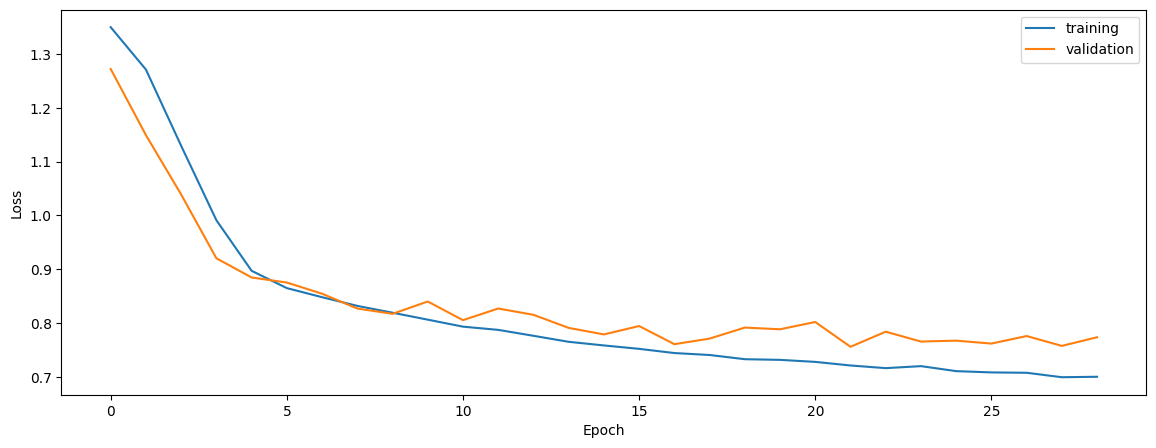

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7118258744083438
0.7096436472819216
0.7211390664185745


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.7118258744083438
0.7096436472819216
0.7211390664185745


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.7089628290901702
0.7166553825321598
0.7195952304507157


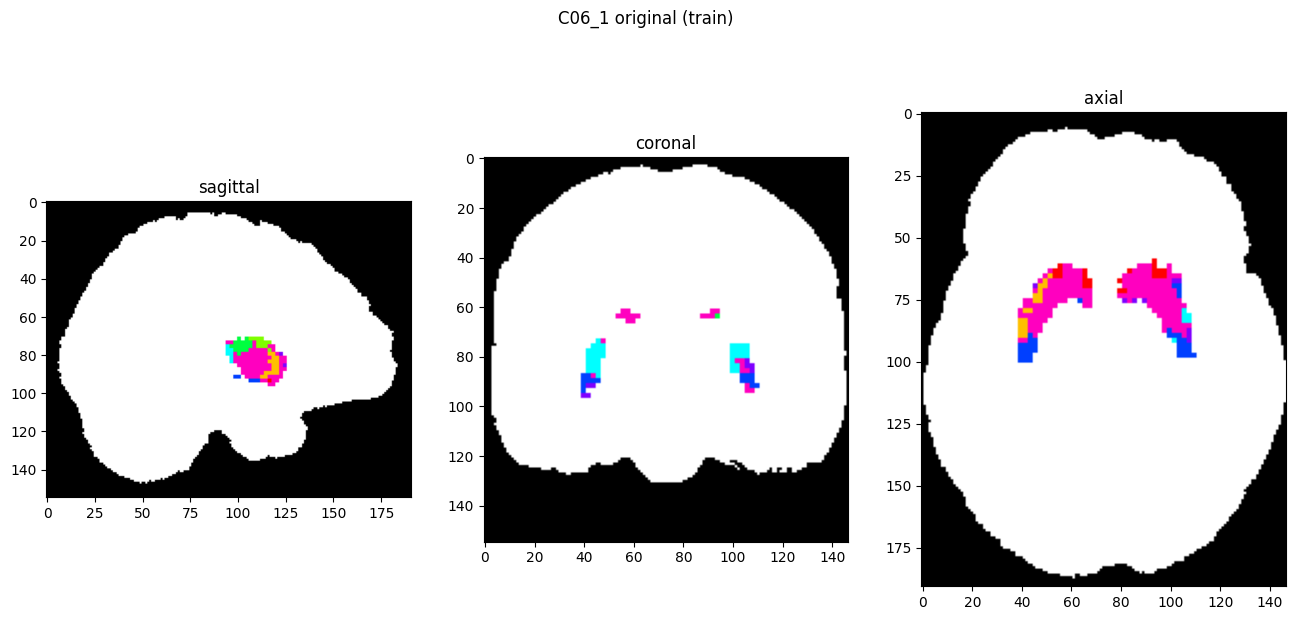

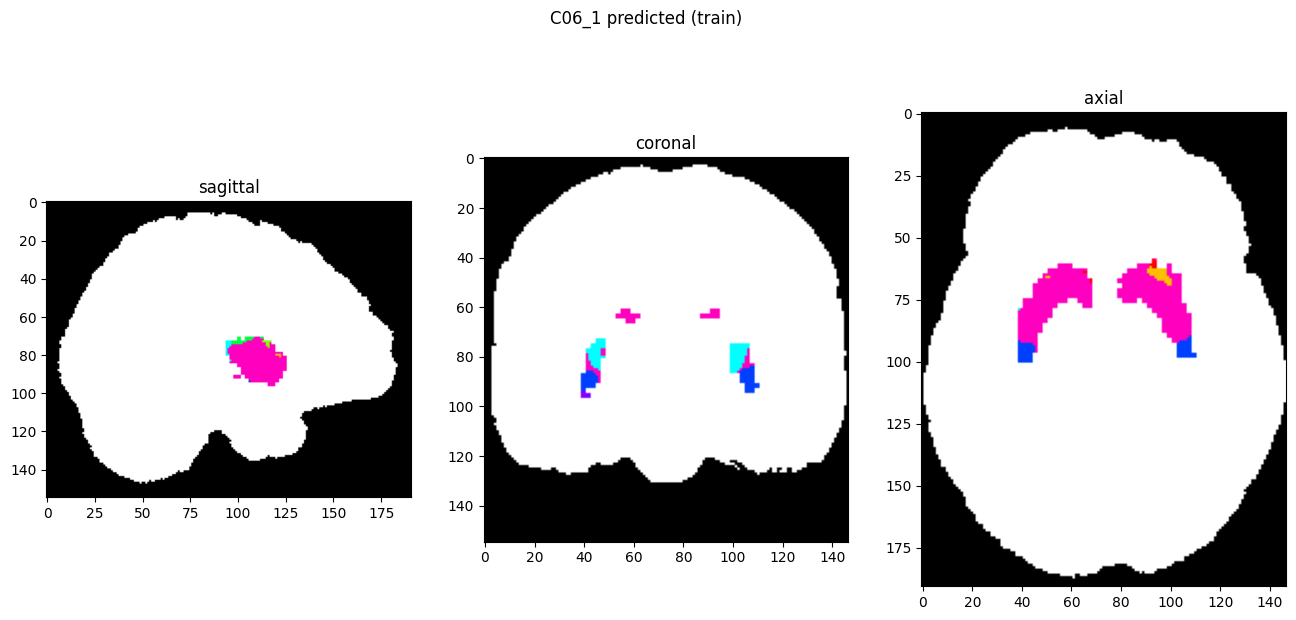

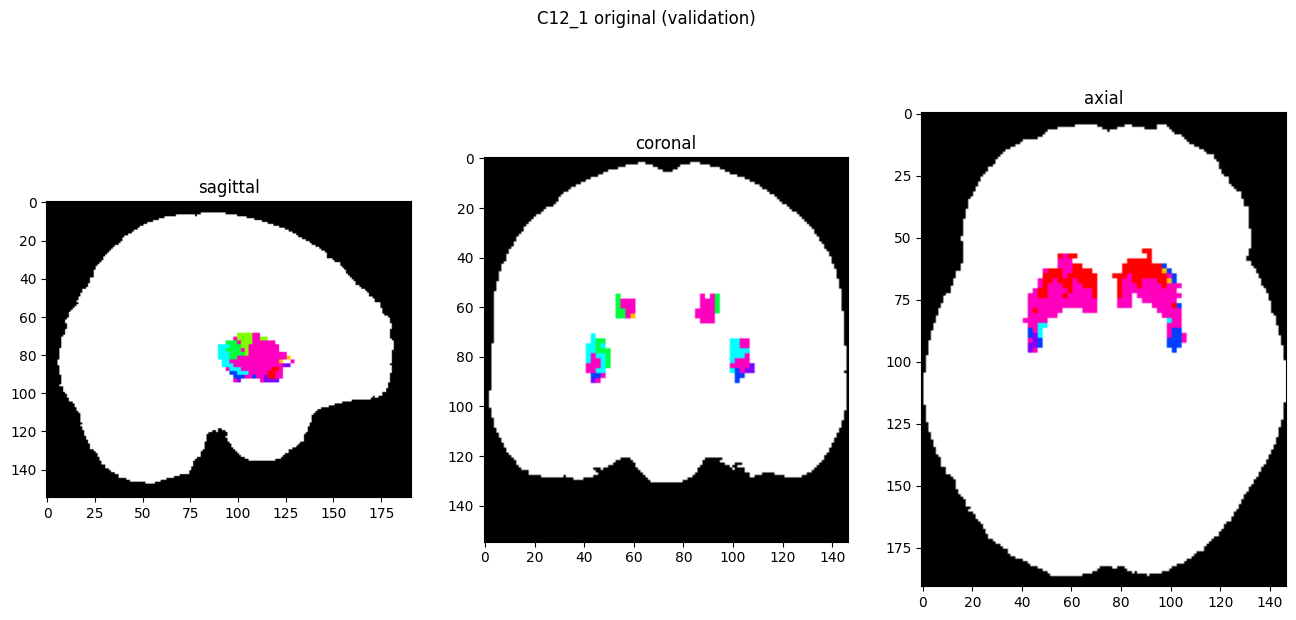

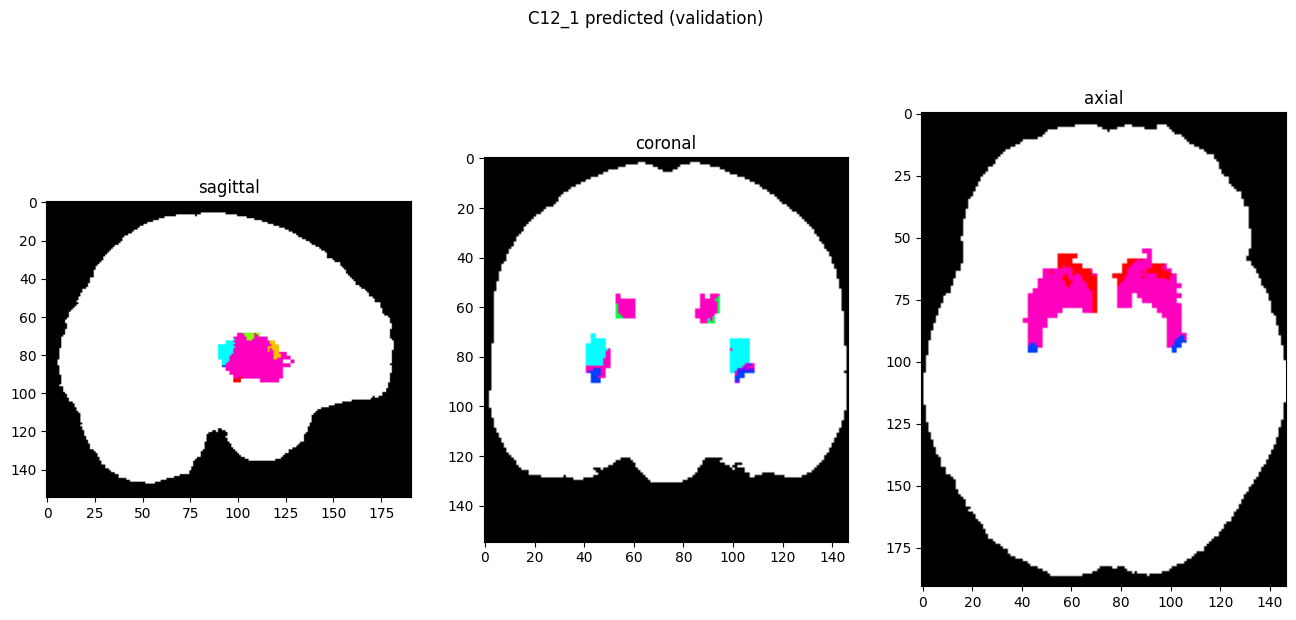

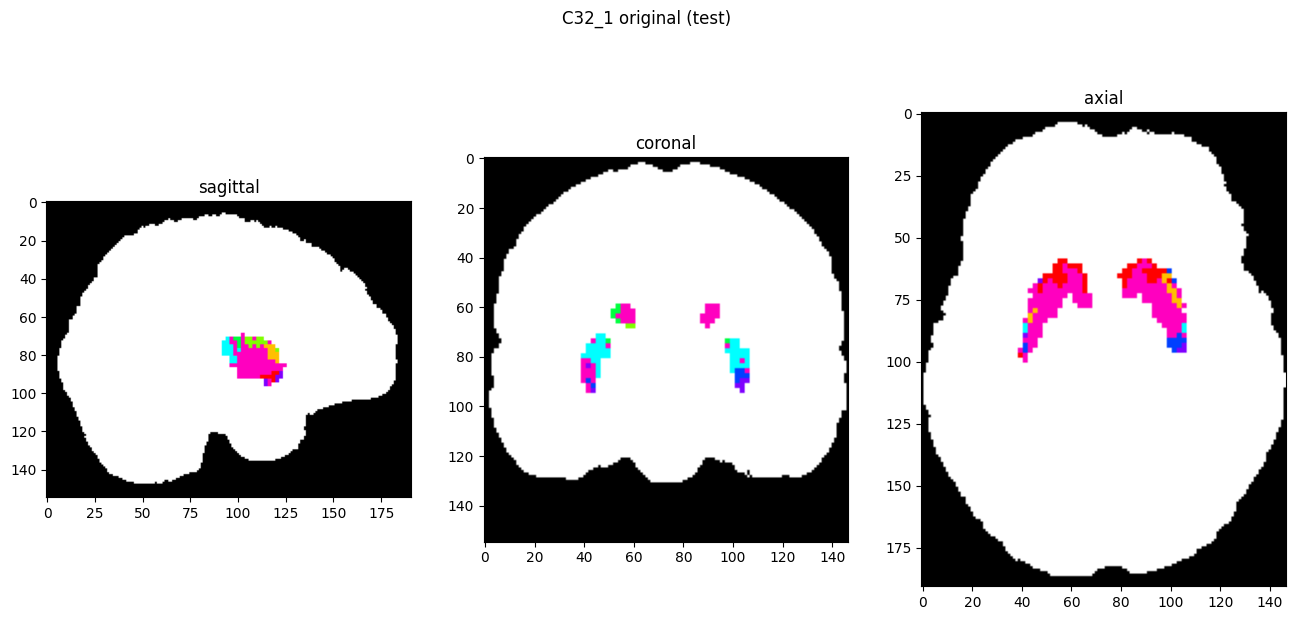

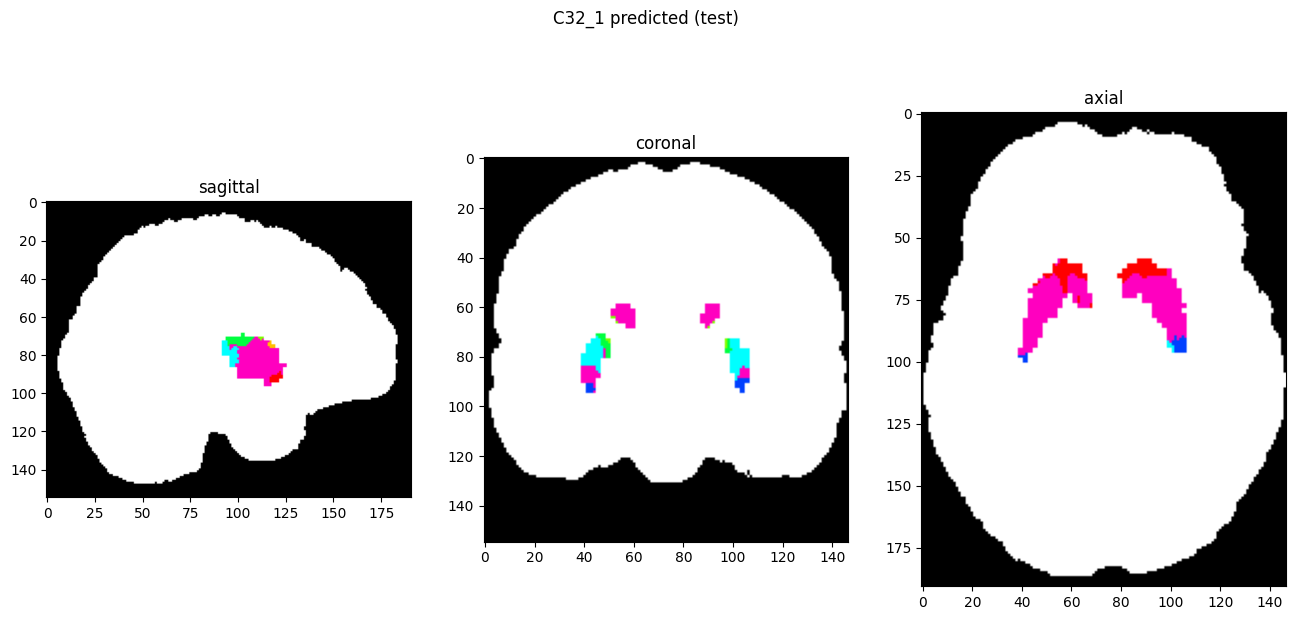

In [10]:
showResults(model, gen, threshold=0)